# Library

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
import umap
import joblib

import os
datasets_path = os.path.join(os.getcwd(), 'datasets')
os.chdir(datasets_path)

c:\Users\dommy\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## ClusterPipeline Class

### `ClusterPipeline` Class Description

The `ClusterPipeline` class is designed to handle an entire clustering pipeline, streamlining the process of determining the optimal number of clusters and applying various clustering algorithms to the data. It includes methods for data preparation, model evaluation, results visualization, and the calculation of metrics to assess clustering quality.

#### Main Methods

1. **`__init__`**:
   - **Description**: Initializes the clustering pipeline with a specific clustering model (e.g., KMeans, DBSCAN, Agglomerative, KMedoids, HDBSCAN).
   - **Parameters**:
     - `clustering_model`: The clustering model to be used.

2. **`elbow_method_clustering`**:
   - **Description**: Determines the optimal number of clusters using the elbow method.
   - **Parameters**:
     - `clustering_model`: Instance of a clustering model.
     - `X`: Data array.
     - `max_clusters`: Maximum number of clusters to consider.
   - **Returns**: The optimal number of clusters.

3. **`optimal_clusters_by_silhouette`**:
   - **Description**: Finds the optimal number of clusters using the Silhouette Score.
   - **Parameters**:
     - `data`: Data array.
     - `max_clusters`: Maximum number of clusters to consider.
     - `threshold`: Minimum threshold for the Silhouette Score.
   - **Returns**: The optimal number of clusters.

4. **`apply_clustering`**:
   - **Description**: Applies the clustering model to the data and determines the optimal number of clusters using the specified method (elbow or silhouette).
   - **Parameters**:
     - `data`: Data array.
     - `max_clusters`: Maximum number of clusters to consider.
     - `method`: Method to determine the optimal number of clusters ('elbow' or 'silhouette').
     - `threshold`: Threshold for the Silhouette Score.
   - **Returns**: Cluster labels and the updated clustering model.

5. **`plot_silhouette`**:
   - **Description**: Generates a Silhouette Score plot to visualize clustering quality.
   - **Parameters**:
     - `data`: Data array.
     - `labels`: Cluster labels.

6. **`intra_inter_cluster_ratio`**:
   - **Description**: Calculates the intra/inter-cluster ratio and the Dunn Index.
   - **Parameters**:
     - `data`: Data array.
     - `labels`: Cluster labels.
     - `centroids`: Cluster centroids.
   - **Returns**: The intra/inter-cluster ratio, the Dunn Index, and intra-cluster distances.

7. **`ssq`**:
   - **Description**: Calculates the sum of squared distances from centroids.
   - **Parameters**:
     - `intra_distances`: Intra-cluster distances.
   - **Returns**: Sum of squared distances from centroids.

8. **`reduce_dimensions`**:
   - **Description**: Reduces the data to two dimensions using a specified dimensionality reduction method.
   - **Parameters**:
     - `data`: Data array.
     - `dim_reduction_model`: Instance of the dimensionality reduction model (PCA, t-SNE, UMAP).
   - **Returns**: Data reduced to two dimensions.

9. **`visualize_clusters`**:
   - **Description**: Visualizes clusters using the reduced data and displays centroids if available.
   - **Parameters**:
     - `reduced_data`: Data reduced to two dimensions.
     - `labels`: Cluster labels.
     - `centroids`: Cluster centroids.
     - `reduced_centroids`: Centroids reduced to two dimensions.

10. **`run`**:
    - **Description**: Executes the entire clustering pipeline, from data preprocessing to results visualization.
    - **Parameters**:
      - `df`: DataFrame containing the data.
      - `scaler`: If `True`, applies `StandardScaler` to the data.
      - `max_clusters`: Maximum number of clusters to consider.
      - `method`: Method to determine the optimal number of clusters.
      - `threshold`: Threshold for the Silhouette Score.
      - `metric`: Metric to use for calculating the Silhouette Score.
      - `dim_reduction_method`: Dimensionality reduction method.
    - **Returns**: DataFrame containing clustering results.

#### Usage of the Class
This class provides a modular approach to clustering, making it easy to experiment with different models and evaluation methods. It is ideal for exploratory data analysis, allowing users to gain valuable insights into the groupings present in the data and the quality of the achieved separations.

In [2]:
class ClusterPipeline:

    def __init__(self, clustering_model: str = None):
        """
        Initialize the ClusterPipeline object.

        Args:
        - clustering_model: string representing the clustering model to use (KMeans, DBSCAN, Agglomerative, KMedoids)
        """
        self.clustering_model = clustering_model

    # Function to find the optimal number of clusters using the Elbow Method
    def elbow_method_clustering(self, clustering_model: object, X: np.ndarray, max_clusters: int = 10) -> int:
        """
        Finds the optimal number of clusters using the Elbow Method.

        Args:
        - clustering_model: clustering model instance
        - X: data array
        - max_clusters: maximum number of clusters to consider

        Returns:
        - optimal_k: optimal number of clusters
        """
        inertias = []
        
        for k in range(1, max_clusters + 1):
            # Set the number of clusters
            clustering_model.set_params(n_clusters=k)
            clustering_model.fit(X)
            
            # Append the inertia value (SSQ) to the list
            inertias.append(clustering_model.inertia_ if hasattr(clustering_model, 'inertia_') else None)

        # Calculate the optimal number of clusters using the Elbow Method
        x = np.arange(1, max_clusters + 1)
        y = np.array(inertias)
        
        p1 = np.array([x[0], y[0]])
        p2 = np.array([x[-1], y[-1]])
        
        distances = np.abs(np.cross(p2-p1, p1-np.vstack([x, y]).T)) / np.linalg.norm(p2-p1)
        optimal_k = np.argmax(distances) + 1

        plt.figure(figsize=(8, 6))
        plt.plot(x, y, marker='o')
        plt.xlabel('Number of Clusters')
        plt.ylabel('Inertia (SSQ)')
        plt.title('Elbow Method for Optimal K')
        plt.grid(True)
        plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K: {optimal_k}')
        plt.legend()
        plt.show()

        return optimal_k

    # Function to find the optimal number of clusters using the Silhouette Score
    def optimal_clusters_by_silhouette(self, data: np.ndarray, max_clusters: int = 10, threshold: float = 0.5) -> int:
        """
        Finds the optimal number of clusters using the Silhouette Score.

        Args:
        - data: data array
        - max_clusters: maximum number of clusters to consider
        - threshold: threshold for the Silhouette Score

        Returns:
        - optimal_k: optimal number of clusters
        """
        silhouette_scores = []

        for k in range(2, max_clusters + 1): # Start from k=2
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(data)
            silhouette_avg = silhouette_score(data, labels)
            silhouette_scores.append(silhouette_avg)

        # Find the optimal number of clusters using the Silhouette Score
        valid_scores = [score for score in silhouette_scores if score >= threshold]
        if valid_scores:
            optimal_k = np.argmax(silhouette_scores) + 2 # Add 2 to the index to get the actual number of clusters
        else:
            print(f"No valid K found with Silhouette Score >= {threshold}. Using default value.")
            optimal_k = 2

        plt.figure(figsize=(8, 6))
        plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Score for Optimal K')
        plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal K: {optimal_k}' if optimal_k else 'No valid K found')
        plt.legend()
        plt.grid(True)
        plt.show()

        return optimal_k

    def apply_clustering(self, data: np.ndarray, max_clusters: int = 10, method: str = 'elbow', threshold: float = 0.5) -> tuple:
        """
        Applies the clustering model to the data and returns the cluster labels.

        Args:
        - data: data array
        - max_clusters: maximum number of clusters to consider
        - method: method to determine the optimal number of clusters ('elbow' or 'silhouette')
        - threshold: threshold for the Silhouette Score

        Returns:
        - cluster_labels: cluster labels
        - clustering_model: clustering model instance
        """
        # Check if the clustering model has a fixed number of clusters
        if hasattr(self.clustering_model, 'n_clusters'):
            if method == 'elbow':
                best_k = self.elbow_method_clustering(clustering_model=self.clustering_model, X=data, max_clusters=max_clusters)
            elif method == 'silhouette':
                best_k = self.optimal_clusters_by_silhouette(data, max_clusters=max_clusters, threshold=threshold)
            else:
                raise ValueError("Invalid method. Please choose 'elbow' or 'silhouette'.")

            print(f"Optimal number of clusters: {best_k}")
            self.clustering_model.set_params(n_clusters=best_k)

        cluster_labels = self.clustering_model.fit_predict(data)

        return cluster_labels, self.clustering_model

    # Function to plot the Silhouette Score
    def plot_silhouette(self, data: np.ndarray, labels: np.ndarray, metric: str) -> None:
        """
        Plots the Silhouette plot for the clusters.

        Args:
        - data: data array
        - labels: cluster labels
        - metric: metric to use for Silhouette Score calculation
        """
        n_clusters = len(np.unique(labels))
        silhouette_avg = silhouette_score(data, labels, metric=metric)
        sample_silhouette_values = silhouette_samples(data, labels, metric=metric)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_title("Silhouette plot for the clusters")
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # 2nd Plot showing the actual clusters formed
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(data)

        ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='nipy_spectral', s=30)
        ax2.set_title("Clusters")
        plt.show()

    def intra_inter_cluster_ratio(self, data: np.ndarray, labels: np.ndarray, centroids: np.ndarray = None) -> tuple:
        """
        Calculates the intra/inter-cluster ratio and the Dumn Index.

        Args:
        - data: data array
        - labels: cluster labels
        - centroids: cluster centroids

        Returns:
        - ratio: intra/inter-cluster ratio
        - dumn_index: Dumn Index
        - intra_distances: intra-cluster distances
        """
        intra_distances = []
        inter_distances = []

        unique_labels = np.unique(labels)
        for label in unique_labels:
            cluster_points = data[labels == label]
            
            # Calculate the intra-cluster distance
            if centroids is not None:
                centroid = centroids[label]
            else:
                centroid = np.mean(cluster_points, axis=0)

            intra_distance = np.sum(np.square(cluster_points - centroid))
            intra_distances.append(intra_distance)

            # Calculate the inter-cluster distance
            for other_label in unique_labels:
                if other_label != label:
                    if centroids is not None:
                        inter_distance = np.linalg.norm(centroids[label] - centroids[other_label])
                    else:
                        other_centroid = np.mean(data[labels == other_label], axis=0)
                        inter_distance = np.linalg.norm(centroid - other_centroid)
                        
                    inter_distances.append(inter_distance)

        avg_intra = np.mean(intra_distances)
        avg_inter = np.mean(inter_distances) if inter_distances else 0

        ratio = avg_intra / avg_inter if avg_inter > 0 else np.inf

        # Dumn Index
        dumn_index = avg_intra / (avg_inter + 1e-9)
        print(f"Dumn Index: {dumn_index}")

        return ratio, dumn_index, intra_distances

    # SSQ: Sum of Squared Distances
    def ssq(self, intra_distances: np.ndarray) -> float:
        """
        Calculates the Sum of Squared Distances.

        Args:
        - intra_distances: intra-cluster distances

        Returns:
        - ssq_value: SSQ value
        """
        ssq_value = np.sum(intra_distances)
        print(f"SSQ (Sum of Squared Distances): {ssq_value}")
        return ssq_value

    def reduce_dimensions(self, data: np.ndarray, dim_reduction_model: object) -> np.ndarray:
        """
        Reduces the dimensions of the data using the specified dimensionality reduction model.

        Args:
        - data: data array
        - dim_reduction_model: dimensionality reduction model instance

        Returns:
        - reduced_data: data array reduced to 2 dimensions
        """
        reduced_data = dim_reduction_model.fit_transform(data)
        return reduced_data

    def visualize_clusters(self, reduced_data: np.ndarray, labels: np.ndarray, centroids: np.ndarray = None, reduced_centroids: np.ndarray = None) -> None:
        """
        Visualizes the clusters in 2D space.

        Args:
        - reduced_data: data array reduced to 2 dimensions
        - labels: cluster labels
        - centroids: cluster centroids
        - reduced_centroids: centroids reduced to 2 dimensions

        Returns:
        - None
        """
        plt.figure(figsize=(10, 8))

        # Cluster Visualization
        sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=labels, palette='viridis', legend='full', s=50)

        # Centroids Visualization
        if reduced_centroids is not None:
            plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], color='red', marker='X', 
                        s=100, edgecolor='black', linewidth=1, alpha=0.7, label='Centroid', linestyle='--')

        plt.title('Cluster Visualization with Reduced Data and Centroids')
        plt.legend()
        plt.show()
    
    def run(self, df: pd.DataFrame, scaler: bool = False, max_clusters: int = 10, method: str = 'elbow', threshold: float = 0.5, 
            metric: str = 'euclidean', dim_reduction_method: object = PCA(n_components=2)) -> pd.DataFrame:
        """
        Runs the clustering pipeline on the input DataFrame.

        Args:
        - df: input DataFrame
        - scaler: boolean flag to scale the data
        - max_clusters: maximum number of clusters to consider
        - method: method to determine the optimal number of clusters ('elbow' or 'silhouette')
        - threshold: threshold for the Silhouette Score
        - metric: metric to use for Silhouette Score calculation
        - dim_reduction_method: dimensionality reduction model instance

        Returns:
        - results_df: DataFrame containing the clustering results
        """
        # Step 1: Preprocess the data
        if scaler:
            # Check if the DataFrame contains numerical data
            df = pd.DataFrame(df)
            if df.select_dtypes(include=[np.number]).shape[1] > 0:
                data = StandardScaler().fit_transform(df.select_dtypes(include=[np.number]))
            else:
                data = df.values  # Convert the DataFrame to a NumPy array
        elif isinstance(df, np.ndarray):
            data = df
        else:
            data = df.values

        # Step 2: Apply clustering
        cluster_labels, model = self.apply_clustering(data, max_clusters=max_clusters, method=method, threshold=threshold)

        # Step 3: Plot the Silhouette Score
        silhouette = silhouette_score(data, cluster_labels, metric=metric)
        self.plot_silhouette(data, cluster_labels, metric=metric)

        # Step 4: Reduce the dimensions of the data and the centroids
        reduced_data = self.reduce_dimensions(data, dim_reduction_model=dim_reduction_method)

        # Reduce the centroids if available
        if hasattr(model, 'cluster_centers_') and not isinstance(dim_reduction_method, TSNE):
            reduced_centroids = self.reduce_dimensions(model.cluster_centers_, dim_reduction_model=dim_reduction_method)
        else:
            reduced_centroids = None

        # Visualize the clusters
        self.visualize_clusters(reduced_data, cluster_labels, centroids=model.cluster_centers_ if hasattr(model, 'cluster_centers_') else None, reduced_centroids=reduced_centroids)

        # Step 5: Calculate the Intra/Inter-Cluster Ratio and the SSQ
        print(f"Silhouette Score: {silhouette}")
        if hasattr(model, 'cluster_centers_'):
            intra_inter_ratio, dumn_index, intra_distances = self.intra_inter_cluster_ratio(data, cluster_labels, model.cluster_centers_ if hasattr(model, 'cluster_centers_') else None)
            ssq_value = self.ssq(intra_distances)
        else:
            intra_inter_ratio, dumn_index, ssq_value = None, None, None

        # Step 6: Store the results in a DataFrame
        results_dict = {
            'Silhouette Score': [silhouette],
            'Intra/Inter-Cluster Ratio': [intra_inter_ratio],
            'Dumn Index': [dumn_index],
            'SSQ (Sum of Squared Distances)': [ssq_value],
            'Cluster Labels': [cluster_labels]
        }

        results_df = pd.DataFrame(results_dict)

        return results_df

## Other Functions

In [3]:
def create_countplot(df: pd.DataFrame, x_var: str, hue_var: str, title: str, figsize: tuple = (12, 6), palette: str = 'muted') -> None:
    """
    Creates a countplot based on the specified variables.

    Args:
    - df: input DataFrame
    - x_var: x-axis variable
    - hue_var: hue variable
    - title: plot title
    - figsize: plot dimensions
    - palette: color palette

    Returns:
    - None
    """
    plt.figure(figsize=figsize)
    
    if isinstance(x_var, str) and isinstance(hue_var, str):
        sns.countplot(x=x_var, hue=hue_var, data=df, palette=palette)
    else:
        sns.countplot(x=x_var, hue=hue_var, palette=palette)
    
    plt.title(title)
    plt.xlabel(x_var if isinstance(x_var, str) else x_var.name)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

def plot_categorical_heatmap(df: pd.DataFrame, categorical_features: list, target_feature: str, n_cols: int = 4, figsize_per_plot: tuple = (5, 4)) -> None:
    """
    Creates a heatmap for each categorical feature in relation to the target feature.

    Args:
    - df: DataFrame containing the categorical features and the target feature
    - categorical_features: list of categorical features
    - target_feature: name of the target feature (e.g., cluster)
    - n_cols: number of columns in the subplot layout
    - figsize_per_plot: dimensions of each plot as a tuple (width, height)

    Returns:
    - None
    """
    n_features = len(categorical_features)
    n_rows = int(np.ceil(n_features / n_cols))

    # Set the figure and subplot array
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * figsize_per_plot[0], n_rows * figsize_per_plot[1]))
    axes = axes.flatten()

    for i, feature in enumerate(categorical_features):
        contingency_table = pd.crosstab(df[feature], target_feature, normalize='index')

        # Create the heatmap
        sns.heatmap(contingency_table, annot=True, cmap='Blues', fmt='.2f', ax=axes[i])
        axes[i].set_title(f'{feature} vs {target_feature.name}')
        axes[i].set_xlabel(target_feature.name)
        axes[i].set_ylabel(feature)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_boxplots(df: pd.DataFrame, numerical_features: list, target_feature: str, n_cols: int = 4, figsize_per_plot: tuple = (5, 4)) -> None:
    """
    Creates boxplots for each numerical feature in relation to the target feature.

    Args:
    - df: DataFrame containing the numerical features and the target feature
    - numerical_features: list of numerical features
    - target_feature: name of the target feature (e.g., cluster)
    - n_cols: number of columns in the subplot layout
    - figsize_per_plot: dimensions of each plot as a tuple (width, height)

    Returns:
    - None
    """
    n_features = len(numerical_features)
    n_rows = int(np.ceil(n_features / n_cols))
    
    # Set the figure and subplot array
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * figsize_per_plot[0], n_rows * figsize_per_plot[1]))
    axes = axes.flatten()

    # Create boxplots for each numerical feature
    for i, feature in enumerate(numerical_features):
        sns.boxplot(x=target_feature, y=df[feature], ax=axes[i])
        axes[i].set_title(f'{feature}', fontsize=10)
        axes[i].set_xlabel(target_feature.name, fontsize=9)
        axes[i].set_ylabel(feature, fontsize=9)
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Function to plot the distribution of numerical features
def clustering_random_forest(df: pd.DataFrame, clustering_algorithm: object, rf_model: object, n_clusters: int, importance_threshold: float = 0.01) -> pd.DataFrame:
    """
    Performs clustering and feature importance using a Random Forest model.

    Args:
    - df: input DataFrame
    - clustering_algorithm: clustering algorithm instance
    - rf_model: Random Forest model instance
    - n_clusters: number of clusters
    - importance_threshold: threshold for feature importance

    Returns:
    - df_relevant: DataFrame containing the relevant features based on the importance threshold
    """
    # Perform clustering
    cluster_labels = clustering_algorithm.fit_predict(df)

    # Fit the Random Forest model
    rf_model.fit(df, cluster_labels)

    # Get the feature importances
    importances = rf_model.feature_importances_

    # Create a DataFrame with the feature importances
    importance_df = pd.DataFrame({'Feature': df.columns, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Feature importance {type(clustering_algorithm).__name__} for {n_clusters} Cluster')
    plt.show()

    # Filter the relevant features based on the importance threshold
    relevant_features = importance_df[importance_df['Importance'] >= importance_threshold]['Feature']
    df_relevant = df[relevant_features].copy()

    return df_relevant

def hierarchical_clustering_with_silhouette(df: pd.DataFrame, methods: list, min_clusters: int = 2, max_clusters: int = 10, 
                                            min_points_in_cluster: int = 100, metrics: list = ['cosine']) -> tuple:
    """
    Performs hierarchical clustering with different parameters and calculates the Silhouette Score.

    Args:
    - df: input DataFrame
    - methods: list of linkage methods to test
    - min_clusters: minimum number of clusters to consider
    - max_clusters: maximum number of clusters to consider
    - min_points_in_cluster: minimum number of points in a cluster (default: 100)
    - metrics: list of metrics to use for hierarchical clustering (default: ['cosine'])

    Returns:
    - best_score: best Silhouette Score found
    - best_params: parameters that led to the best score, including the cluster labels
    """
    
    best_score = -1
    best_params = None
    
    for i in range(min_clusters, max_clusters + 1):
        for m in methods:
            for metric in metrics:
                try:
                    agg1 = AgglomerativeClustering(n_clusters=i, linkage=m, metric=metric)
                    labels = agg1.fit_predict(df)
                    
                    # Check the number of unique labels
                    unique_labels = set(labels)
                    if len(unique_labels) > 1:  # At least 2 clusters
                        valid_clusters = [label for label in unique_labels if label != -1]
                        
                        # Check if each cluster has at least the minimum number of points
                        cluster_sizes = [np.sum(labels == label) for label in valid_clusters]
                        
                        if all(size >= min_points_in_cluster for size in cluster_sizes):
                            score = silhouette_score(df, labels, metric=metric)
                            print(f"Clusters: {i}, Linkage: {m}, Metric: {metric}, Score: {score:.3f}, Sizes: {cluster_sizes}")

                            if score > best_score:
                                best_score = score
                                best_params = (i, m, metric, labels)  # Add the cluster labels

                except Exception as e:
                    continue

    return best_score, best_params

def dbscan_with_silhouette(df: pd.DataFrame, eps_values: list, min_samples_values: list, min_points_in_cluster: int = 100, 
                           max_outlier_percentage: float = 0.2, metrics: list = ['cosine'], tollerance: int = 10) -> tuple:
    """
    Performs DBSCAN clustering with different parameters and calculates the Silhouette Score.

    Args:
    - df: input DataFrame
    - eps_values: list of epsilon values to test
    - min_samples_values: list of min_samples values to test
    - min_points_in_cluster: minimum number of points in a cluster (default: 100)
    - max_outlier_percentage: maximum percentage of outliers allowed (default: 0.2)
    - metrics: list of metrics to use for DBSCAN (default: ['cosine'])
    - tollerance: number of iterations without valid clusters before stopping the search (default: 10)

    Returns:
    - best_score: best Silhouette Score found
    - best_params: parameters that led to the best score, including the cluster labels
    """
    
    best_score = -1
    best_params = None
    no_cluster_iterations = 0  # Counter for iterations without valid clusters
    
    total_points = len(df)
    allowed_outliers = int(total_points * max_outlier_percentage)  # Maximum number of outliers
    
    for metric in metrics:
        for eps in eps_values:
            if no_cluster_iterations >= tollerance:
                print(f"Tollerance reached. Stopping the search.")
                break
            for min_samples in min_samples_values:
                try:
                    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
                    labels = dbscan.fit_predict(df)
                    
                    # Calculate the number of outliers and clusters
                    num_outliers = np.sum(labels == -1)
                    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

                    # Check if there are more than 1 cluster and less than the total number of points
                    if num_clusters > 1 and num_clusters < total_points and num_outliers <= allowed_outliers:
                        # Check if each cluster has at least the minimum number of points
                        valid_clusters = [label for label in set(labels) if label != -1]
                        cluster_sizes = [np.sum(labels == label) for label in valid_clusters]

                        if all(size >= min_points_in_cluster for size in cluster_sizes):
                            score = silhouette_score(df, labels, metric=metric)
                            print(f"eps={eps}, min_samples={min_samples}, metric={metric}, score={score:.3f}, outliers={num_outliers}, clusters={num_clusters}")
                            
                            if score > best_score:
                                best_score = score
                                best_params = (eps, min_samples, metric, labels)  # Add the cluster labels
                            
                            no_cluster_iterations = 0  # Reset the counter
                        else:
                            no_cluster_iterations += 1
                            print(f"eps={eps}, min_samples={min_samples}, metric={metric}: Not enough points in clusters.")
                    else:
                        no_cluster_iterations += 1
                        print(f"eps={eps}, min_samples={min_samples}, metric={metric}: Too many outliers or not enough clusters.")
                        
                    if no_cluster_iterations >= tollerance:
                        print("Tollerance reached. Stopping the search.")
                        break

                except Exception as e:
                    print(f"Eps={eps}, min_samples={min_samples}, metric={metric}: {str(e)}")
                    continue

    return best_score, best_params

def plot_silhouette_and_clusters(df: pd.DataFrame, best_params: tuple, clustering_algorithm: object, metric: str = 'euclidean', 
                                umap: bool = False, umap_model: object = None) -> None:
    """
    Plots the Silhouette Scores and the clusters in the reduced space.

    Args:
    - df: input DataFrame
    - best_params: best parameters found for the clustering algorithm
    - clustering_algorithm: clustering algorithm instance
    - metric: metric to use for Silhouette Score calculation
    - umap: boolean flag to use UMAP for dimensionality reduction
    - umap_model: UMAP model instance

    Returns:
    - None
    """
    # If the clustering algorithm is KMeans, use n_clusters
    if clustering_algorithm == AgglomerativeClustering:
        clustering_model = clustering_algorithm(n_clusters=best_params[0], linkage=best_params[1], metric=best_params[2])
    # If the clustering algorithm is DBSCAN, use eps and min_samples
    elif clustering_algorithm == DBSCAN:
        clustering_model = clustering_algorithm(eps=best_params[0], min_samples=best_params[1], metric=best_params[2])
    else:
        raise ValueError("Invalid clustering algorithm. Please use AgglomerativeClustering or DBSCAN.")
    
    # Fit the clustering model and get the cluster labels
    labels = clustering_model.fit_predict(df)

    # Calculate the Silhouette Score
    if len(set(labels)) > 1:
        silhouette_avg = silhouette_score(df, labels, metric=metric)
        sample_silhouette_values = silhouette_samples(df, labels, metric=metric)

        # Plot the Silhouette Scores
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        y_lower = 10

        for i in range(len(set(labels))):  # Iterate over the clusters
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            ax1.fill_betweenx(np.arange(y_lower, y_lower + size_cluster_i), 0, ith_cluster_silhouette_values)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i + 1}')
            y_lower += size_cluster_i

        ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
        ax1.set_title(f'Silhouette Scores (Average: {silhouette_avg:.2f})')
        ax1.set_xlabel('Silhouette Coefficient')
        ax1.set_ylabel('Cluster Label')
        ax1.set_yticks([])
        ax1.set_xlim([-0.1, 1])

        # Reduce the dimensions of the data
        if umap and umap_model is not None:
            # Use UMAP for dimensionality reduction
            reduced_data = umap_model.fit_transform(df)[:, :2]
        else:
            # Use PCA for dimensionality reduction
            pca = PCA(n_components=2)
            reduced_data = pca.fit_transform(df)

        # Plot the clusters in the reduced space
        ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k', s=50)
        ax2.set_title('Clusters in Reduced Space')
        ax2.set_xlabel('Component 1')
        ax2.set_ylabel('Component 2')

        plt.tight_layout()
        plt.show()
    else:
        print("Only one cluster found. Unable to calculate the Silhouette Score.")

# Function to plot the distribution of numerical features
def plot_information_gain(X: pd.DataFrame, y: pd.Series, top_ig: int = 20, figsize: tuple = (10, 6)) -> pd.DataFrame:
    """
    Plots the Information Gain of the features.

    Args:
    - X: input DataFrame containing the features
    - y: target Series
    - top_ig: number of top features to display
    - figsize: dimensions of the plot

    Returns:
    - info_gain_df: DataFrame containing the Information Gain of the features
    """
    info_gain = mutual_info_classif(X, y)

    info_gain_df = pd.DataFrame({
        'Feature': X.columns,
        'Information Gain': info_gain
    }).sort_values(by='Information Gain', ascending=False)

    plt.figure(figsize=figsize)
    sns.barplot(data=info_gain_df.head(top_ig), x='Information Gain', y='Feature')
    plt.title('Information Gain Feature')
    plt.xlabel('Information Gain')
    plt.ylabel('Feature')
    plt.show()

    return info_gain_df

def top_rules_high_confidence_low_support(rules: pd.DataFrame, top_n: int = 10, confidence_threshold: float = 0.8) -> pd.DataFrame:
    """
    Obtains the top N rules with high confidence and low support.

    Args:
    - rules: DataFrame containing the association rules
    - top_n: number of top rules to display
    - confidence_threshold: minimum confidence threshold

    Returns:
    - top_rules: DataFrame containing the top rules
    """
    formatted_rules = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].copy()
    
    # Convert frozensets to strings
    formatted_rules['antecedents'] = formatted_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
    formatted_rules['consequents'] = formatted_rules['consequents'].apply(lambda x: ', '.join(list(x)))
    
    # Calculate the length of antecedents and consequents
    formatted_rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))
    formatted_rules['consequent_len'] = rules['consequents'].apply(lambda x: len(x))
    
    # Filter the rules based on the confidence threshold
    filtered_rules = formatted_rules[formatted_rules['confidence'] >= confidence_threshold]
    
    # Sort the rules by antecedent length, consequent length, and support
    filtered_rules = filtered_rules.sort_values(by=['antecedent_len', 'consequent_len', 'support'], ascending=[True, True, True])
    
    # Get the top N rules
    top_rules = (filtered_rules
                 .groupby(['antecedent_len', 'consequent_len'])
                 .head(top_n)
                 .reset_index(drop=True))
    
    return top_rules

def search_rules_by_multiple_substrings(rules: pd.DataFrame, search_criteria: list) -> pd.DataFrame:
    """
    Filters the association rules based on multiple search criteria.

    Args:
    - rules: DataFrame containing the association rules
    - search_criteria: list of dictionaries containing the search criteria

    Returns:
    - filtered_rules: DataFrame containing the rules that satisfy the search criteria
    """
    # Function to check if a value contains all the substrings
    def contains_all_substrings(value, substrings):
        # Check if all substrings are present in the value
        return all(substring in str(value) for substring in substrings)

    # Initialize the filtered rules
    filtered_rules = pd.Series([True] * len(rules))

    # Iterate over the search criteria
    for criteria in search_criteria:
        column = criteria['column']
        substrings = criteria['substrings']
        search_type = criteria.get('search_type', 'both')  # Default: search in both antecedents and consequents

        if search_type == 'antecedents':
            filtered_rules &= rules['antecedents'].apply(contains_all_substrings, substrings=substrings)
        elif search_type == 'consequents':
            filtered_rules &= rules['consequents'].apply(contains_all_substrings, substrings=substrings)
        else:  # 'both'
            filtered_rules &= (rules['antecedents'].apply(contains_all_substrings, substrings=substrings) | 
                               rules['consequents'].apply(contains_all_substrings, substrings=substrings))

    # Filter the rules based on the search criteria
    return rules[filtered_rules]

def filter_rules_with_mapping(rules: pd.DataFrame, mapping: list) -> None:
    """
    Filters the association rules based on the mapping criteria.

    Args:
    - rules: DataFrame containing the association rules
    - mapping: list of dictionaries containing the mapping criteria

    Returns:
    - None
    """
    # Function to check if a value is in the mapping
    filtered_rules = search_rules_by_multiple_substrings(rules, mapping)

    # Print the filtered rules
    for i in range(len(filtered_rules)):
        antecedent = ', '.join(list(filtered_rules.iloc[i]["antecedents"]))  # Convert the frozenset to a string
        consequent = ', '.join(list(filtered_rules.iloc[i]["consequents"]))  # Convert the frozenset to a string
        print(f'{antecedent} -> {consequent}')
        print('\n')

# Plot Graphs

Before proceeding with the clustering analysis, I explore the data by creating some graphs, using the Effective Price as the main variable. This choice is based on the fact that the Effective Price provides a direct and relevant indication of the economic impact of the contracts. <br>Through these preliminary graphs, I aim to identify any patterns that may emerge. Later, I will compare these observations with the results of the clustering analysis to verify their validity.

In [4]:
df = pd.read_csv('PPPData_EN_1.0_completed.csv')
df.head()

Environmental criteria (T/F)  Publication Year  Close Year Municipality  \
0                             0              2020        2022       Almada   
1                             0              2020        2022        Viseu   
2                             0              2022        2022        Loulé   
3                             0              2020        2022        Viseu   
4                             0              2021        2022        Viseu   

  District Submission deadline (range)  \
0  Setúbal                   Very Long   
1    Viseu                        Long   
2     Faro                        Long   
3    Viseu                       Short   
4    Viseu                       Short   

  Diference between close and signing dates Execution deadline (days)  \
0                               Medium Days             Long Deadline   
1                               Medium Days            Short Deadline   
2                                  Few Days            Short Deadline   
3                               Medium Days            Short Deadline   
4                                  Few Days            Short Deadline   

  Base Bid Price Class I. price Class  ...  Signing Day  Closing Date Year  \
0            Low Price      Low Price  ...           11               2022   
1            Low Price      Low Price  ...           28               2022   
2            Low Price      Low Price  ...           16               2022   
3            Low Price      Low Price  ...            8               2022   
4            Low Price      Low Price  ...           20               2022   

   Closing Date Month  Closing Date Day  E. price Class  \
0                   5                31       Low Price   
1                   3                14       Low Price   
2                   6                11       Low Price   
3                   5                 3       Low Price   
4                   4                29       Low Price   

   Difference between the effective and initial price class  engineering work  \
0                                     Low Difference                        0   
1                                  Medium Difference                        0   
2                                  Medium Difference                        0   
3                                  Medium Difference                        0   
4                                  Medium Difference                        0   

   refurbishment work  surfaced work  Justification for deadline change  
0                   0              0                      Not Specified  
1                   0              0                            specify  
2                   0              0                     carry delivery  
3                   0              0                             change  
4                   0              0                             change  

[5 rows x 26 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4937 entries, 0 to 4936
Data columns (total 26 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Environmental criteria (T/F)                              4937 non-null   int64  
 1   Publication Year                                          4937 non-null   int64  
 2   Close Year                                                4937 non-null   int64  
 3   Municipality                                              4937 non-null   object 
 4   District                                                  4937 non-null   object 
 5   Submission deadline (range)                               4937 non-null   object 
 6   Diference between close and signing dates                 4937 non-null   object 
 7   Execution deadline (days)                                 4937 non-null   object 
 8   Base Bid Price Cla

In [6]:
df.describe()

Environmental criteria (T/F)  Publication Year   Close Year  \
count                   4937.000000       4937.000000  4937.000000   
mean                       0.054892       2016.953008  2018.905003   
std                        0.227792          2.694654     2.325622   
min                        0.000000       2009.000000  2013.000000   
25%                        0.000000       2015.000000  2017.000000   
50%                        0.000000       2017.000000  2019.000000   
75%                        0.000000       2019.000000  2021.000000   
max                        1.000000       2022.000000  2022.000000   

       Award criteria class  Classification of the multifactor criteria (%)  \
count           4937.000000                                     4937.000000   
mean               1.164877                                        0.601526   
std                0.853512                                        0.429865   
min                0.000000                                        0.000000   
25%                0.000000                                        0.000000   
50%                1.000000                                        0.700000   
75%                2.000000                                        1.000000   
max                2.000000                                        1.000000   

       Number of bidders  Signing Year  Signing Month  Signing Day  \
count        4937.000000   4937.000000    4937.000000  4937.000000   
mean            0.139715   2017.314564       6.818108    16.202957   
std             0.146344      2.574359       3.290890     8.701011   
min             0.000000   2010.000000       1.000000     1.000000   
25%             0.000000   2015.000000       4.000000     9.000000   
50%             0.125000   2018.000000       7.000000    16.000000   
75%             0.200000   2019.000000      10.000000    24.000000   
max             1.000000   2022.000000      12.000000    31.000000   

       Closing Date Year  Closing Date Month  Closing Date Day  \
count        4937.000000         4937.000000       4937.000000   
mean         2018.905003            6.405915         16.732834   
std             2.325622            3.570843          8.884736   
min          2013.000000            1.000000          1.000000   
25%          2017.000000            3.000000          9.000000   
50%          2019.000000            6.000000         17.000000   
75%          2021.000000           10.000000         24.000000   
max          2022.000000           12.000000         31.000000   

       engineering work  refurbishment work  surfaced work  
count       4937.000000         4937.000000    4937.000000  
mean           0.041321            0.079603       0.124367  
std            0.199051            0.270705       0.330033  
min            0.000000            0.000000       0.000000  
25%            0.000000            0.000000       0.000000  
50%            0.000000            0.000000       0.000000  
75%            0.000000            0.000000       0.000000  
max            1.000000            1.000000       1.000000

## Plot1: Effective Price vs District

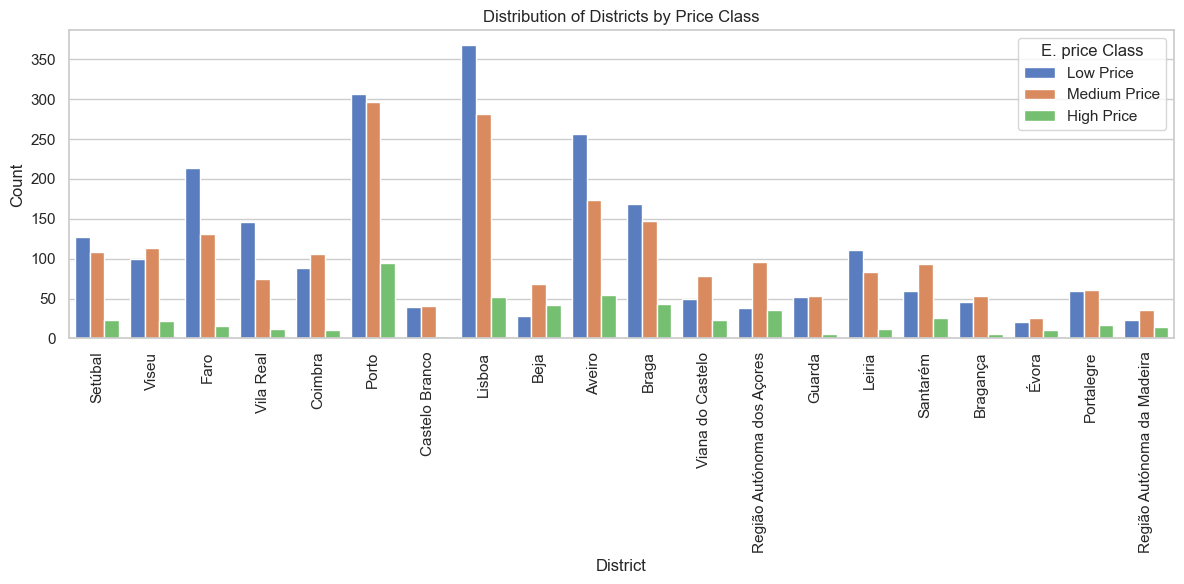

In [7]:
create_countplot(df, 'District', 'E. price Class', 'Distribution of Districts by Price Class')

Almost all districts follow the same distribution, with a predominance of low prices in each district.

## Plot2: Effective price vs Award criteria class

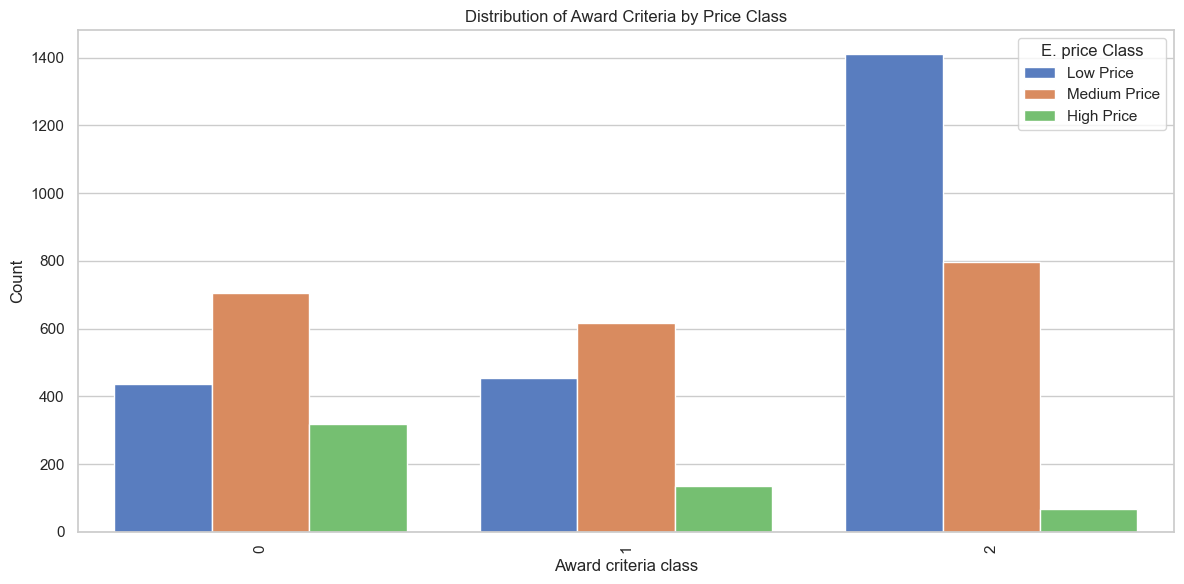

In [8]:
create_countplot(df, 'Award criteria class', 'E. price Class', 'Distribution of Award Criteria by Price Class')

For criterion award in the 3rd class, it is most influenced by a Low Price (as the name Lowest Price also suggests), while criteria 0 and 1 have the same distribution, the difference being that criterion 0 has a higher High Price influence.

## Plot3: Effective price vs Signing

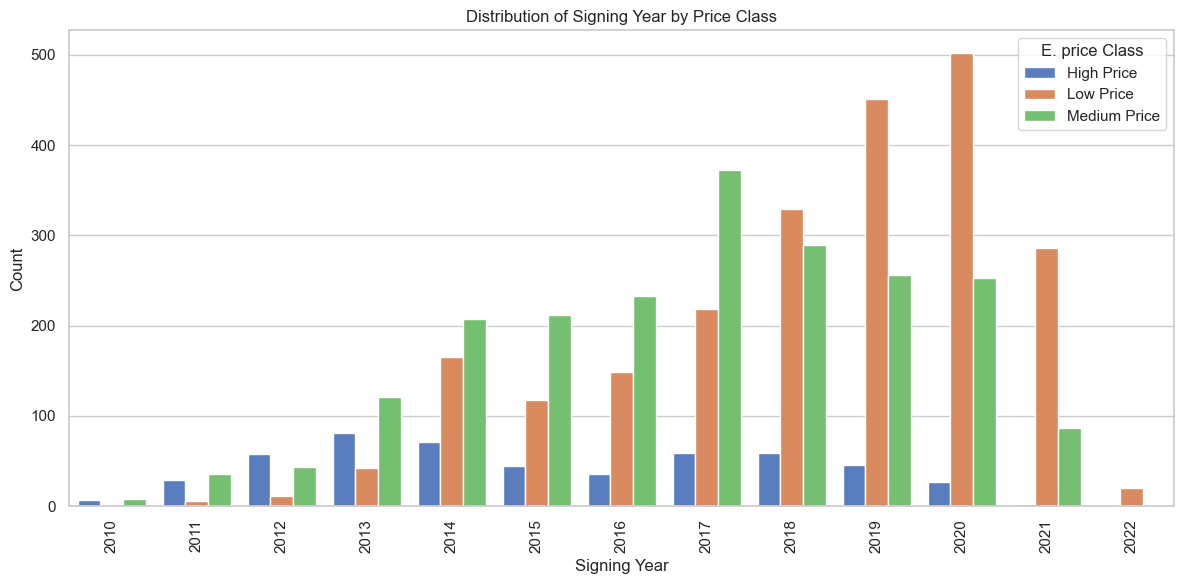

In [9]:
create_countplot(df, 'Signing Year', 'E. price Class', 'Distribution of Signing Year by Price Class')

From 2018 onwards, prices are lower

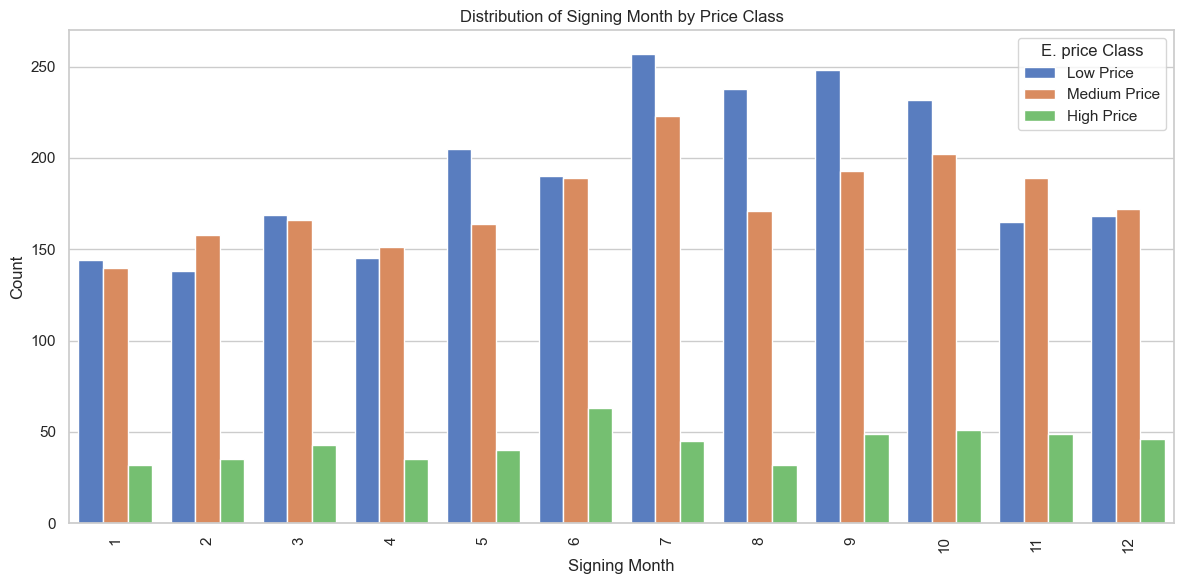

In [10]:
create_countplot(df, 'Signing Month', 'E. price Class', 'Distribution of Signing Month by Price Class')

For the months they all have somewhat the same distribution, with July having higher absolute values as already observed with previous analyses

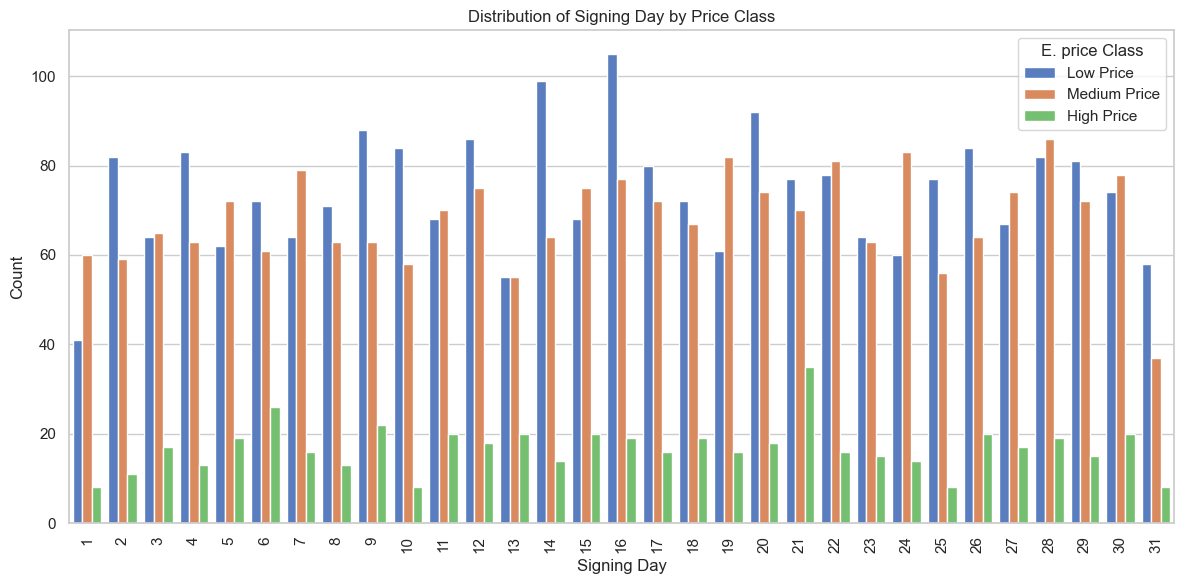

In [11]:
create_countplot(df, 'Signing Day', 'E. price Class', 'Distribution of Signing Day by Price Class')

Generally on the 21st of the month, contracts are priced higher

## Plot4: Effective price vs Closing Date Year

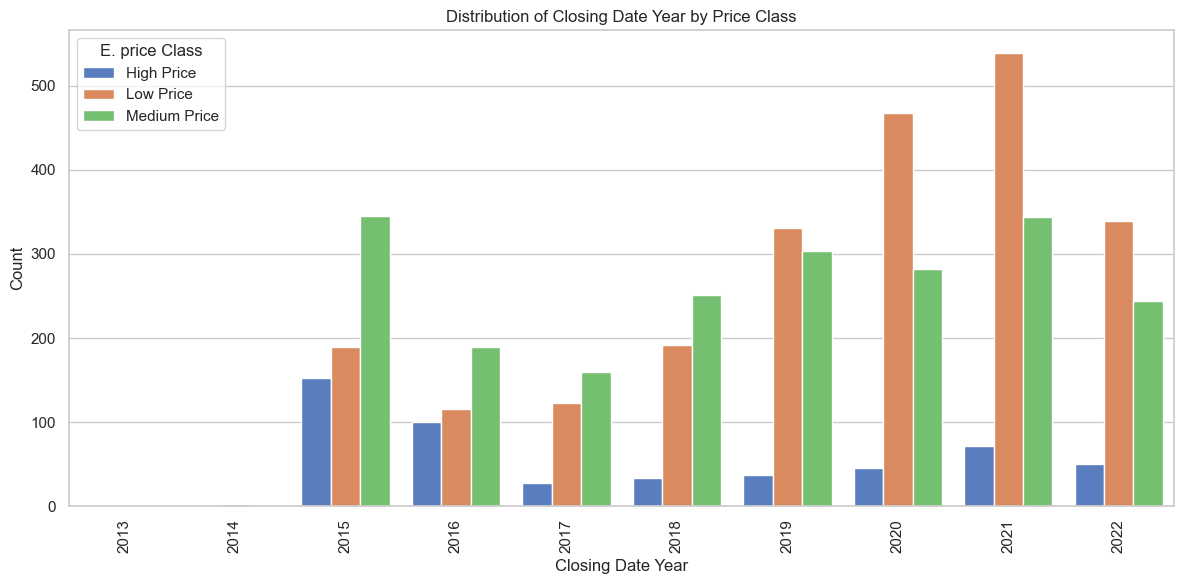

In [12]:
create_countplot(df, 'Closing Date Year', 'E. price Class', 'Distribution of Closing Date Year by Price Class')

The annual trend, starting in 2019, is also confirmed for Closing Date

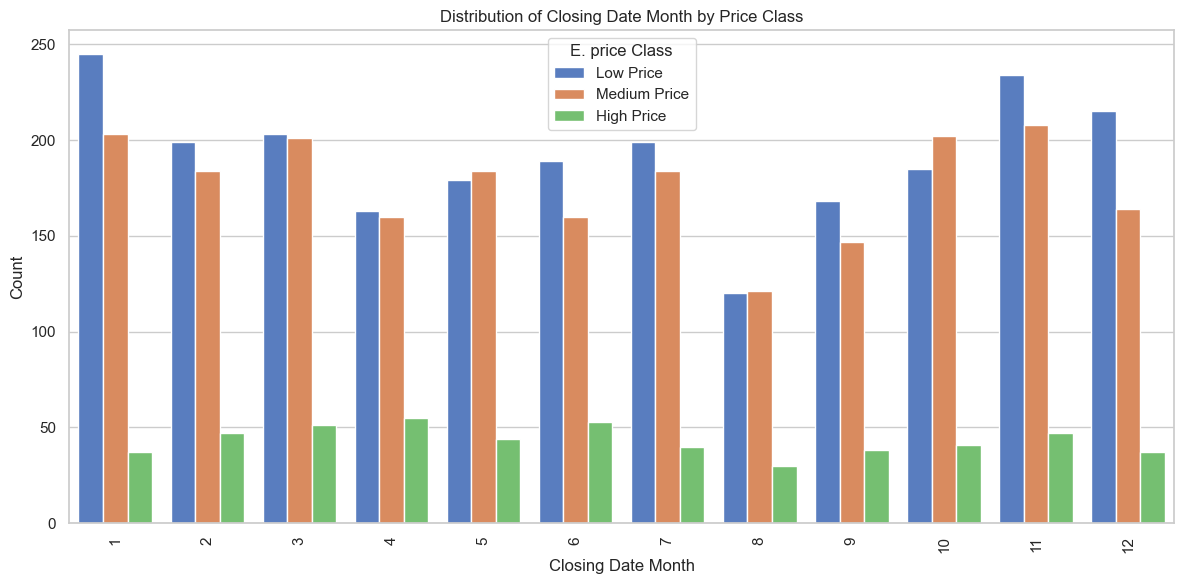

In [13]:
create_countplot(df, 'Closing Date Month', 'E. price Class', 'Distribution of Closing Date Month by Price Class')

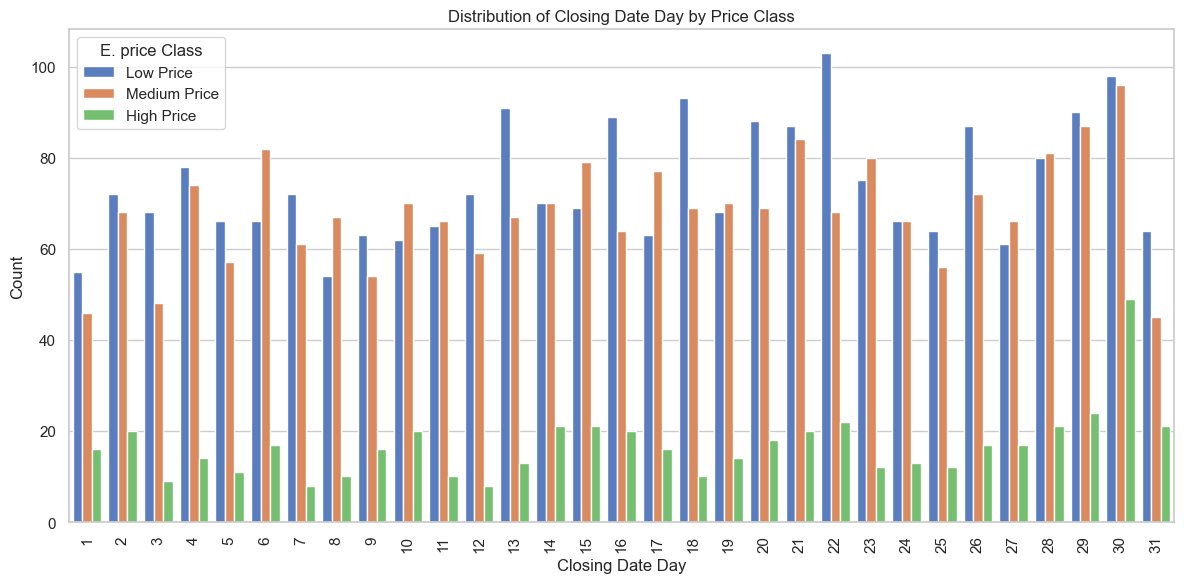

In [14]:
create_countplot(df, 'Closing Date Day', 'E. price Class', 'Distribution of Closing Date Day by Price Class')

Here, on the other hand, it is the 30th of the month that contracts cost more (perhaps because they end at the end of the month and are therefore longer?).

## Plot5: Effective price vs Submission deadline

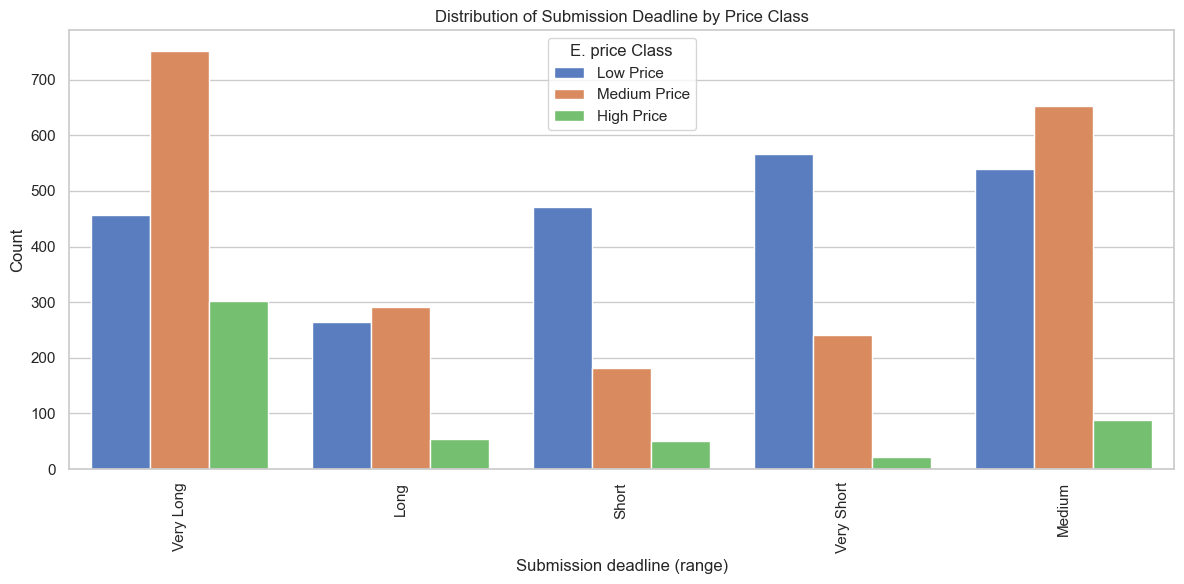

In [15]:
create_countplot(df, 'Submission deadline (range)', 'E. price Class', 'Distribution of Submission Deadline by Price Class')

The higher the submission time, the more expensive the contract, because it may require more detail and thus more effort.
The Long case has few instances of everything, the Very Long definitely prevails also because of the discretisation adopted.

## Plot6: Effective price vs Execution deadline (days)

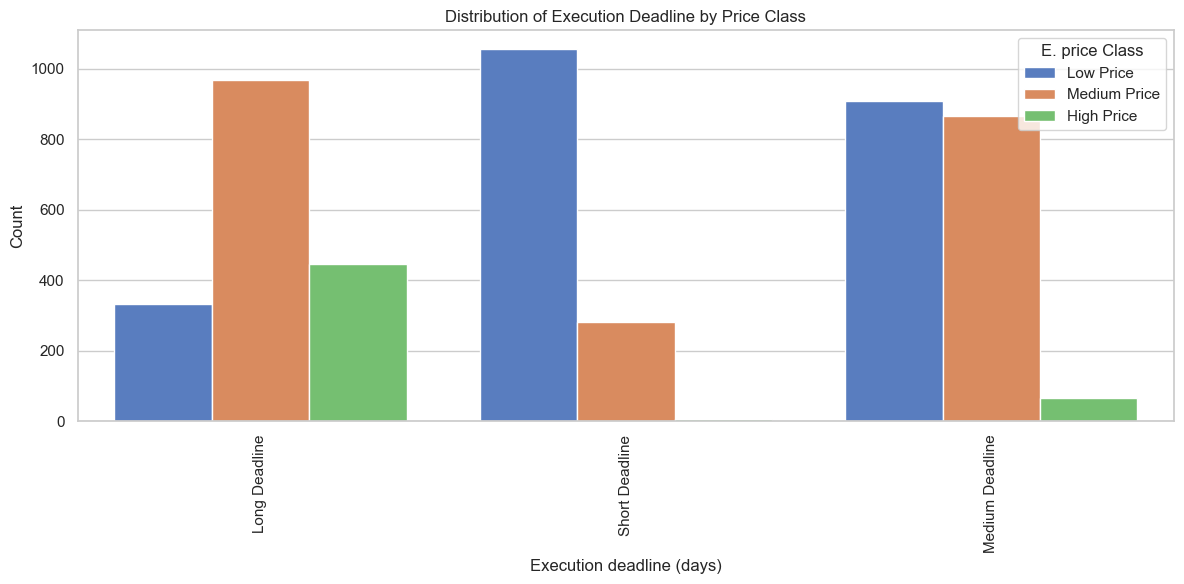

In [16]:
create_countplot(df, 'Execution deadline (days)', 'E. price Class', 'Distribution of Execution Deadline by Price Class')

In general, a higher price is assigned to contracts with a longer duration (which is also understandable since it would involve more effort and resources), whereas a lower price is assigned to contracts with a shorter duration. <br>
In fact, we can see that in the Short Deadline category, the high price is completely absent, while it reaches its peak in the Long Deadline category. <br>
The medium price also follows a similar growth pattern.

## Plot7: Effective price vs Diference between close and signing dates

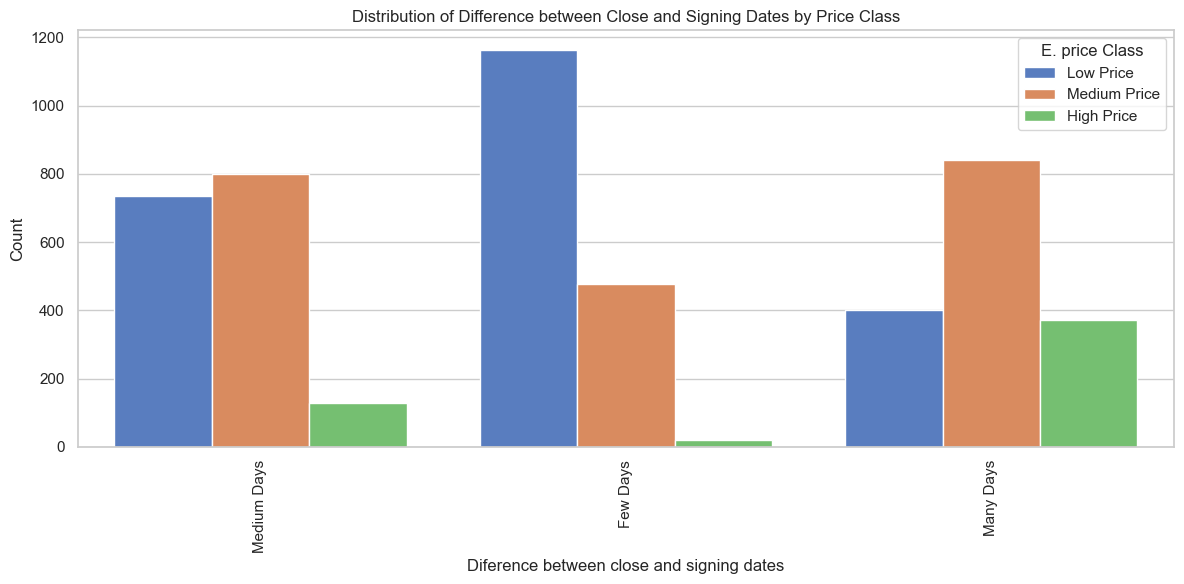

In [17]:
create_countplot(df, 'Diference between close and signing dates', 'E. price Class', 'Distribution of Difference between Close and Signing Dates by Price Class')

Here too, the contract amount increases for many days.

## Plot8: Effective price vs Number of bidders

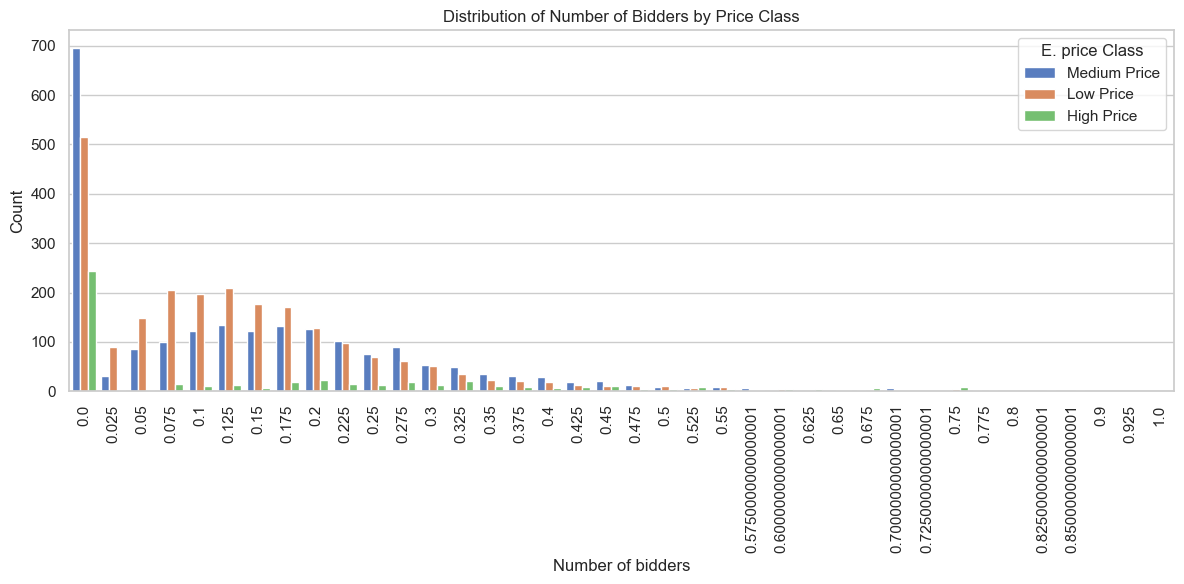

In [18]:
create_countplot(df, 'Number of bidders', 'E. price Class', 'Distribution of Number of Bidders by Price Class')

After this exploratory analysis first, we can proceed with the cluster analysis

## Plot9: Effective Price vs Base Bid Price

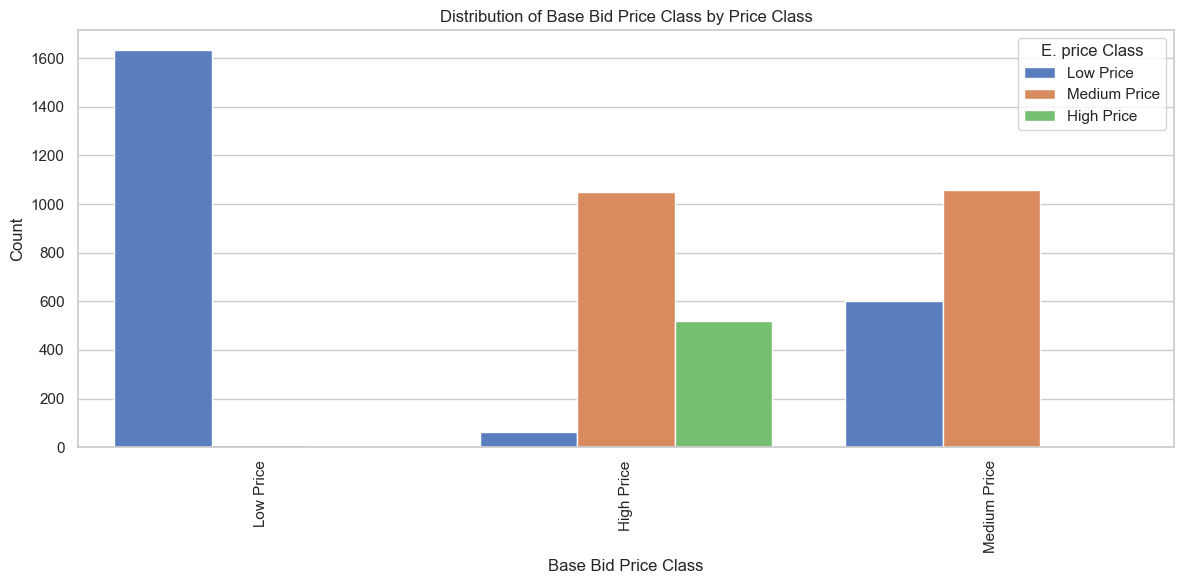

In [19]:
create_countplot(df, 'Base Bid Price Class', 'E. price Class', 'Distribution of Base Bid Price Class by Price Class')

There is indeed a correlation between effective price and base bid price

# Cluster Analysis

All the analyses carried out so far must be verified by applying a cluster analysis. <br>
I will start by using a small subset of features that I consider most suitable for the task. Then, I will apply a **sequential forward selection**, progressively increasing the number of variables to improve the cluster analysis. <br>
This process will continue until reaching a cut-off that indicates the optimal point for feature selection.

The objective of this analysis is to identify distinct patterns in public contracts using clustering techniques. <br>
The groupings I aim to explore are: <br>

1. **Contract Amounts**: Identifying clusters based on contract amounts (low, medium, and high-cost contracts). <br>
2. **Assignment Timeframes**: Analyzing differences in contract assignment times, distinguishing between those awarded quickly and those that take longer. <br>
3. **Region or Geographic Area**: Exploring geographic groupings based on the project execution location. <br>

## Selected Features for Clustering <br>

For now, I have chosen the following variables from the dataset to initiate the clustering process: <br>

- **Effective Price Class**: The final price class of the contract upon completion. <br>
- **Base Bid Price Class**: The initial price class of the contract. <br>
- **District**: The project execution district, useful for identifying geographical differences. <br>
- **Submission Deadline**: The deadline for bid submission, indicative of the speed of the assignment process. <br>
- **Difference between close and signing dates**: The difference between the closing date of the call for tenders and the contract signing, another indicator of assignment timeframes. <br>
- **Execution Deadline**: The estimated time for project execution, useful for analyzing project duration. <br>
- **Award Criteria Class**: The assignment criteria class (multi-factor or lowest price). <br>

I will start with these variables, but I may decide to remove some or add other dataset features based on the initial clustering results.

Since we are working with numerical data and have categorical features, I will convert the columns into numerical features using both OneHotEncoding (to preserve the class and thus the categorical feature that has no order relationship, such as District) and LabelEncoding to preserve the order relationship.

For the label encoder, I will pass a custom mapping to reflect the semantic meaning of the features.

In [20]:
columns_selected_onehot = ['District', 'Award criteria class']
columns_selected_label_encoded = ['E. price Class', 'Base Bid Price Class', 'Submission deadline (range)', 
                                  'Diference between close and signing dates','Execution deadline (days)']

df_selected_label_encoded = df[columns_selected_label_encoded]
df_selected_onehot = df[columns_selected_onehot]

# Label Encoding

# Custom mappings for the selected columns
custom_mappings = {
    'E. price Class': {'Low Price': 0, 'Medium Price': 1, 'High Price': 2},
    'Base Bid Price Class': {'Low Price': 0, 'Medium Price': 1, 'High Price': 2},
    'Submission deadline (range)': {'Very Short': 0, 'Short': 1, 'Medium': 2, 'Long': 3, 'Very Long': 4},
    'Diference between close and signing dates': {'Few Days': 0, 'Medium Days': 1, 'Many Days': 2},
    'Execution deadline (days)': {'Short Deadline': 0, 'Medium Deadline': 1, 'Long Deadline': 2}
}

# Apply the custom mappings
for col, mapping in custom_mappings.items():
    df_selected_label_encoded.loc[:, col] = df_selected_label_encoded[col].map(mapping)


# One-Hot Encoding
df_selected_onehot_encoded = pd.get_dummies(df_selected_onehot, columns=columns_selected_onehot)

# Combine the Label Encoded and One-Hot Encoded DataFrames
df_final = pd.concat([df_selected_label_encoded, df_selected_onehot_encoded], axis=1)

df_final.head()

E. price Class Base Bid Price Class Submission deadline (range)  \
0              0                    0                           4   
1              0                    0                           3   
2              0                    0                           3   
3              0                    0                           1   
4              0                    0                           1   

  Diference between close and signing dates Execution deadline (days)  \
0                                         1                         2   
1                                         1                         0   
2                                         0                         0   
3                                         1                         0   
4                                         0                         0   

   District_Aveiro  District_Beja  District_Braga  District_Bragança  \
0            False          False           False              False   
1            False          False           False              False   
2            False          False           False              False   
3            False          False           False              False   
4            False          False           False              False   

   District_Castelo Branco  ...  District_Região Autónoma dos Açores  \
0                    False  ...                                False   
1                    False  ...                                False   
2                    False  ...                                False   
3                    False  ...                                False   
4                    False  ...                                False   

   District_Santarém  District_Setúbal  District_Viana do Castelo  \
0              False              True                      False   
1              False             False                      False   
2              False             False                      False   
3              False             False                      False   
4              False             False                      False   

   District_Vila Real  District_Viseu  District_Évora  Award criteria class_0  \
0               False           False           False                   False   
1               False            True           False                   False   
2               False           False           False                    True   
3               False            True           False                   False   
4               False            True           False                   False   

   Award criteria class_1  Award criteria class_2  
0                   False                    True  
1                   False                    True  
2                   False                   False  
3                   False                    True  
4                   False                    True  

[5 rows x 28 columns]

In [21]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4937 entries, 0 to 4936
Data columns (total 28 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   E. price Class                             4937 non-null   object
 1   Base Bid Price Class                       4937 non-null   object
 2   Submission deadline (range)                4937 non-null   object
 3   Diference between close and signing dates  4937 non-null   object
 4   Execution deadline (days)                  4937 non-null   object
 5   District_Aveiro                            4937 non-null   bool  
 6   District_Beja                              4937 non-null   bool  
 7   District_Braga                             4937 non-null   bool  
 8   District_Bragança                          4937 non-null   bool  
 9   District_Castelo Branco                    4937 non-null   bool  
 10  District_Coimbra                    

## 1 Approach: K-MEANS

K-Means is a clustering algorithm that partitions a dataset into **K clusters**, where K is a predefined number. The algorithm operates through the following steps:

1. **Initialization**: Randomly select K points from the data as the initial centroids of the clusters.
2. **Assignment**: Each point in the dataset is assigned to the cluster whose centroid is closest, typically by calculating the Euclidean distance.
3. **Update**: The centroids are recalculated as the average of the points assigned to each cluster.
4. **Iteration**: The assignment and update steps are repeated until the centroids no longer change significantly, or a maximum number of iterations is reached.

Although the algorithm is simple and fast, it requires specifying the number of clusters K before execution, which can be problematic when the ideal number of clusters is unknown in advance.

### Elbow Method

The **Elbow Method** is a technique for determining the optimal number of clusters K in K-Means. The procedure involves:

1. Running K-Means for various values of K (e.g., from 1 to 10).
2. Calculating the **SSE (Sum of Squared Errors)**, defined as the sum of the squared distances between the points and their centroids within each cluster:

   $$
   \text{SSE} = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2
   $$

   where:
   - $k$ is the number of clusters,
   - $C_i$ is the **i**-th cluster,
   - $x$ is a data point in cluster $C_i$,
   - $\mu_i$ is the centroid of cluster $C_i$.

3. Plotting a graph of SSE against K.

The "elbow" in the graph indicates the point where increasing the number of clusters no longer significantly improves the SSE, suggesting the optimal number of clusters as a good balance between the quantity and quality of the clustering. A lower inertia (i.e., a lower SSE) indicates more compact and well-separated clusters, while a higher inertia suggests greater dispersion within the clusters.

In [22]:
# Initialize the clustering pipeline with the KMeans model
kmeans_model = KMeans()

# Create the clustering pipeline
pipeline = ClusterPipeline(clustering_model=kmeans_model)

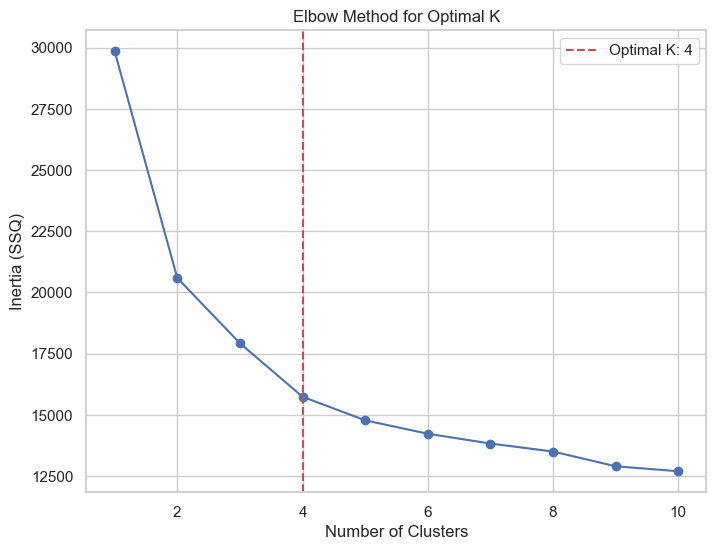

Optimal number of clusters: 4


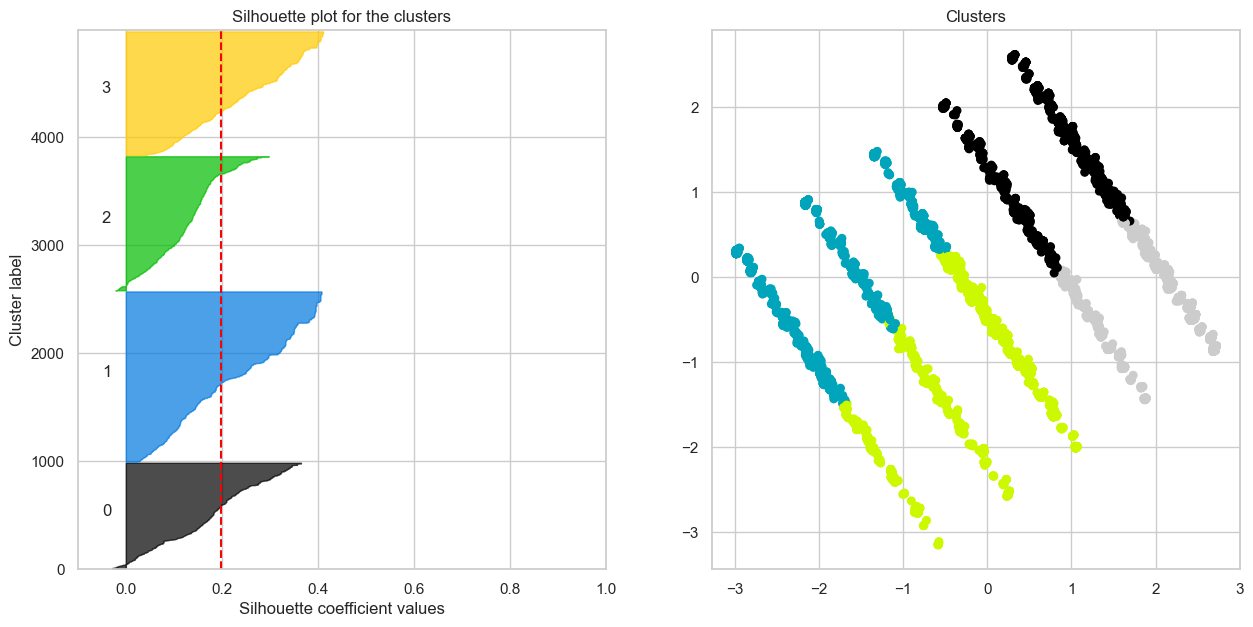

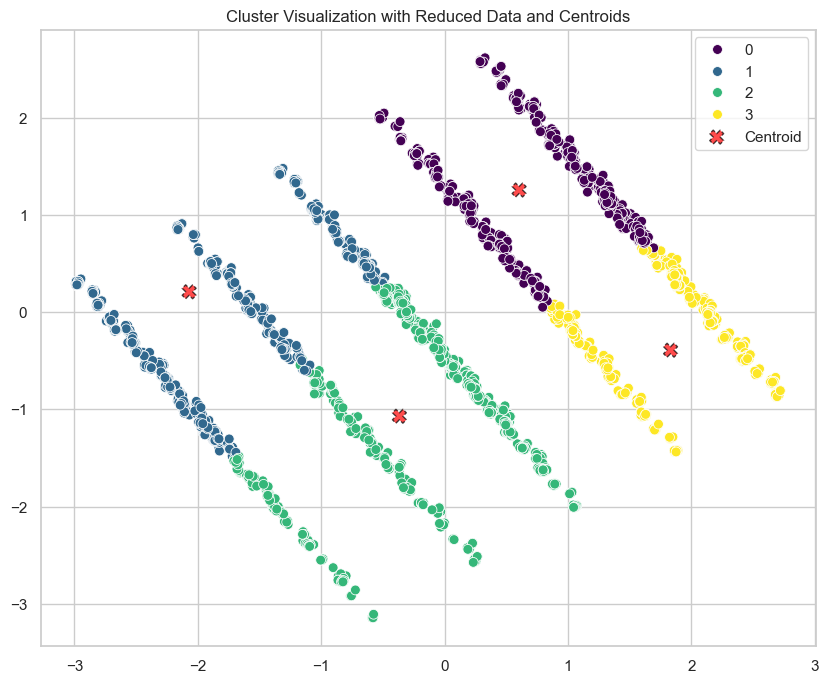

Silhouette Score: 0.19763447300921708
Dumn Index: 1490.4117634482363
SSQ (Sum of Squared Distances): 15739.959580368759


In [23]:
# Run the clustering pipeline
df_metrics = pipeline.run(df_final, max_clusters=10)

It seems that the way K-Means has been set up and the optimal choice of K is not particularly suitable for the type of data we have. In fact, just looking at the graphs, it's clear that the separation is incorrect and even the centroids calculated are not accurate.

However, the clusters are well distinct in the space, which makes this a great baseline to improve upon.

As a first step, I would try changing the method for selecting the parameter K by using the silhouette score directly.

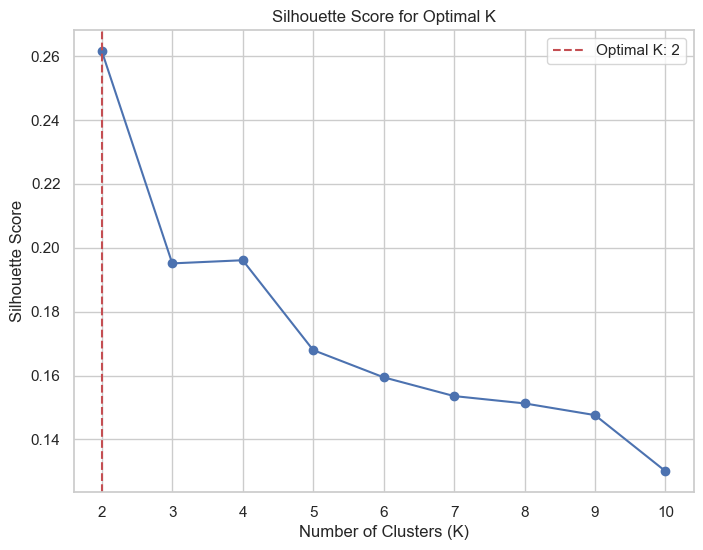

Optimal number of clusters: 2


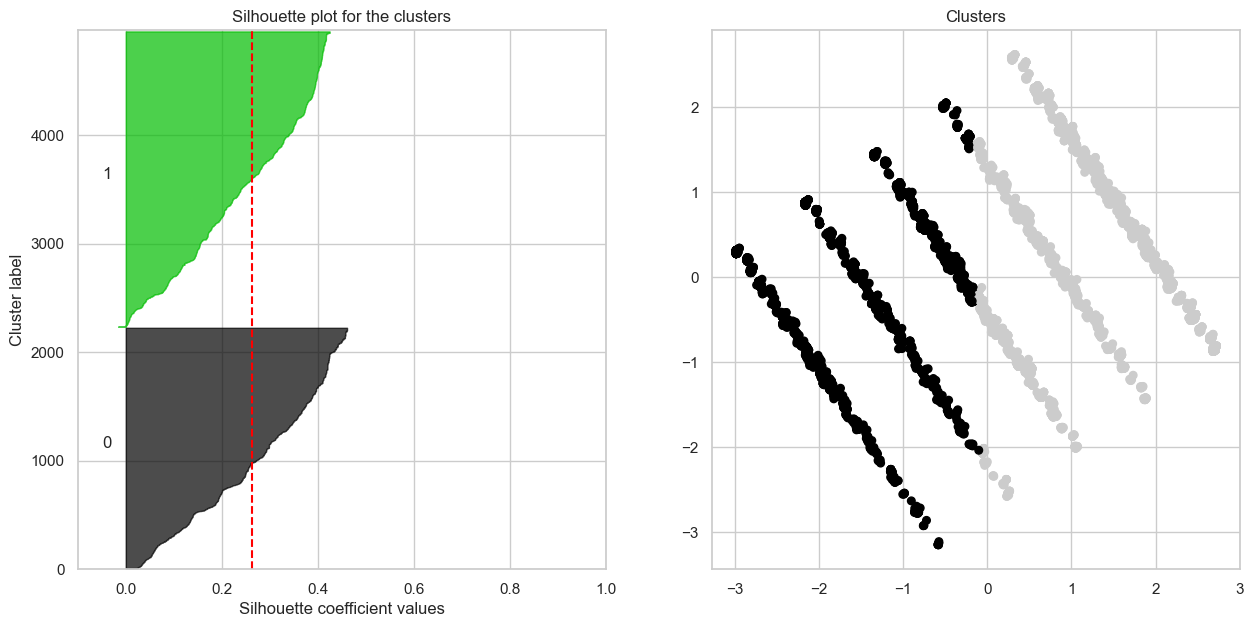

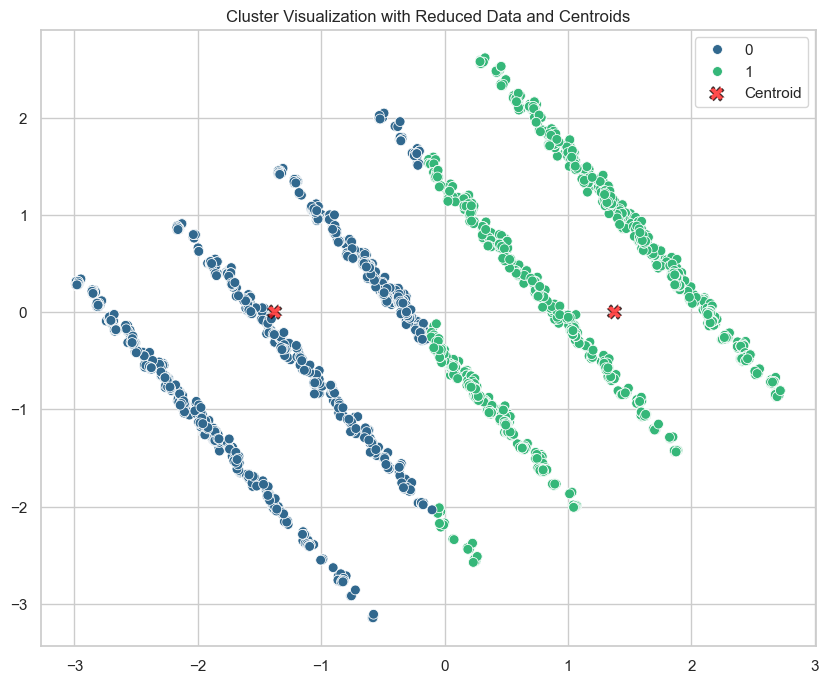

Silhouette Score: 0.26174920676805125
Dumn Index: 3738.317160127137
SSQ (Sum of Squared Distances): 20591.90531791318


In [24]:
df_metrics = pipeline.run(df_final, max_clusters=10, method='silhouette', threshold=0.15)

The Silhouette Score has increased, and even graphically, it seems that improvements have been made. In fact, the areas of overlap have decreased, but it is still not possible to properly separate the data points into well-distinguished clusters.

> Indeed, distance-based measures, such as the Silhouette coefficient, do not work well for arbitrarily shaped clusters. In the case of the Silhouette coefficient, the specific coefficients of certain points may have a negative impact even in the case of correct clustering, causing the global coefficient to not be as high as in the case of an incorrect K-Means clustering.

To better visualize the distribution of the clusters, it's possible that PCA may not capture the complex properties of the cluster structure.

Therefore, I will try using more advanced dimensionality reduction and visualization techniques, such as t-SNE, which is capable of considering non-linear relationships between the data.

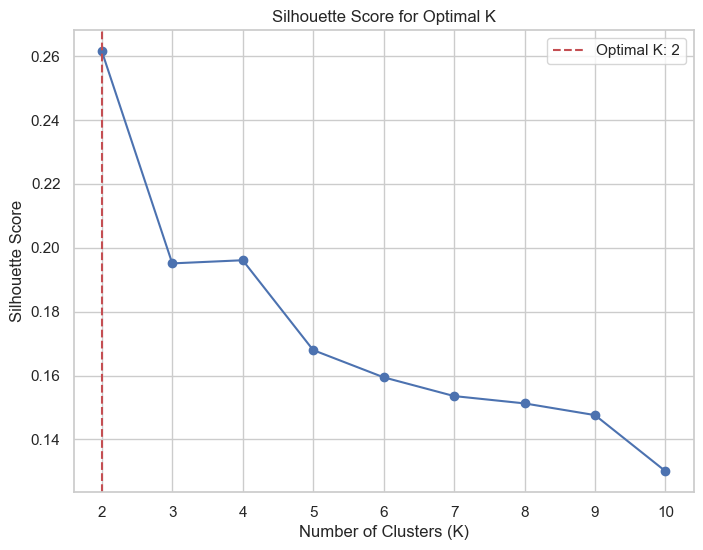

Optimal number of clusters: 2


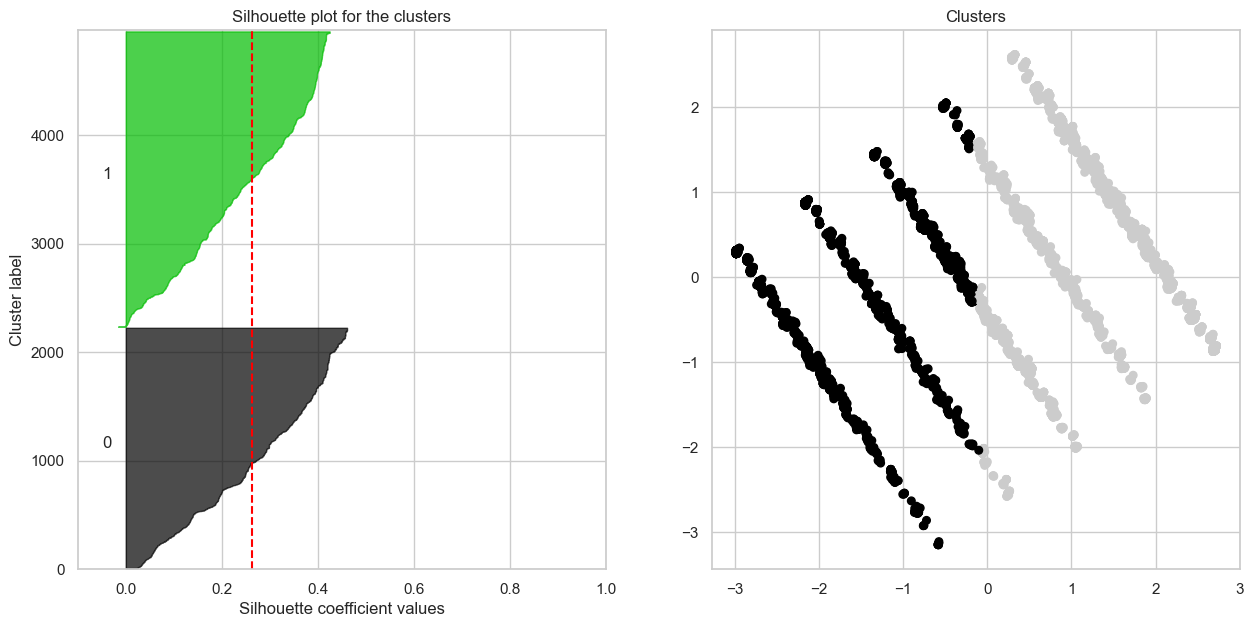

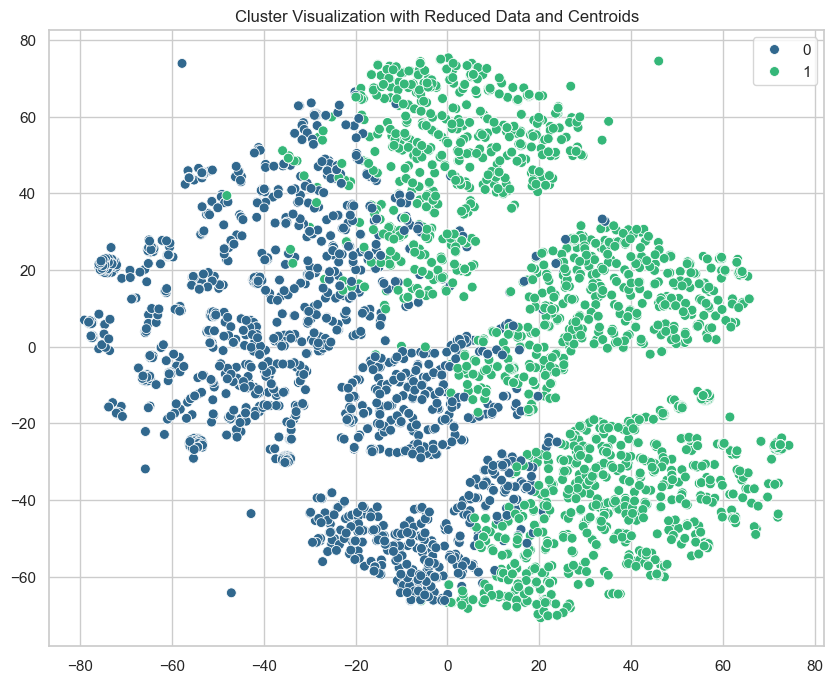

Silhouette Score: 0.26174920676805125
Dumn Index: 3738.3171601271383
SSQ (Sum of Squared Distances): 20591.90531791318


In [25]:
df_metrics = pipeline.run(df_final, max_clusters=10, method='silhouette', threshold=0.15, 
                        dim_reduction_method=TSNE(n_components=2, random_state=42, perplexity=30))

By adopting t-SNE, we confirm that the issue lies in the K-Means algorithm, which is unable to properly separate the clusters.

There are overlapping clusters, and the structure is more complex to be effectively managed by K-Means.

The idea is to use hierarchical clustering algorithms, but first, I will test the K-Medoids algorithm to see if changing the method of selecting the data points makes any difference.

## 2 Approach: Agglomerative Clustering

Agglomerative Clustering is a hierarchical clustering technique that starts by treating each data point as a single cluster. Then, clusters are successively merged based on a distance measure until a single cluster containing all data points is formed. This approach is particularly useful for identifying hierarchical structures in the data and can reveal natural relationships between the points.

**Linkage Parameters**

The `linkage` parameter defines the criterion used to calculate the distance between clusters. There are several options for this parameter:

- **Ward**: Minimizes the sum of squared variances within the clusters. This option tends to produce clusters of similar sizes and is useful when the data follows a normal distribution (so we would expect to often find this linkage when using metrics like Manhattan and Euclidean).
- **Complete**: The distance between two clusters is defined as the maximum distance between points in the two clusters. This option tends to produce more distinct and separated clusters.
- **Average**: The distance between two clusters is the average of the distances between all points in the two clusters. This option offers a compromise between `Ward` and `Complete`.
- **Single**: The distance between two clusters is defined as the minimum distance between points in the two clusters. This method can lead to more elongated and irregularly shaped clusters.

**Distance Parameters**

1. **Manhattan Distance** (or L1 Distance):
   - **Formula**: The distance between two points $p$ and $q$ is calculated as:
     $$
     d(p, q) = \sum_{i=1}^{n} |p_i - q_i|
     $$
   - **Description**: This measure only considers movement along the axes, as if moving on a grid. It is less sensitive to outliers than Euclidean distance.
   - **Pro**: Less affected by outliers, making it more robust for datasets with extreme values.
   - **Con**: Does not account for the "real" geometry of the data, so it may not be suitable for high-dimensional spaces.

2. **Euclidean Distance** (or L2 Distance):
   - **Formula**: The distance between two points $p$ and $q$ is calculated as:
     $$
     d(p, q) = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2}
     $$
   - **Description**: This measure represents the shortest "linear" distance between two points in space. It is the most common and intuitive distance measure.
   - **Pro**: Represents the real distance between points in Euclidean space; useful for most clustering applications.
   - **Con**: Sensitive to outliers, which can significantly affect the results; may be problematic in high-dimensional spaces.

3. **Cosine Distance**:
   - **Formula**: The cosine distance between two vectors $A$ and $B$ is calculated as:
     $$
     d(A, B) = 1 - \frac{A \cdot B}{\|A\| \|B\|}
     $$
   - **Description**: This measure is based on the angle between two vectors and is often used in high-dimensional spaces, such as in text mining. Cosine distance is useful when you want to assess similarity rather than absolute difference.
   - **Pro**: Useful for high-dimensional data; highlights similarity even with different magnitudes.
   - **Con**: Ignores the magnitude of the vectors, so it may not be suitable for data where the dimension is important.

**Grid Search**

Since Agglomerative Clustering not only changes the distance function of the data points but also the distance function between clusters, it's advisable to perform a **grid search** to find the optimal parameter configuration. This process involves systematically exploring a set of parameter combinations (such as the `linkage` method and distance metric) to identify the configuration that maximizes model performance, such as the Silhouette Score. By using grid search, we can ensure that the chosen clustering model is the best fit for the data under examination.

In [26]:
best_score, best_params = hierarchical_clustering_with_silhouette(df_final, ['ward', 'complete', 'average', 'single'], min_clusters=2, max_clusters=2, min_points_in_cluster=100, metrics=['euclidean', 'manhattan'])
print(f"Best Score: {best_score}, Best Params: {best_params}")

Clusters: 2, Linkage: ward, Metric: euclidean, Score: 0.239, Sizes: [2757, 2180]
Clusters: 2, Linkage: complete, Metric: euclidean, Score: 0.233, Sizes: [2729, 2208]
Clusters: 2, Linkage: complete, Metric: manhattan, Score: 0.161, Sizes: [3099, 1838]
Clusters: 2, Linkage: average, Metric: euclidean, Score: 0.229, Sizes: [2979, 1958]
Clusters: 2, Linkage: average, Metric: manhattan, Score: 0.233, Sizes: [3299, 1638]
Best Score: 0.23919124907742634, Best Params: (2, 'ward', 'euclidean', array([0, 1, 0, ..., 0, 0, 0], dtype=int64))


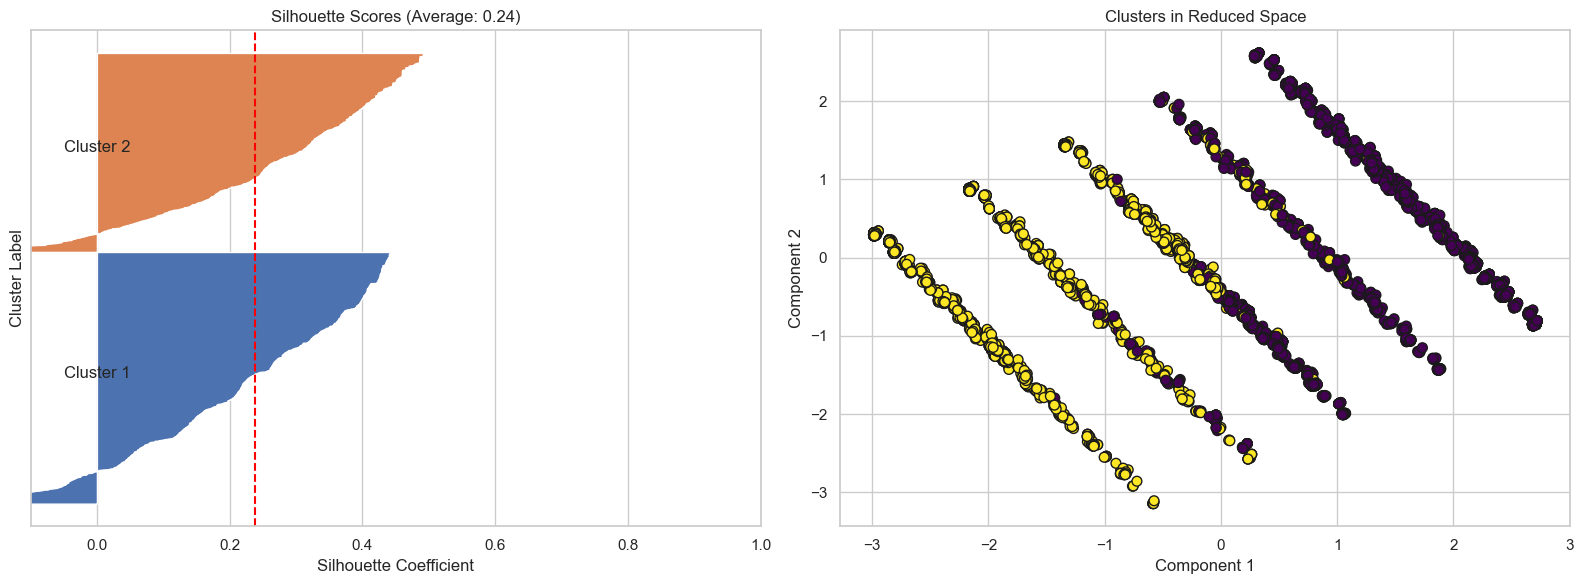

In [27]:
plot_silhouette_and_clusters(df_final, best_params, metric='manhattan', clustering_algorithm=AgglomerativeClustering)

Observing the graph, it is clear that the separation found by the hierarchical algorithm is similar to the one obtained with K-Means, with very similar silhouette scores. This suggests that the cluster separation has been performed correctly even with simpler algorithms. However, some data points have not been disambiguated properly, negatively influencing the other clusters and causing the silhouette coefficient to drop.

To address this issue, the following solutions can be considered:

1. **Density-Based Algorithms**: Using algorithms like DBSCAN, which are designed to isolate noisy points, can help improve the quality of clustering.
2. **Reducing Feature Cardinality**: Decreasing the number of features can reduce dimensionality and facilitate better cluster separation.
3. **Similarity Metrics**: If preserving high dimensionality is important, it would be beneficial to consider metrics like cosine similarity. These metrics emphasize features with similar values rather than penalizing those with dissimilar values, improving the quality of the clustering.

These strategies can help improve the quality and interpretability of the resulting clusters.

I try cosine similarity, then enhancing the features that have similar values

Clusters: 2, Linkage: complete, Metric: cosine, Score: 0.457, Sizes: [1047, 3890]
Clusters: 3, Linkage: complete, Metric: cosine, Score: 0.397, Sizes: [743, 3890, 304]
Best Score: 0.45673532863043587, Best Params: (2, 'complete', 'cosine', array([1, 1, 1, ..., 1, 1, 1], dtype=int64))


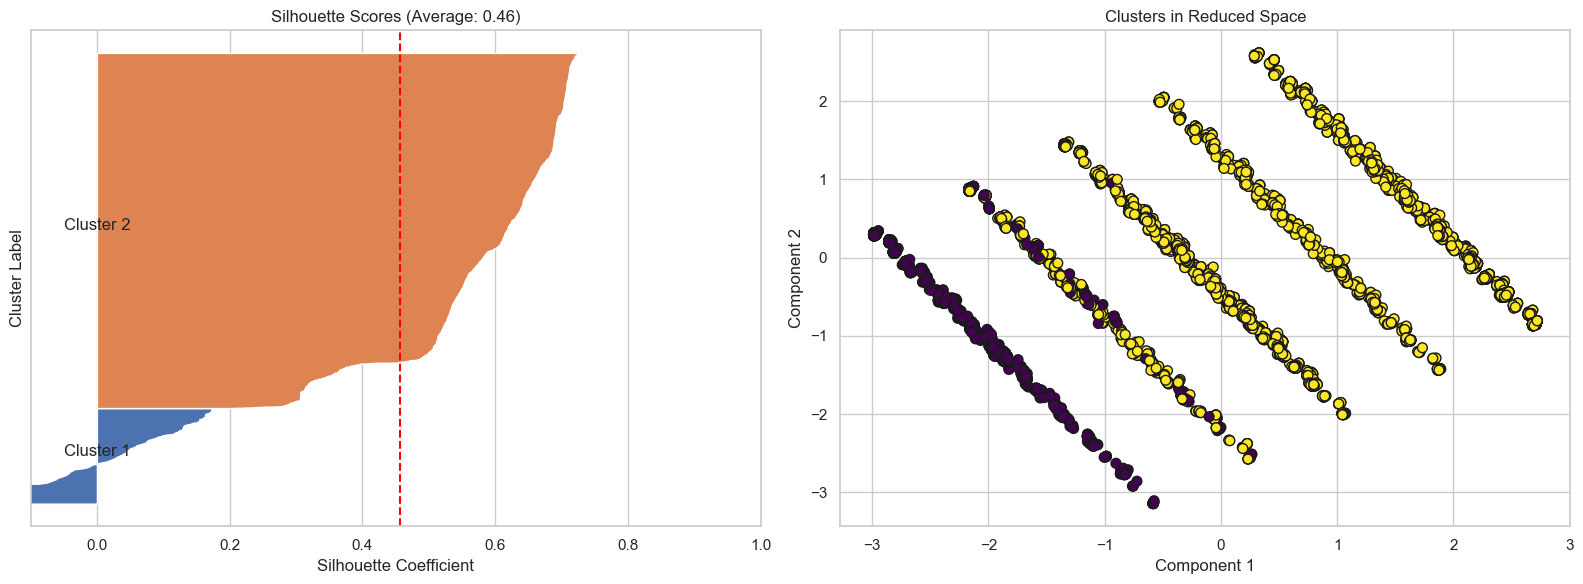

In [28]:
best_score, best_params = hierarchical_clustering_with_silhouette(df_final, ['complete', 'average', 'single'], min_clusters=2, max_clusters=5, min_points_in_cluster=300, metrics=['cosine'])
print(f"Best Score: {best_score}, Best Params: {best_params}")
plot_silhouette_and_clusters(df_final, best_params, metric='cosine', clustering_algorithm=AgglomerativeClustering)

In [29]:
df_submitted = df.copy()
df_submitted['ClusterAgglomerativeCosine'] = best_params[3].tolist()

Using cosine similarity, as can be seen, there is an improvement in both the silhouette score and visually in the graph, where we notice a good separation of the clusters. However, in the silhouette score calculation, cluster 1 is misclassified, as can also be observed in the graph. Nevertheless, this represents a significant improvement compared to before.

Let's see if this result can be further improved, but for now, it serves as our new baseline.

## 3 Approach: DBSCAN

Since the previous approaches have not yielded promising results, we will explore density-based algorithms like **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**. Additionally, we will use cosine similarity to emphasize similar data present in the features.

This strategy allows us to set a metric and perform a grid search on the `eps` and `min_samples` parameters, limiting the computational load without compromising the quality of the results.

1. **`eps` (epsilon)**:
   - Represents the maximum distance between two points for them to be considered part of the same cluster. In other words, it is the radius of the "searcher" around a point. If the distance between two points is less than `eps`, those points can be considered close and therefore belong to the same cluster. A value that is too low can lead to many small clusters, while a value that is too high may merge distinct clusters.

2. **`min_samples`**:
   - Indicates the minimum number of points required to form a cluster. If a point has at least `min_samples` points within its `eps` radius, it is considered a "core" point and contributes to the formation of a cluster. Points that do not meet this requirement are considered "noisy" or "outliers." The higher the value of `min_samples`, the more robust the clustering will be, but there is a risk of losing smaller clusters.

It is important to note that, especially for the `eps` value, it will never be possible to find the absolute best value. Therefore, we will adopt a greedy search approach based on the provided parameters, aiming to optimize the algorithm's performance.

eps=0.05, min_samples=1, metric=cosine: Not enough points in clusters.
eps=0.05, min_samples=2, metric=cosine: Not enough points in clusters.
eps=0.05, min_samples=3, metric=cosine: Not enough points in clusters.
eps=0.05, min_samples=4, metric=cosine: Not enough points in clusters.
eps=0.05, min_samples=5, metric=cosine, score=-0.121, outliers=880, clusters=64
eps=0.05, min_samples=6, metric=cosine: Too many outliers or not enough clusters.
eps=0.05, min_samples=7, metric=cosine: Too many outliers or not enough clusters.
eps=0.05, min_samples=8, metric=cosine: Too many outliers or not enough clusters.
eps=0.05, min_samples=9, metric=cosine: Too many outliers or not enough clusters.
eps=0.05, min_samples=10, metric=cosine: Too many outliers or not enough clusters.
eps=0.05, min_samples=11, metric=cosine: Too many outliers or not enough clusters.
eps=0.05, min_samples=12, metric=cosine: Too many outliers or not enough clusters.
eps=0.05, min_samples=13, metric=cosine: Too many outliers 

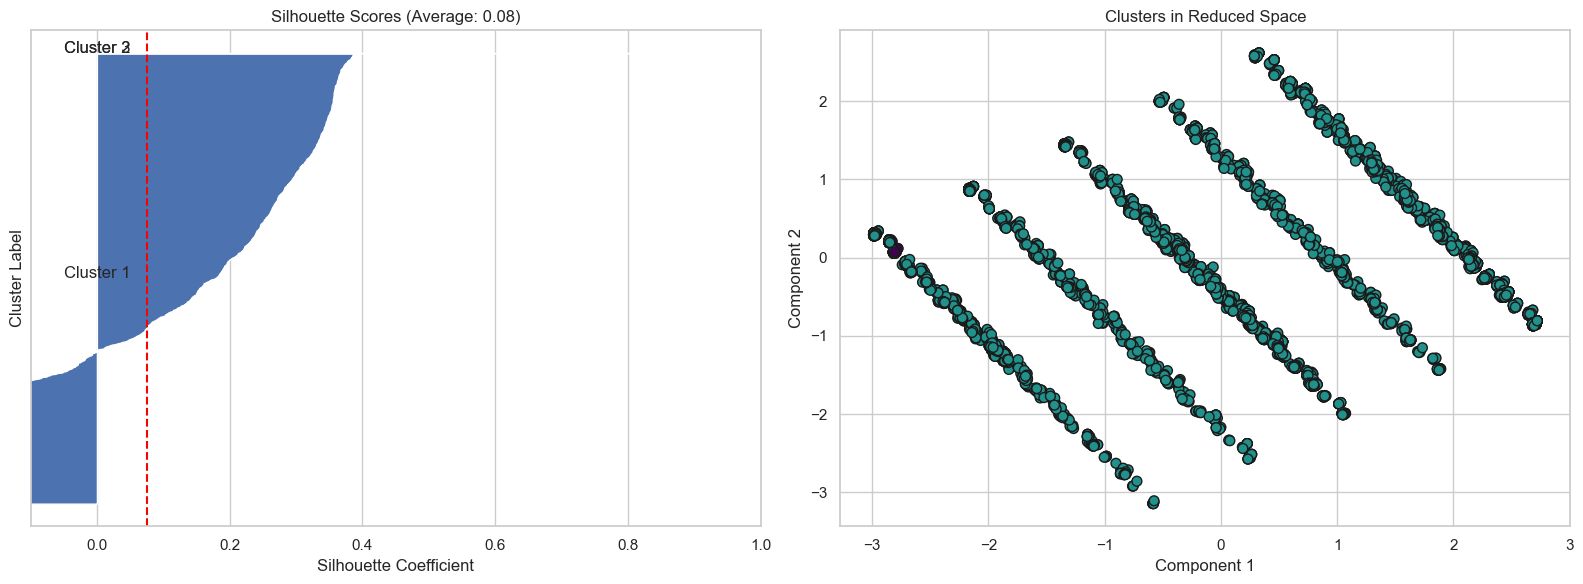

In [30]:
eps_values = np.arange(0.05, 4.0, 0.01)
min_samples_values = range(1, 20)
best_score, best_params = dbscan_with_silhouette(df_final, eps_values, min_samples_values, min_points_in_cluster=5, max_outlier_percentage=0.2, metrics=['cosine'], tollerance=100)
print(f"Best Score: {best_score}, Best Params: {best_params}")
plot_silhouette_and_clusters(df_final, best_params, metric='euclidean', clustering_algorithm=DBSCAN)

The issue encountered is that the clusters are severely disproportionate, even after trying various configurations of the DBSCAN algorithm. This disproportion can compromise the effectiveness of clustering and make it difficult to interpret the results.

Therefore, I will consider the possibility of **reducing the dimensionality of the dataset**. Dimensionality reduction can help simplify the structure of the data, allowing for better configuration and more effective cluster separation. By using techniques such as PCA or UMAP, the goal is to obtain more homogeneous and relevant representations of the data, thus facilitating the identification of natural groupings.

## 4 Approach: Dimensionality Reduction with Clustering + Random Forest

### Approach: K-Means + Random Forest

I used K-Means to cluster the data, aiming to uncover hidden structures without a defined target variable. The labels generated by the clusters were then used as the target variable to train a Random Forest model.

This approach allows us to identify relationships between variables and evaluate the importance of each feature in determining the clusters. Random Forest is particularly useful as it handles non-linear interactions well and provides insights into the most significant variables, helping to reduce noise in the data and improve the interpretability of the analysis.

With this approach, I aim to extract only the most relevant features by setting a threshold, enabling me to fit the most suitable K-Means model. Essentially, this is like using a **Wrapper Model**.

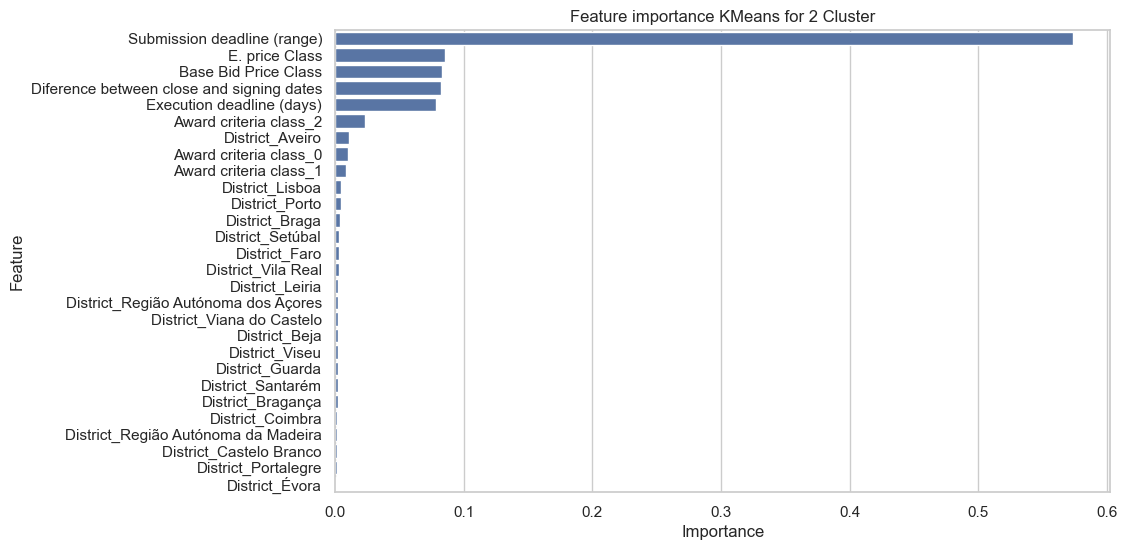

Relevant Features: ['Submission deadline (range)', 'E. price Class', 'Base Bid Price Class', 'Diference between close and signing dates', 'Execution deadline (days)', 'Award criteria class_2', 'District_Aveiro', 'Award criteria class_0', 'Award criteria class_1']


In [31]:
kmeans_2 = KMeans(n_clusters=2, random_state=42)
rf_model = RandomForestClassifier(random_state=42, n_estimators=200)

df_relevant_2 = clustering_random_forest(df_final, kmeans_2, rf_model, n_clusters=2, importance_threshold=0.005)
print(f"Relevant Features: {df_relevant_2.columns.tolist()}")

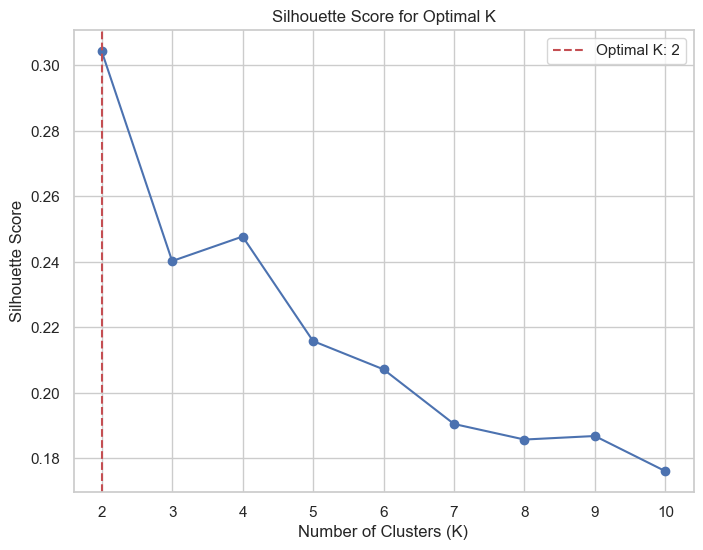

Optimal number of clusters: 2


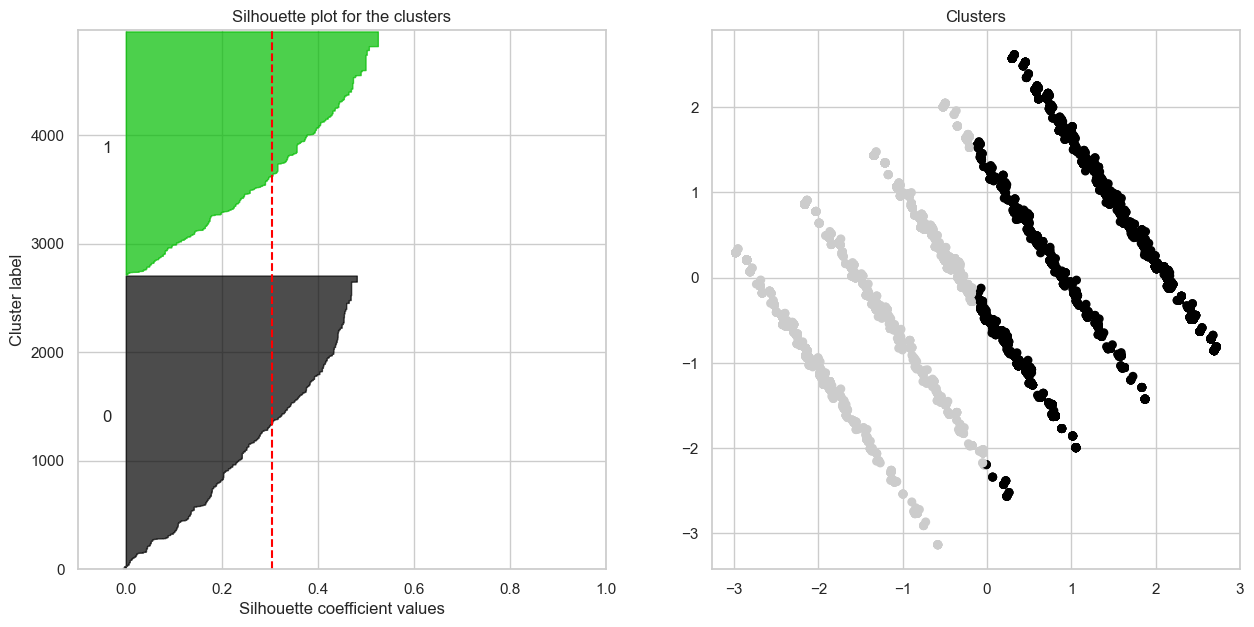

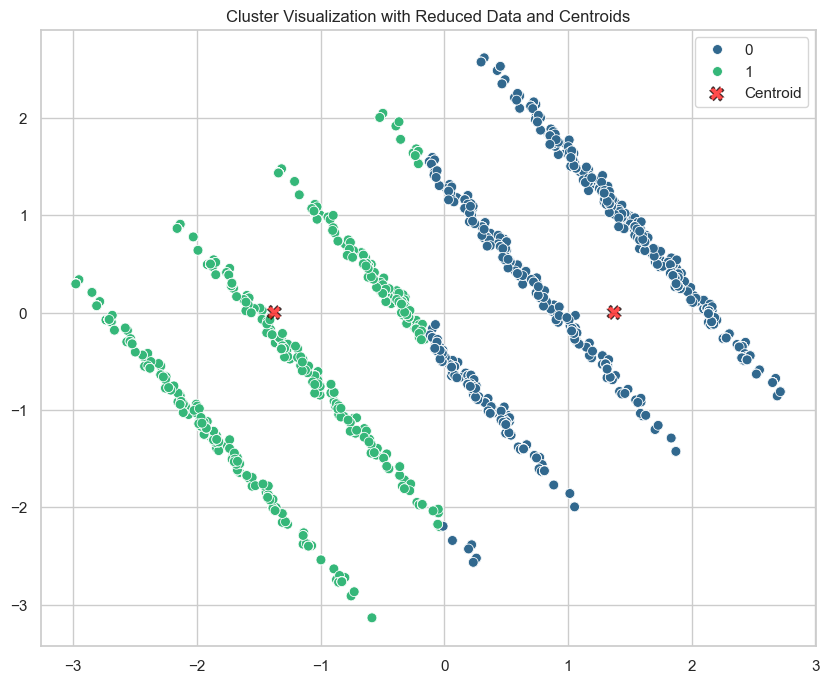

Silhouette Score: 0.30434376893844833
Dumn Index: 2998.495133559996
SSQ (Sum of Squared Distances): 16488.04741428841


In [32]:
kmeans_model = KMeans()
pipeline = ClusterPipeline(clustering_model=kmeans_model)
df_metrics = pipeline.run(df_relevant_2, max_clusters=10, method='silhouette', threshold=0.15)

We actually had a slight improvement over before

Clusters: 2, Linkage: ward, Metric: euclidean, Score: 0.249, Sizes: [3805, 1132]
Clusters: 2, Linkage: complete, Metric: euclidean, Score: 0.244, Sizes: [2715, 2222]
Clusters: 2, Linkage: complete, Metric: manhattan, Score: 0.248, Sizes: [3337, 1600]
Clusters: 2, Linkage: average, Metric: euclidean, Score: 0.278, Sizes: [2948, 1989]
Clusters: 2, Linkage: average, Metric: manhattan, Score: 0.312, Sizes: [2599, 2338]
Best Score: 0.3119823631923718, Best Params: (2, 'average', 'manhattan', array([0, 0, 0, ..., 1, 1, 1], dtype=int64))


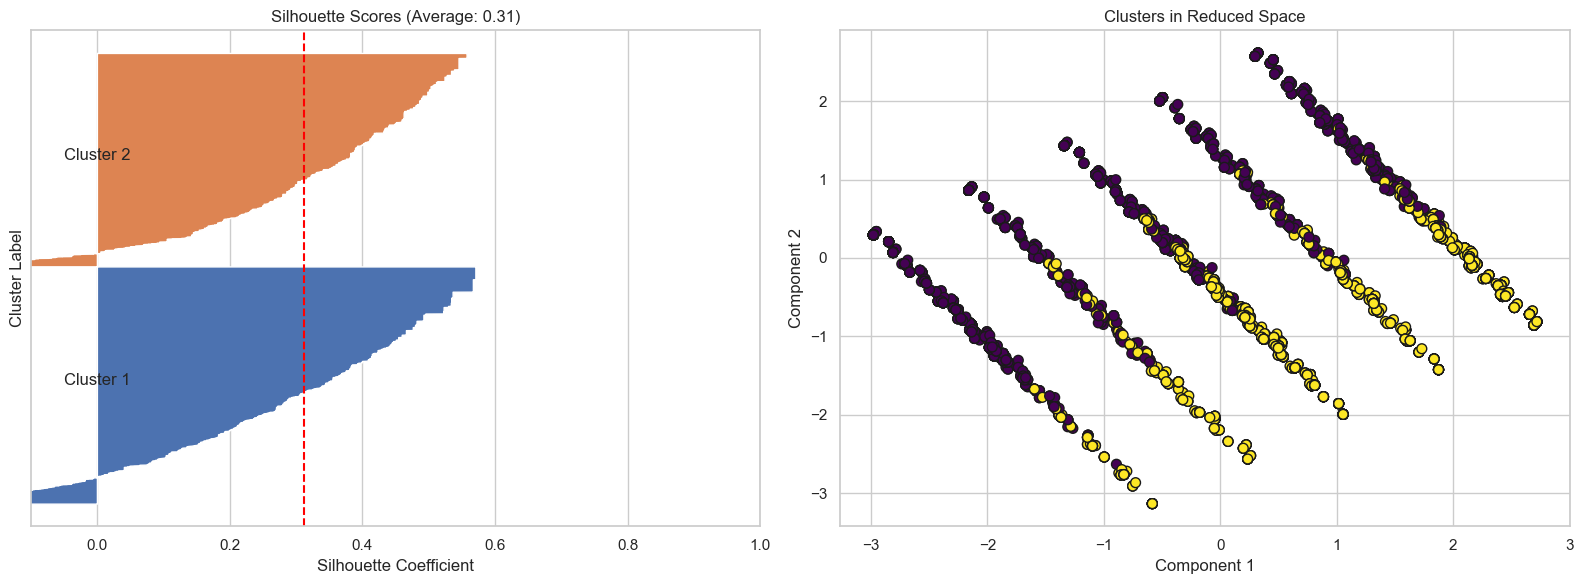

In [33]:
best_score, best_params = hierarchical_clustering_with_silhouette(df_relevant_2, ['ward', 'complete', 'average', 'single'], min_clusters=2, max_clusters=2, min_points_in_cluster=100, metrics=['euclidean', 'manhattan'])
print(f"Best Score: {best_score}, Best Params: {best_params}")
plot_silhouette_and_clusters(df_relevant_2, best_params, metric='manhattan', clustering_algorithm=AgglomerativeClustering)

Slightly better here too, but we did not achieve great improvements

### Agglomerative + Random Forest

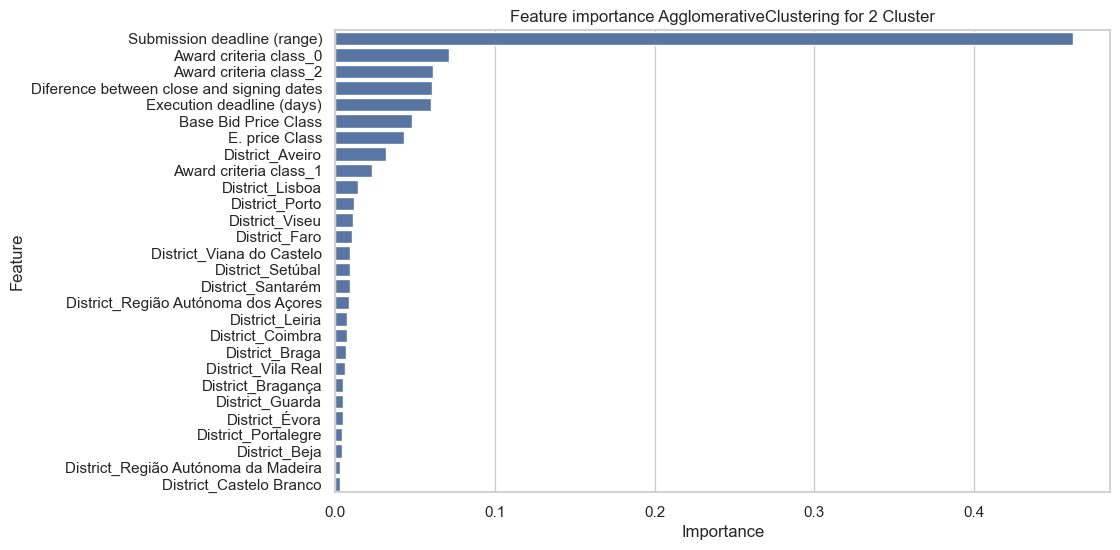

Relevant Features: ['Submission deadline (range)', 'Award criteria class_0', 'Award criteria class_2', 'Diference between close and signing dates']


In [34]:
agglomerative = AgglomerativeClustering(metric='manhattan', linkage='complete')
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

df_relevant_3 = clustering_random_forest(df_final, agglomerative, rf_model, n_clusters=2, importance_threshold=0.06)
print(f"Relevant Features: {df_relevant_3.columns.tolist()}")

Clusters: 2, Linkage: ward, Metric: euclidean, Score: 0.401, Sizes: [3018, 1919]
Clusters: 2, Linkage: complete, Metric: euclidean, Score: 0.384, Sizes: [2234, 2703]
Clusters: 2, Linkage: complete, Metric: manhattan, Score: 0.350, Sizes: [3061, 1876]
Clusters: 2, Linkage: average, Metric: euclidean, Score: 0.397, Sizes: [3031, 1906]
Clusters: 2, Linkage: average, Metric: manhattan, Score: 0.386, Sizes: [3426, 1511]
Best Score: 0.40056418367063346, Best Params: (2, 'ward', 'euclidean', array([0, 0, 0, ..., 0, 0, 0], dtype=int64))


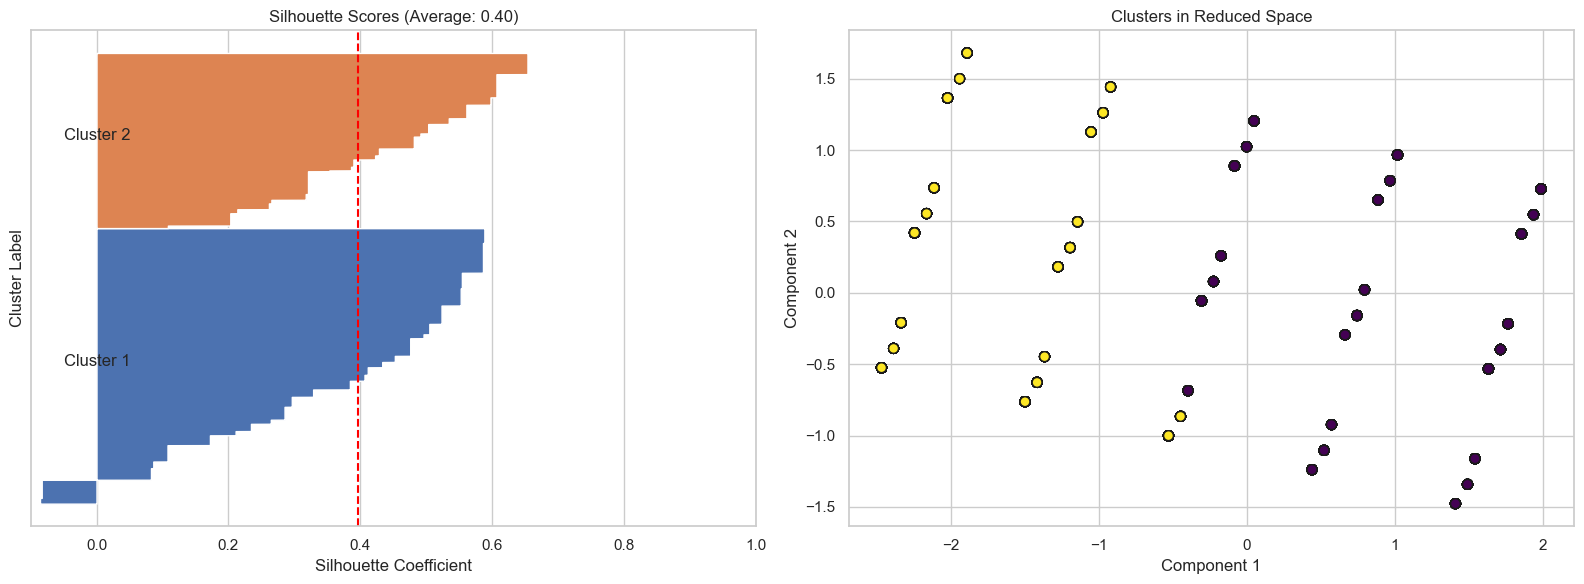

In [35]:
best_score, best_params = hierarchical_clustering_with_silhouette(df_relevant_3, ['ward', 'complete', 'average', 'single'], min_clusters=2, max_clusters=2, min_points_in_cluster=100, metrics=['euclidean', 'manhattan'])
print(f"Best Score: {best_score}, Best Params: {best_params}")
plot_silhouette_and_clusters(df_relevant_3, best_params, metric='manhattan', clustering_algorithm=AgglomerativeClustering)

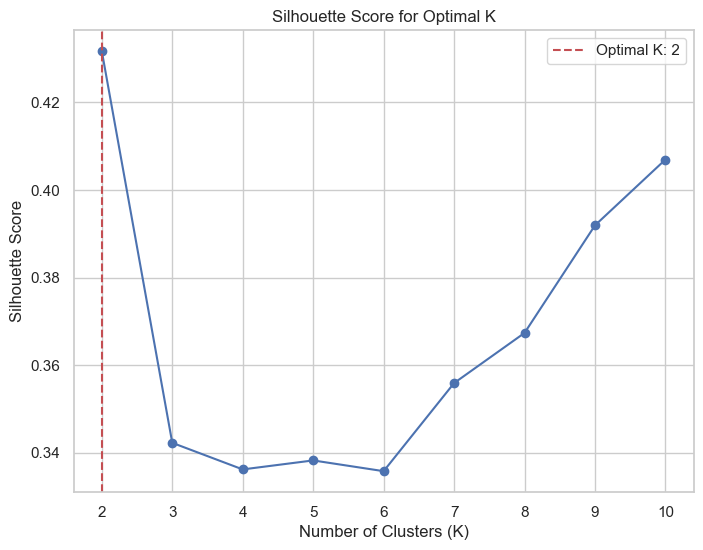

Optimal number of clusters: 2


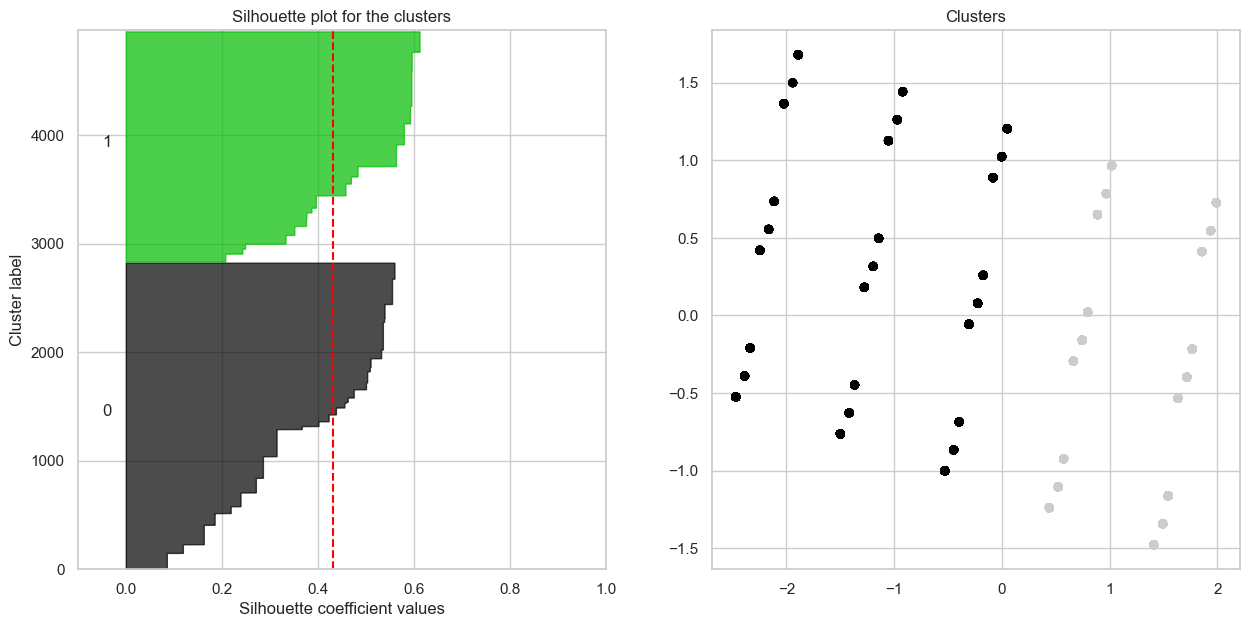

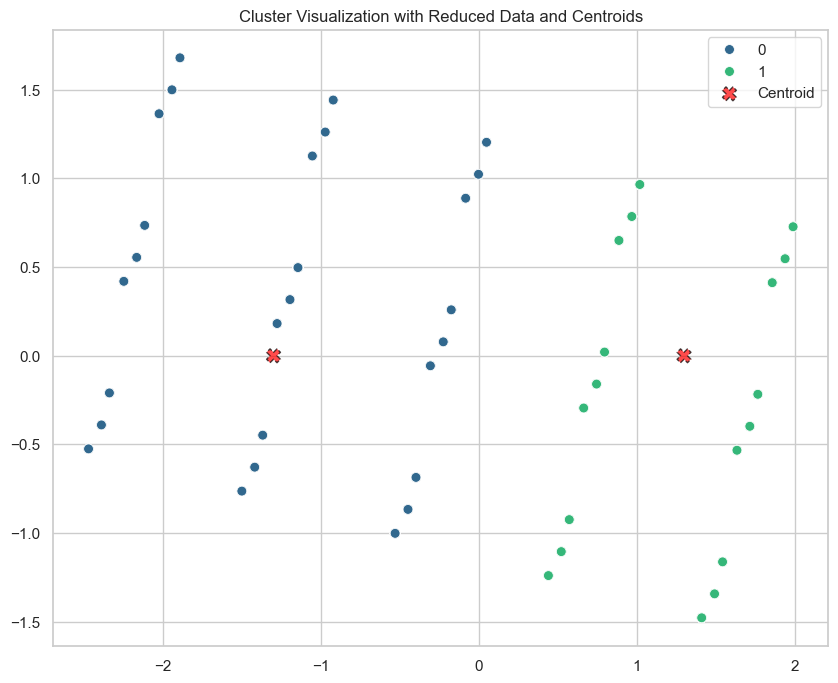

Silhouette Score: 0.4317010869580823
Dumn Index: 1484.1776812825003
SSQ (Sum of Squared Distances): 7711.102161388042


In [36]:
kmeans_model = KMeans()
pipeline = ClusterPipeline(clustering_model=kmeans_model)
df_metrics = pipeline.run(df_relevant_3, max_clusters=10, method='silhouette', threshold=0.15)

In [37]:
df_submitted['ClusterKMeansAgglomerativeManhattan'] = df_metrics['Cluster Labels'][0].tolist()

Despite the improvements made, as I have taken the labels from this clustering to analyze them further, it seems that we are still getting limited improvements due to the high dimensionality of the features. High dimensionality can make it difficult for clustering algorithms to find clear structures in the data, leading to less interpretable or useful results.

One potential approach to address this issue is the use of **PCA (Principal Component Analysis)**. PCA reduces the dimensionality of the data while retaining most of the original variance, simplifying the analysis without losing too much information. Although PCA cannot directly explain the behavior of the resulting clusters, we can still use the **labels** obtained from clustering to interpret the data through other tools, such as **association rules**.

Association rules could help us identify interesting patterns within the clusters, linking the clusters to the original features in an interpretable way. This allows us to gain a clearer understanding of the relationships that characterize each group, even after dimensionality reduction via PCA.

## 5 Approach: PCA + Clustering

To evaluate the correct number of dimensions in PCA, I can analyze the **cumulative explained variance**. This measure allows me to see how much of the total variance is explained by the first principal components.

The **cumulative explained variance** for the first $k$ principal components is calculated as:

$$
C_k = \frac{\sum_{i=1}^{k} \lambda_i}{\sum_{i=1}^{p} \lambda_i}
$$

where:
- $C_k$ is the cumulative explained variance up to the $k$-th component.
- $\lambda_i$ is the eigenvalue associated with the $i$-th principal component.
- $p$ is the total number of principal components.

By looking at the cumulative variance plot, I can choose the minimum number of components that explain a significant percentage (e.g., 90%) of the total variance.

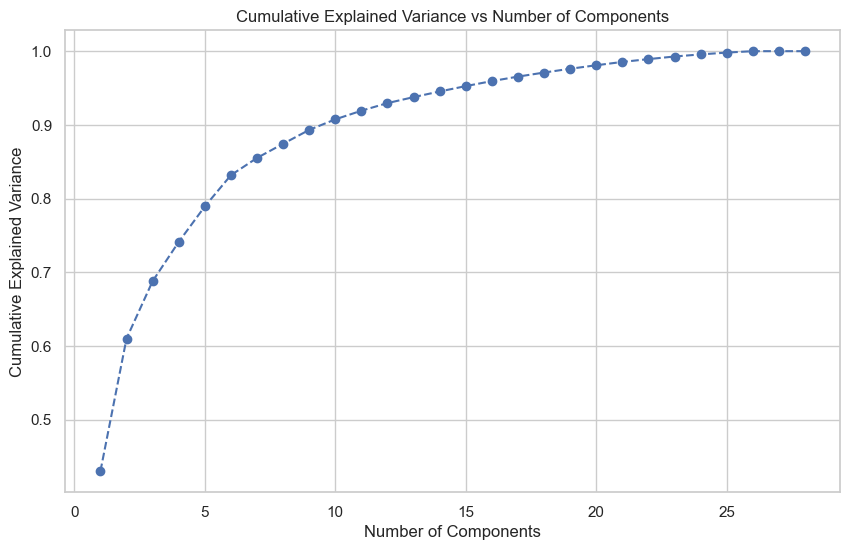

In [38]:
pca = PCA()
pca.fit(df_final)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = explained_variance.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [39]:
pca_opt = PCA(n_components=0.70)
df_reduced = pca_opt.fit_transform(df_final)

print(f'Number of components: {pca_opt.n_components_}')

Number of components: 4


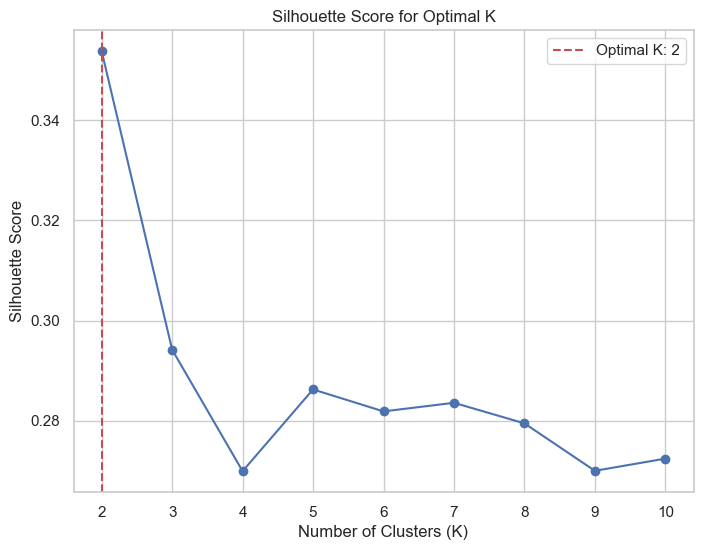

Optimal number of clusters: 2


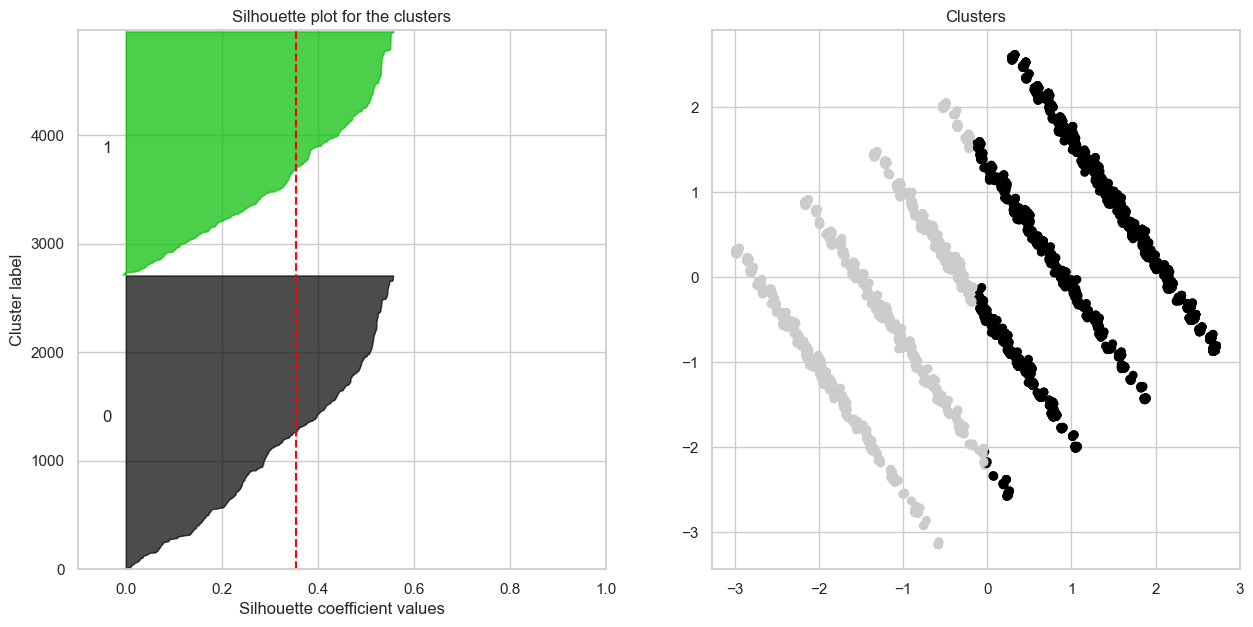

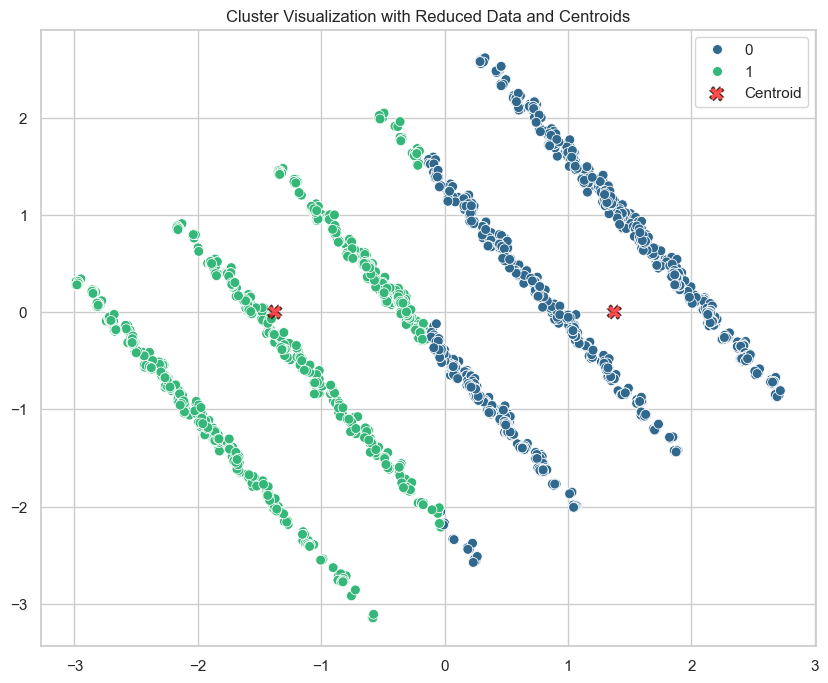

Silhouette Score: 0.35335070073422
Dumn Index: 2338.7112773753547
SSQ (Sum of Squared Distances): 12866.367053792863


In [40]:
kmeans_model = KMeans()
pipeline = ClusterPipeline(clustering_model=kmeans_model)
df_metrics = pipeline.run(df_reduced, max_clusters=10, method='silhouette', threshold=0.15)

Clusters: 2, Linkage: ward, Metric: euclidean, Score: 0.348, Sizes: [3107, 1830]
Clusters: 2, Linkage: complete, Metric: euclidean, Score: 0.290, Sizes: [3081, 1856]
Clusters: 2, Linkage: complete, Metric: manhattan, Score: 0.260, Sizes: [2692, 2245]
Clusters: 2, Linkage: average, Metric: euclidean, Score: 0.346, Sizes: [3203, 1734]
Clusters: 2, Linkage: average, Metric: manhattan, Score: 0.285, Sizes: [3303, 1634]
Clusters: 2, Linkage: single, Metric: euclidean, Score: 0.334, Sizes: [1534, 3403]
Clusters: 2, Linkage: single, Metric: manhattan, Score: 0.291, Sizes: [3403, 1534]
Clusters: 3, Linkage: ward, Metric: euclidean, Score: 0.243, Sizes: [1928, 1830, 1179]
Clusters: 3, Linkage: complete, Metric: euclidean, Score: 0.195, Sizes: [1856, 2050, 1031]
Clusters: 3, Linkage: complete, Metric: manhattan, Score: 0.222, Sizes: [1579, 2245, 1113]
Clusters: 3, Linkage: average, Metric: euclidean, Score: 0.276, Sizes: [1734, 2226, 977]
Clusters: 3, Linkage: average, Metric: manhattan, Score: 

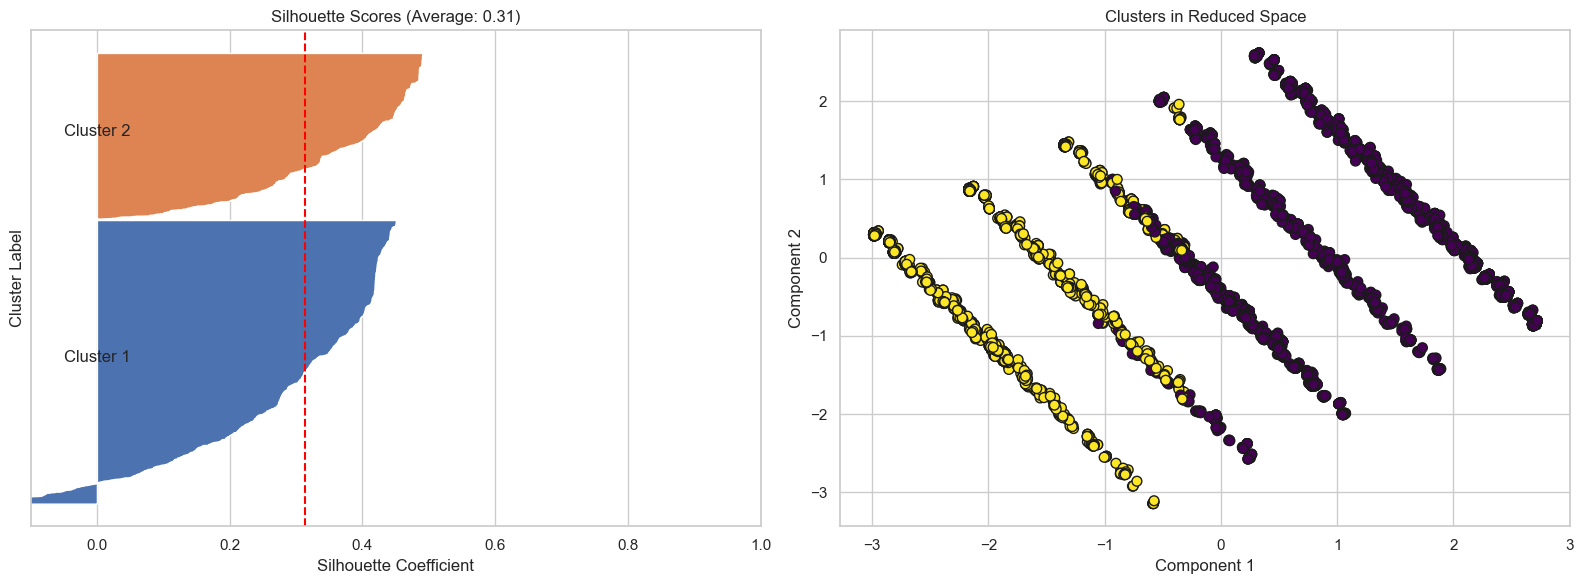

In [41]:
best_score, best_params = hierarchical_clustering_with_silhouette(df_reduced, ['ward', 'complete', 'average', 'single'], min_clusters=2, max_clusters=10, min_points_in_cluster=100, metrics=['euclidean', 'manhattan'])
print(f"Best Score: {best_score}, Best Params: {best_params}")
plot_silhouette_and_clusters(df_reduced, best_params, metric='manhattan', clustering_algorithm=AgglomerativeClustering)

PCA is not providing valid results, as the explained variance, even reaching 70%, is not sufficient to disambiguate the clusters. This suggests that dimensionality reduction via PCA did not allow for the extraction of meaningful information from the data, making it difficult to identify natural groupings.

As a result, I propose discarding this method in favor of Random Forest, which has shown more useful and interesting results previously. Random Forest can be more effective in handling the complexity of the dataset and revealing distinctive patterns.

## 6 Approach: UMAP + Clustering

I used **UMAP (Uniform Manifold Approximation and Projection)** as a dimensionality reduction method to analyze my data. Compared to PCA (Principal Component Analysis), UMAP offers some significant advantages, especially in the context of high-dimensional data.

### Advantages of UMAP over PCA

1. **Preservation of Local Structure**: UMAP is designed to preserve the local structure of the data, meaning it better maintains the relationships between nearby points compared to PCA. This can result in more distinct and consistent clusters in the data.

2. **Flexibility**: UMAP can handle non-linear data, whereas PCA is limited to linear transformations. This allows UMAP to uncover more complex relationships within the data.

3. **Performance with Complex Data**: UMAP tends to provide more meaningful representations for complex and high-dimensional data, leading to better silhouette scores (in my case, I achieved a silhouette score of 0.8).

### Disadvantages of UMAP

1. **Variance Explanation**: Unlike PCA, UMAP does not provide a direct indication of the explained variance. This means it is not easy to interpret how well UMAP represents the original data in terms of variance.

2. **Interpretability**: The results obtained through UMAP can be harder to interpret compared to those from PCA. There is no direct correlation between the new dimensions and the original dimensions, which can make it more difficult to use the results for decisions based on specific features.

### Pros and Cons of UMAP

| Advantages                          | Disadvantages                        |
|-------------------------------------|--------------------------------------|
| Preserves local structure           | Does not explain variance            |
| Handles non-linear data             | Results are less interpretable       |
| Effective for complex data          | Requires more computational resources|

c:\Users\dommy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dommy\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


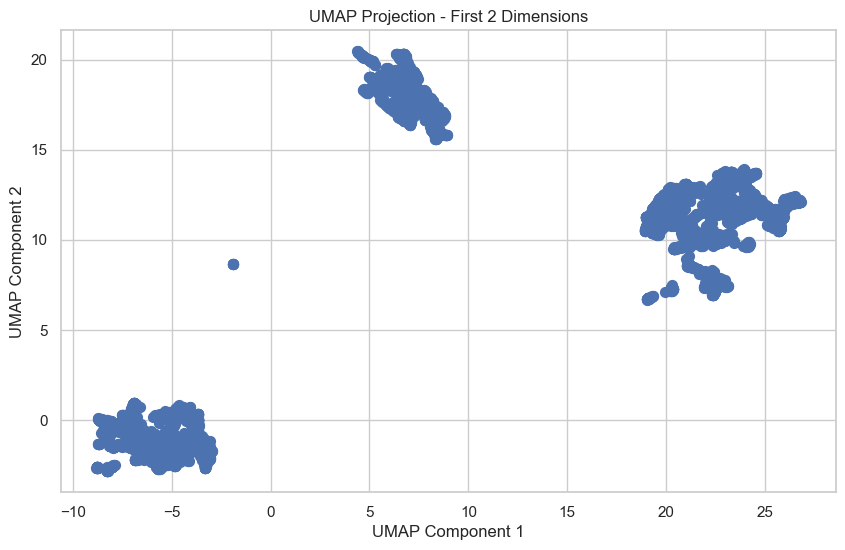

In [42]:
n_components = 3
umap_model = umap.UMAP(n_components=n_components, random_state=42)

# Applica UMAP ai dati
umap_result = umap_model.fit_transform(df_final)
plt.figure(figsize=(10, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], s=50)

plt.title('UMAP Projection - First 2 Dimensions')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

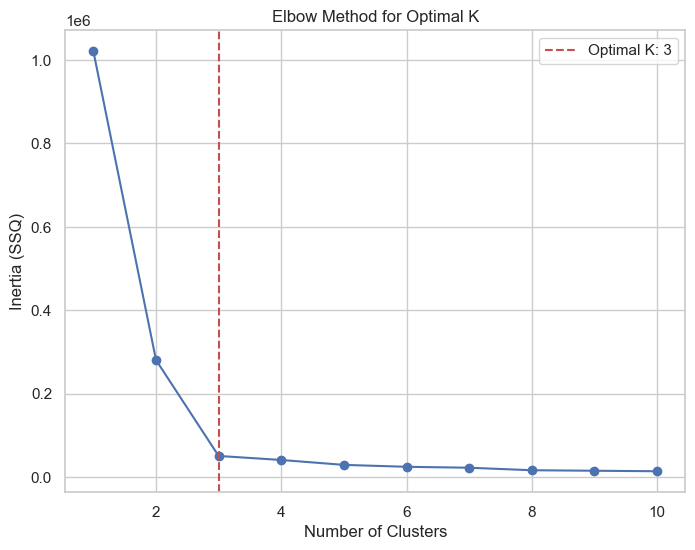

Optimal number of clusters: 3


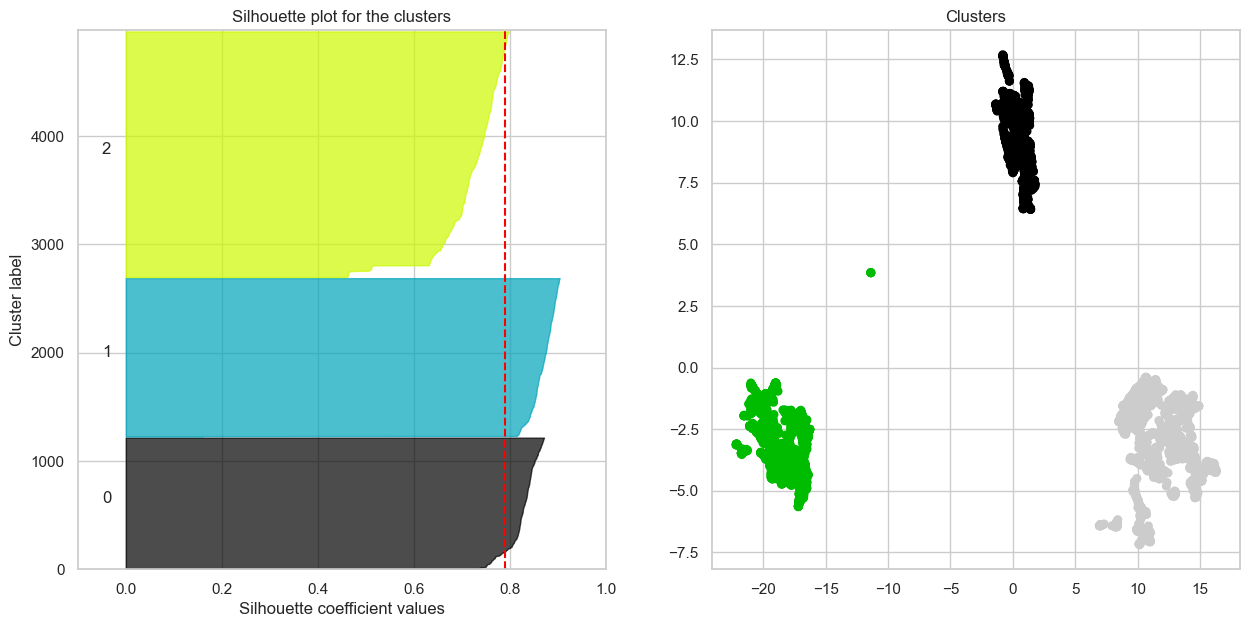

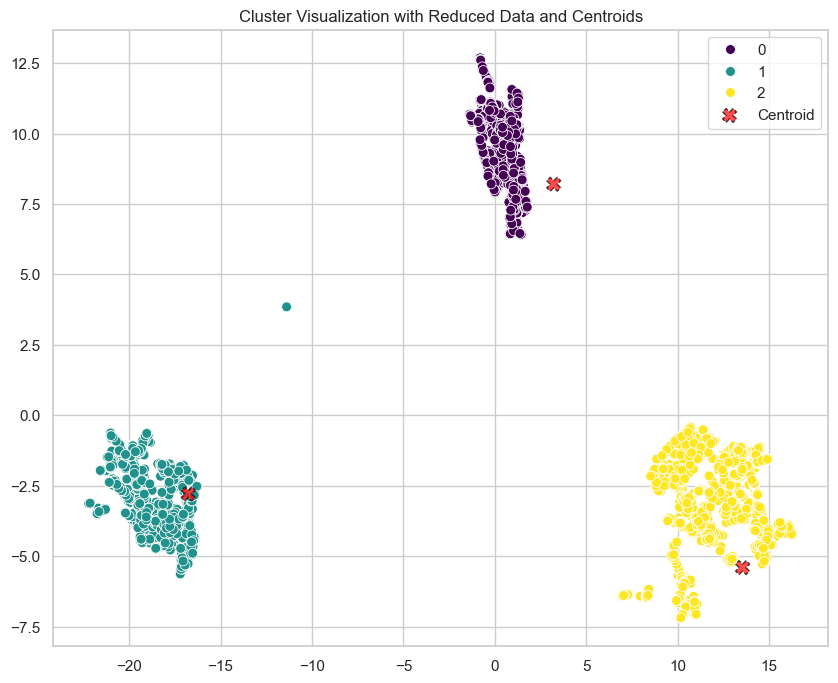

Silhouette Score: 0.7885501980781555
Dumn Index: 727.9532065962645
SSQ (Sum of Squared Distances): 51182.34375


In [43]:
kmeans_model = KMeans()
pipeline = ClusterPipeline(clustering_model=kmeans_model)
df_metrics = pipeline.run(umap_result, max_clusters=10)

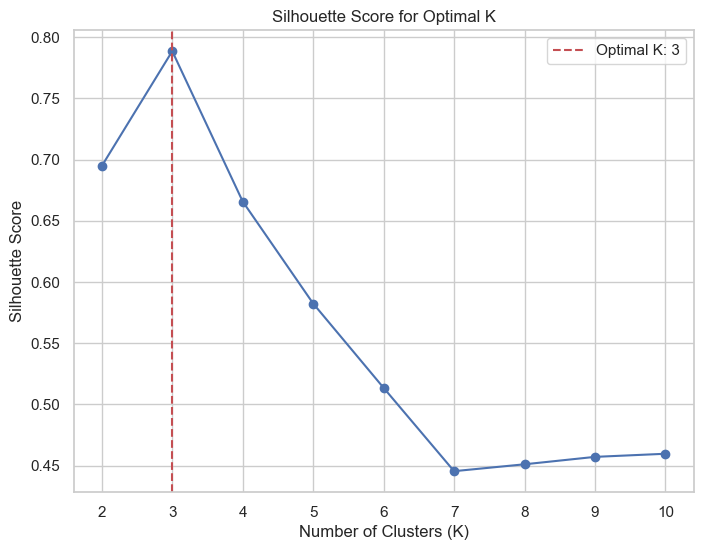

Optimal number of clusters: 3


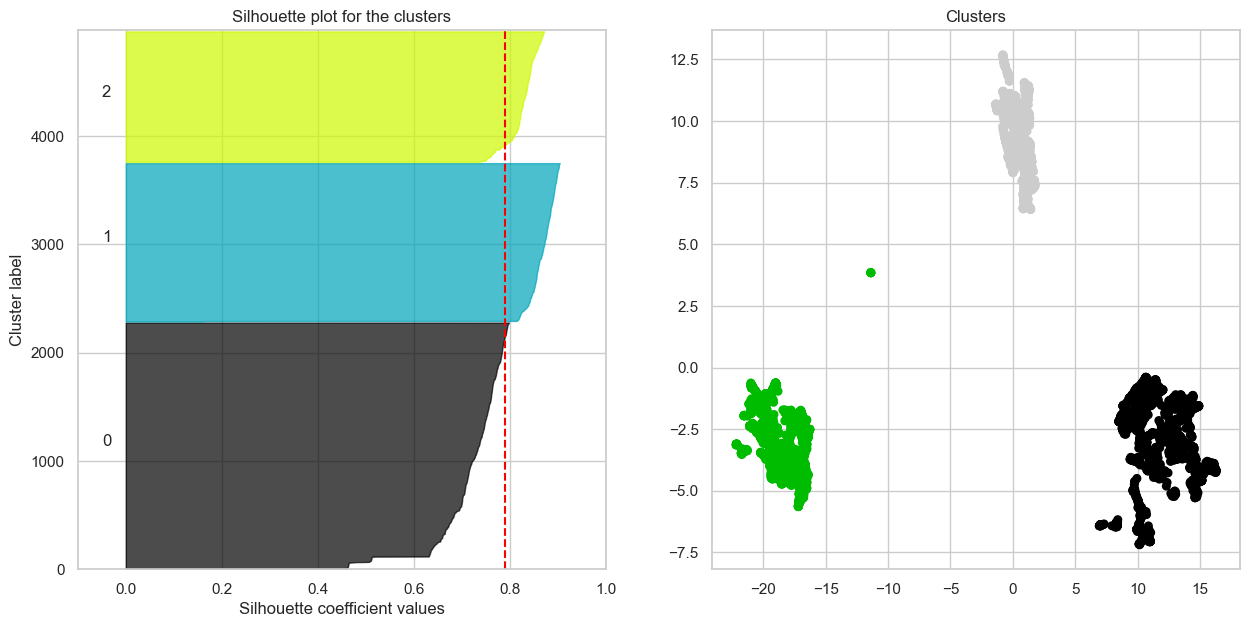

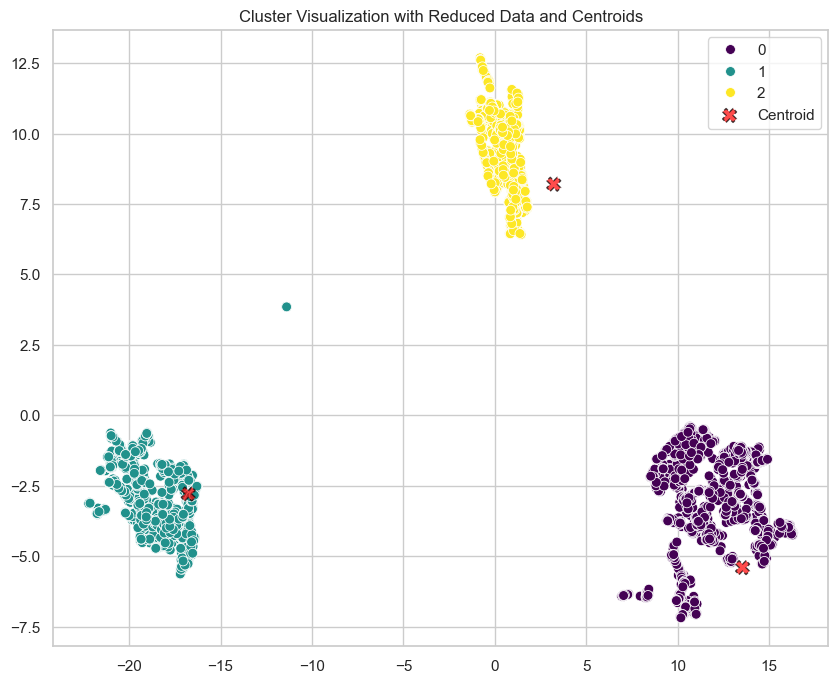

Silhouette Score: 0.7885501980781555
Dumn Index: 727.9531232598929
SSQ (Sum of Squared Distances): 51182.33984375


In [44]:
kmeans_model = KMeans()
pipeline = ClusterPipeline(clustering_model=kmeans_model)
df_metrics = pipeline.run(umap_result, max_clusters=10, method='silhouette', threshold=0.15)

Clusters: 2, Linkage: ward, Metric: euclidean, Score: 0.695, Sizes: [3474, 1463]
Clusters: 2, Linkage: complete, Metric: euclidean, Score: 0.695, Sizes: [3474, 1463]
Clusters: 2, Linkage: complete, Metric: manhattan, Score: 0.684, Sizes: [3474, 1463]
Clusters: 2, Linkage: average, Metric: euclidean, Score: 0.695, Sizes: [3474, 1463]
Clusters: 2, Linkage: average, Metric: manhattan, Score: 0.684, Sizes: [3474, 1463]
Clusters: 2, Linkage: single, Metric: euclidean, Score: 0.695, Sizes: [3474, 1463]
Clusters: 2, Linkage: single, Metric: manhattan, Score: 0.684, Sizes: [3474, 1463]
Clusters: 3, Linkage: ward, Metric: euclidean, Score: 0.789, Sizes: [2268, 1463, 1206]
Clusters: 3, Linkage: complete, Metric: euclidean, Score: 0.789, Sizes: [1463, 2268, 1206]
Clusters: 3, Linkage: complete, Metric: manhattan, Score: 0.778, Sizes: [1463, 2268, 1206]
Clusters: 3, Linkage: average, Metric: euclidean, Score: 0.789, Sizes: [1463, 2268, 1206]
Clusters: 3, Linkage: average, Metric: manhattan, Score:

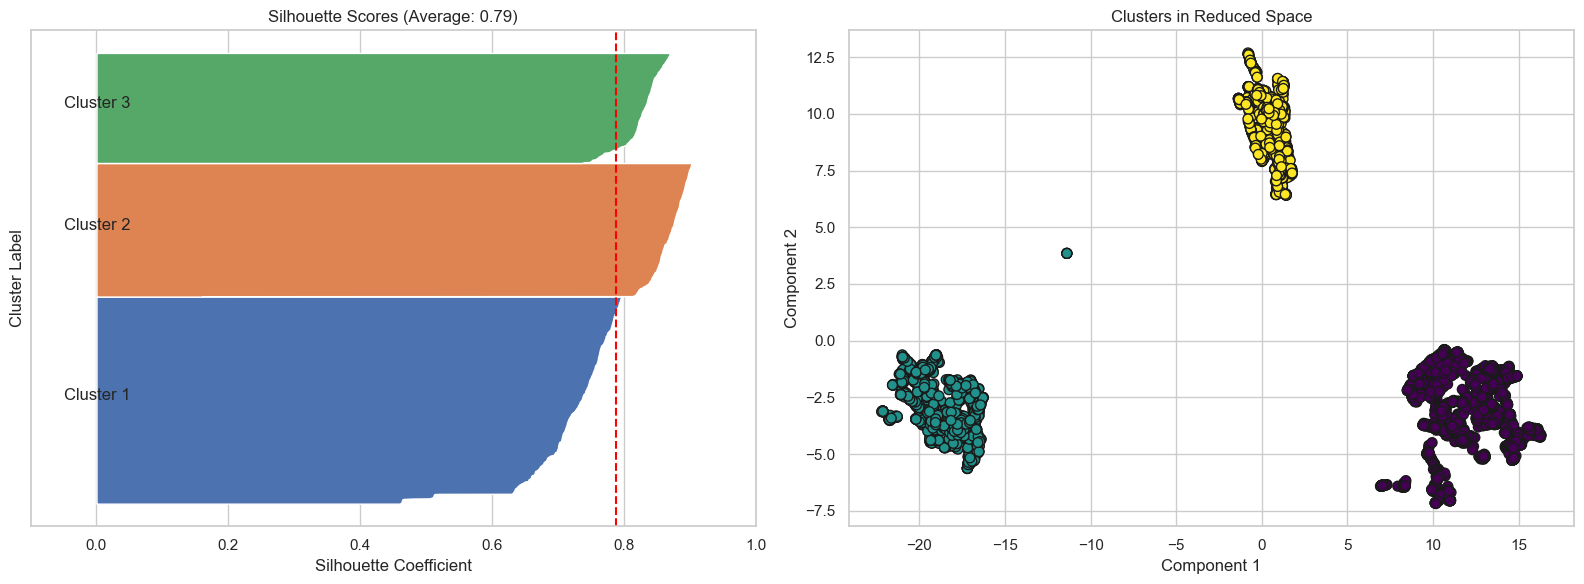

In [45]:
best_score, best_params = hierarchical_clustering_with_silhouette(umap_result, ['ward', 'complete', 'average', 'single'], min_clusters=2, max_clusters=4, min_points_in_cluster=300, metrics=['euclidean', 'manhattan'])
print(f"Best Score: {best_score}, Best Params: {best_params}")
plot_silhouette_and_clusters(umap_result, best_params, metric='euclidean', clustering_algorithm=AgglomerativeClustering)

In [46]:
df_submitted['ClusterKMeansUmap'] = df_metrics['Cluster Labels'][0].tolist()

In [47]:
df_submitted.to_csv('PPPData_EN_1.0_completed_clustered.csv', index=False)

### Comment on Clustering Results using UMAP

I obtained an excellent Silhouette Score of **0.82** for both the **K-Means** and **Agglomerative Clustering** models. This score indicates that the clusters are well-defined and separated, which is a positive sign for the effectiveness of the clustering methods used.

However, there are some caveats to consider:

1. **Use of UMAP**: Although UMAP was used to reduce the dimensionality of the data while preserving its local structure, the resulting data are not the original ones. Therefore, the information may be distorted or not fully representative of the variability of the original data.

2. **Arbitrary Cluster Sizes**: The clusters generated may be influenced by the arbitrary sizes imposed during the clustering process. The size and shape of the clusters may vary, and from the reduced data plot, the shape of these clusters can be observed. While they are well-separated, it is evident that in the case of K-Means, the centroids are shifted, suggesting that the result obtained is not perfectly accurate. This implies that there may be some overlap or confusion between clusters, despite the high Silhouette score.

3. **Dunn Index and SSQ**: It is interesting to note that the Dunn Index for the **K-Means** model is the smallest found so far, while the Sum of Squared Distances (SSQ) is the largest. This could suggest that while the clusters are well-defined (low Dunn Index), there are still significant distortions in the data (high SSQ).

4. **Exploring Results**: Since we have obtained three intermediate results during the previous phases, I propose using **Association Pattern Mining** on these results. This technique could provide further insights into the patterns and relationships in the data, allowing us to discover significant patterns that were not highlighted through clustering.

5. **Choice of Distances for UMAP**: It is important to note that for UMAP, distance measures such as **Euclidean** and **Manhattan** were prioritized, since we are working with low-dimensional data. These measures are more appropriate for the nature of the reduced data and can contribute to a better interpretation of their distribution.

Therefore, I will use this Silhouette score, merging it into the dataset, and later, during association pattern mining, validate the results obtained with the other strategies previously adopted, also based on the semantics of the features.

# Interpretation of clustering results

In order to validate which choice of classes is most consistent with the data we have as input, I will proceed to plot a series of graphs in order to show these characteristics.

### Information Gain (IG) and Feature Relevance

**Information Gain (IG)** measures the reduction in entropy \( H(Y) \) of a target variable \( Y \) given a feature \( X \).

The formula for Information Gain is:

$$
IG(Y|X) = H(Y) - H(Y|X)
$$

Where:
- \( H(Y) \) is the entropy of the target variable \( Y \).
- \( H(Y|X) \) is the conditional entropy of the target variable \( Y \) given the feature \( X \).

It helps to reduce uncertainty. Generally, if \( IG(X) > IG(Y) \), it means that \( X \) is preferred over \( Y \) because \( X \) reduces uncertainty more effectively compared to the target class.

### Entropy Calculation

The **entropy** of a variable \( Y \) is calculated as:

$$
H(Y) = - \sum_{y \in Y} p(y) \log_2 p(y)
$$

Where \( p(y) \) is the probability of class \( y \) in \( Y \).

The **conditional entropy** of \( Y \) given \( X \) is:

$$
H(Y|X) = - \sum_{x \in X} p(x) \sum_{y \in Y} p(y|x) \log_2 p(y|x)
$$

Where:
- \( p(x) \) is the probability of feature \( X \),
- \( p(y|x) \) is the probability of the target variable \( Y \) given feature \( X \).

### How to Interpret Information Gain

- A high **Information Gain (IG)** means that the feature \( X \) reduces the uncertainty about \( Y \) significantly, making it a valuable feature.
- A low **Information Gain (IG)** means that \( X \) doesn’t help much in reducing uncertainty about \( Y \), suggesting that the feature is less useful for predicting the target variable.

### Steps to Calculate Information Gain for Clustering Results

1. **Calculate the entropy of the target variable \( Y \)** (the labels obtained from clustering).
2. **Calculate the conditional entropy** of \( Y \) given each feature.
3. **Calculate the Information Gain** for each feature using the formula above.

If you'd like, I can help you implement this calculation using Python with libraries like `sklearn` and `numpy`. Let me know if you need assistance with the code.

Provo con tutti e 3 le label ottenute dai vari approcci di clustering:
1. **Hierachical**
2. **Agglomerative per generare i target + Random Forest e infine K-Means**
3. **KMeans + UMAP**

In [48]:
df_submitted = pd.read_csv('PPPData_EN_1.0_completed_clustered.csv')

In [49]:
df_one_hot_extended = df_submitted[[
    'Publication Year', 'Close Year', 'Signing Year', 'Signing Month', 'Closing Date Year', 'Closing Date Month',
    'Justification for deadline change'
]].astype(str)

df_bool = df_submitted[['Environmental criteria (T/F)', 'Published in the EU journal', 'engineering work', 
                        'refurbishment work', 'surfaced work']].astype(bool)

col_nums_extended = ['Classification of the multifactor criteria (%)', 'Number of bidders']

df_categorical_extended = pd.get_dummies(df_one_hot_extended)
df_final_extended = pd.concat([df_final, df_categorical_extended], axis=1)
df_final_extended = pd.concat([df_final_extended, df_submitted[col_nums_extended]], axis=1)
df_final_extended = pd.concat([df_final_extended, df_bool], axis=1)

df_final_extended.head()

E. price Class Base Bid Price Class Submission deadline (range)  \
0              0                    0                           4   
1              0                    0                           3   
2              0                    0                           3   
3              0                    0                           1   
4              0                    0                           1   

  Diference between close and signing dates Execution deadline (days)  \
0                                         1                         2   
1                                         1                         0   
2                                         0                         0   
3                                         1                         0   
4                                         0                         0   

   District_Aveiro  District_Beja  District_Braga  District_Bragança  \
0            False          False           False              False   
1            False          False           False              False   
2            False          False           False              False   
3            False          False           False              False   
4            False          False           False              False   

   District_Castelo Branco  ...  Justification for deadline change_suspension  \
0                    False  ...                                         False   
1                    False  ...                                         False   
2                    False  ...                                         False   
3                    False  ...                                         False   
4                    False  ...                                         False   

   Justification for deadline change_time  \
0                                   False   
1                                   False   
2                                   False   
3                                   False   
4                                   False   

   Justification for deadline change_weather condition  \
0                                              False     
1                                              False     
2                                              False     
3                                              False     
4                                              False     

   Classification of the multifactor criteria (%)  Number of bidders  \
0                                             1.0              0.100   
1                                             1.0              0.050   
2                                             0.0              0.125   
3                                             1.0              0.125   
4                                             1.0              0.225   

   Environmental criteria (T/F)  Published in the EU journal  \
0                         False                        False   
1                         False                        False   
2                         False                        False   
3                         False                        False   
4                         False                        False   

   engineering work  refurbishment work  surfaced work  
0             False               False          False  
1             False               False          False  
2             False               False          False  
3             False               False          False  
4             False               False          False  

[5 rows x 119 columns]

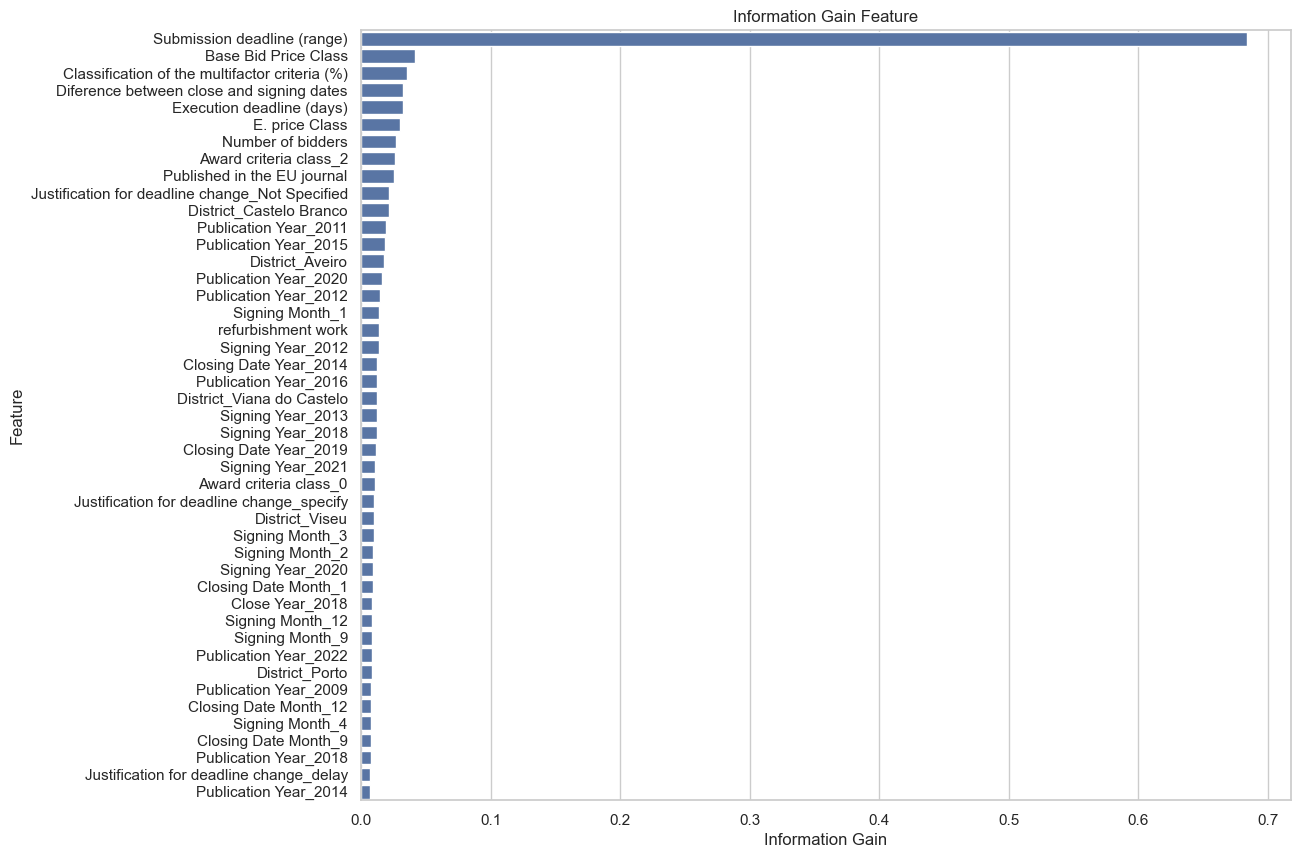

In [50]:
X = df_final_extended
y = df_submitted['ClusterKMeansAgglomerativeManhattan']
ig_kmeans_rf = plot_information_gain(X, y, top_ig=45, figsize=(12, 10))

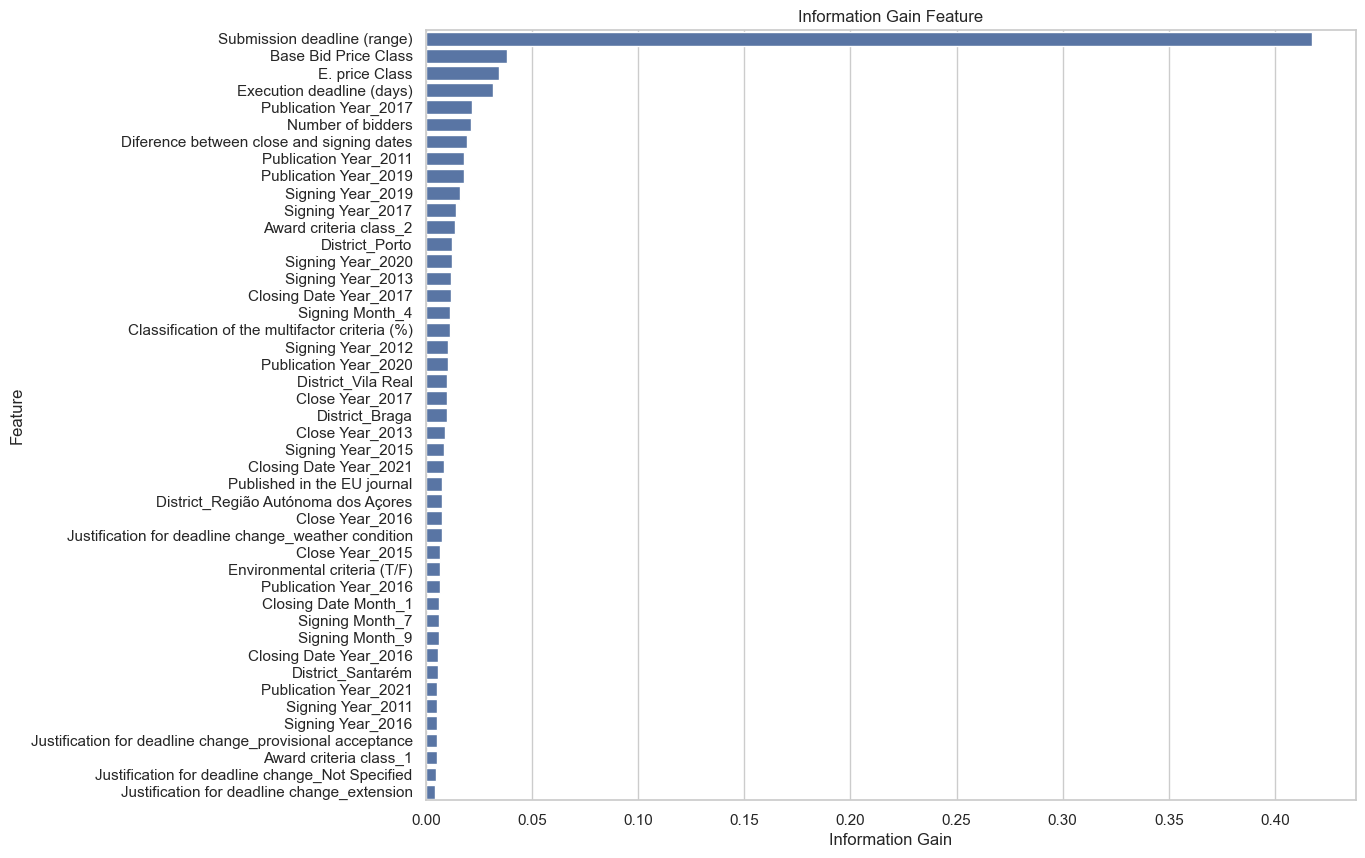

In [51]:
X = df_final_extended
y = df_submitted['ClusterAgglomerativeCosine']
ig_agglomerative = plot_information_gain(X, y, top_ig=45, figsize=(12, 10))

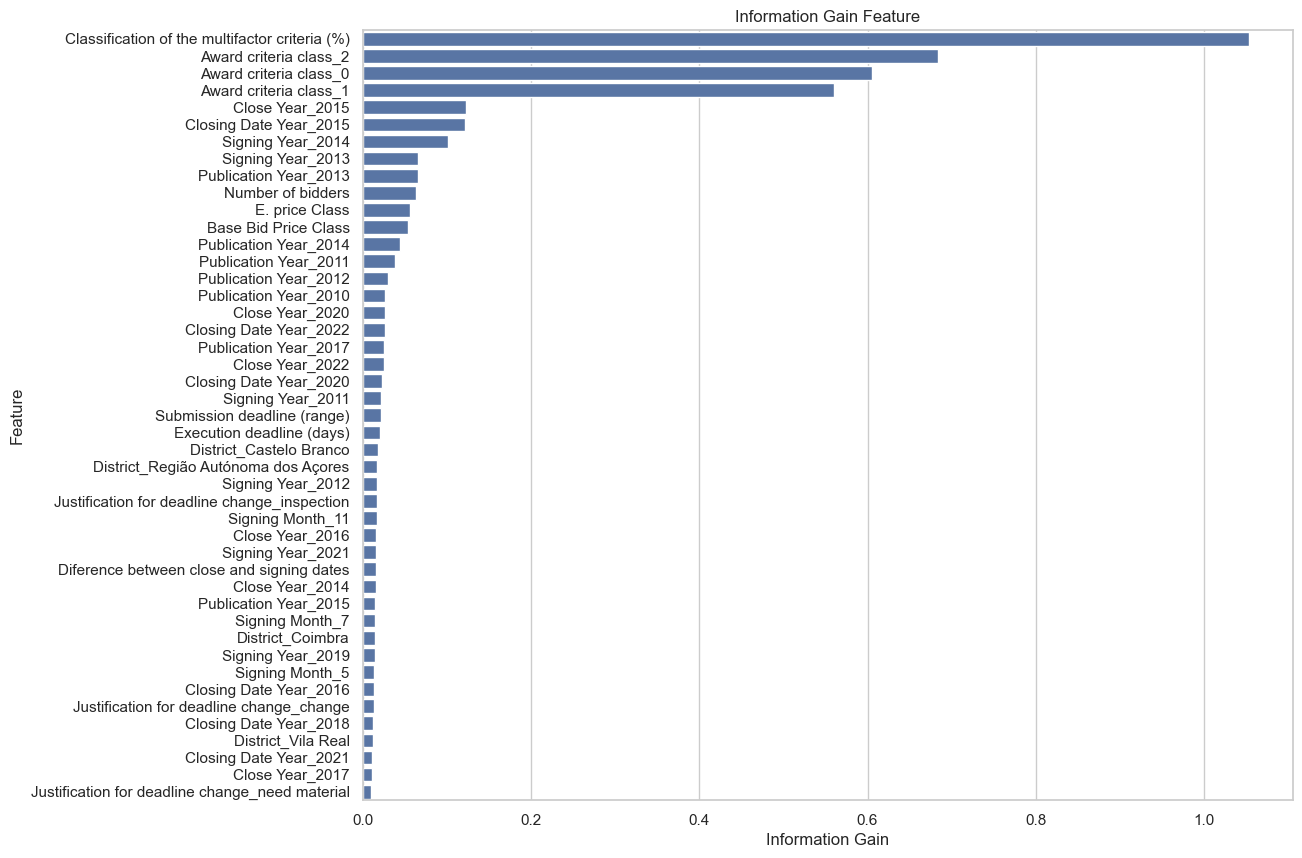

In [52]:
X = df_final_extended
y = df_submitted['ClusterKMeansUmap']
ig_umap = plot_information_gain(X, y, top_ig=45, figsize=(12, 10))

In general, the clusters surveyed, performing an Information Gain (IG) analysis, emphasise the time of contracts (filing and execution), price and criteria, and specific years. They do not appear to be significantly influenced by location.

### Adopting Labels from Clustering with UMAP

After analyzing the features that contribute most to **Information Gain (IG)** and considering their values, I find consistency with previous analyses and the semantics of the variables. Therefore, I decide to adopt these labels, as they have passed 4 key evaluations:

1. **Silhouette Score**: Indicates the quality of separation between the clusters.
2. **Dunn Index**: Measures the compactness and separation of the clusters.
3. **Visualization**: Allows for a graphical observation of the structure of the data and clusters.
4. **Semantics**: Considers the meaning of the variables in relation to the problem domain.

These metrics give me confidence in the robustness of the selected labels.

In [53]:
df_final_extended['Cluster Labels'] = df_submitted['ClusterKMeansUmap']

**Random Forest with IG**

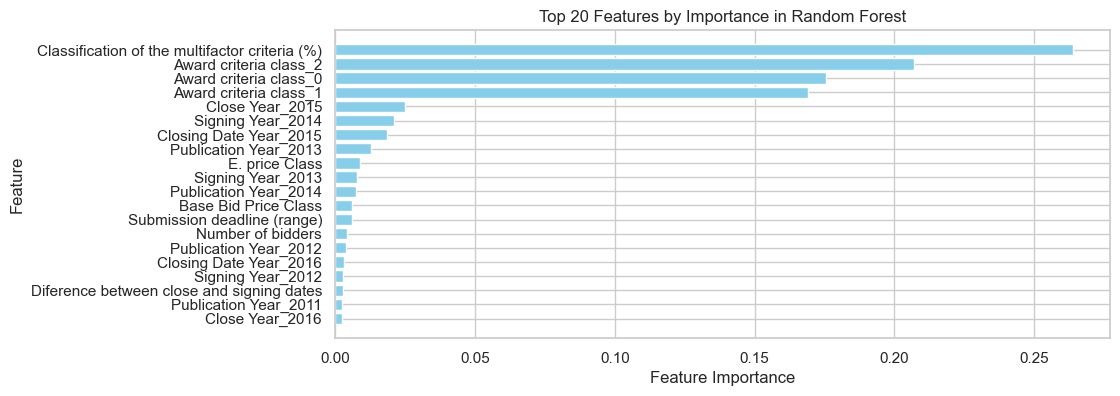

In [54]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
X = df_final_extended.drop(columns=['Cluster Labels'])
y = df_final_extended['Cluster Labels']
rf.fit(X, y)

feature_importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 4))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Features by Importance in Random Forest')
plt.gca().invert_yaxis()
plt.show()

Here, the trained Random Forest confirms the important top features found with Information Gain.

**Cluster Interpretation**

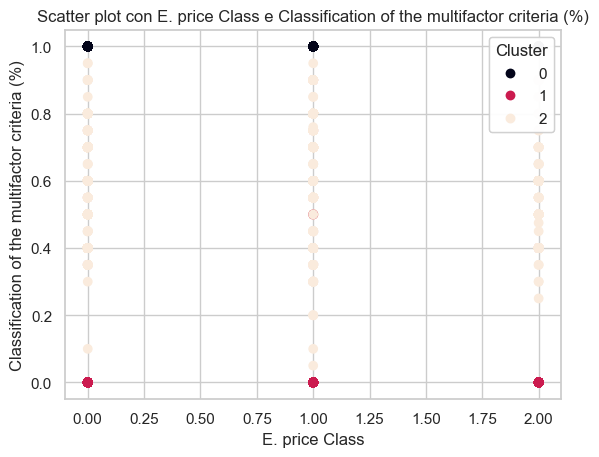

In [55]:
scatter = plt.scatter(df_final_extended['E. price Class'], df_final_extended['Classification of the multifactor criteria (%)'], c=df_final_extended['Cluster Labels'])
plt.xlabel('E. price Class')
plt.ylabel('Classification of the multifactor criteria (%)')
plt.title('Scatter plot con E. price Class e Classification of the multifactor criteria (%)')
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster")
plt.gca().add_artist(legend1)
plt.show()

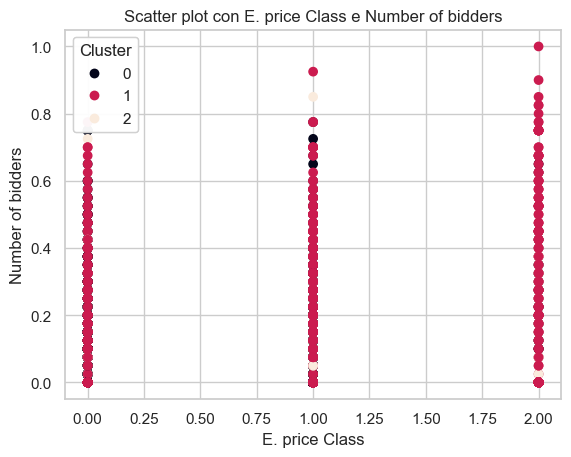

In [56]:
scatter = plt.scatter(df_final_extended['E. price Class'], df_final_extended['Number of bidders'], c=df_final_extended['Cluster Labels'])
plt.xlabel('E. price Class')
plt.ylabel('Number of bidders')
plt.title('Scatter plot con E. price Class e Number of bidders')
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster")
plt.gca().add_artist(legend1)
plt.show()

As can be seen in both scatterplots, the points are well divided and represented, thus demonstrating the goodness of the clustering and the relationship between E.price with Number of bidders (which are also among the features with the most GI for the class).

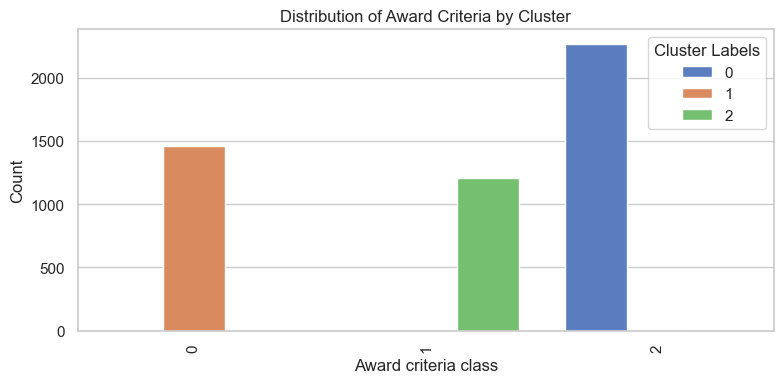

In [57]:
create_countplot(df_final_extended, df['Award criteria class'], df_final_extended['Cluster Labels'], 'Distribution of Award Criteria by Cluster', figsize=(8, 4))

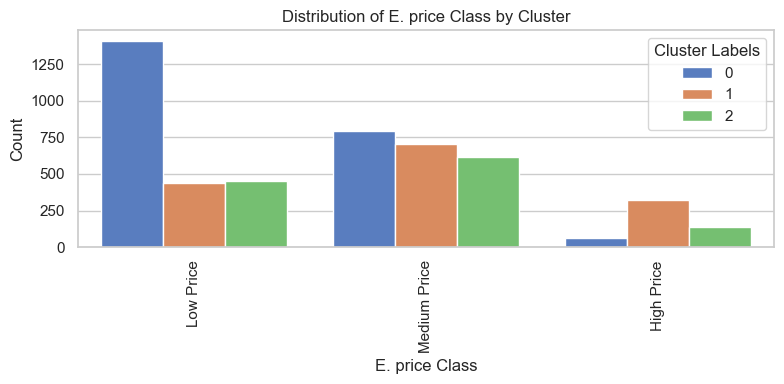

In [58]:
create_countplot(df_final_extended, df['E. price Class'], df_final_extended['Cluster Labels'], 'Distribution of E. price Class by Cluster', figsize=(8, 4))

Here there is an agreement of the goodness of clustering and correlation: the low price has the same class as the criteria award 2 which is defined on the lowest price.

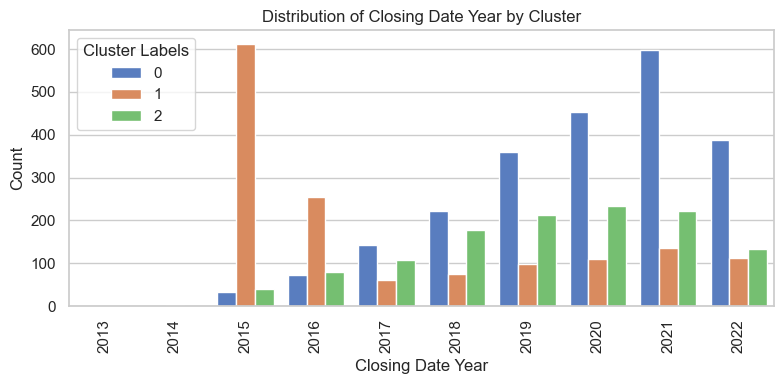

In [59]:
create_countplot(df_final_extended, df['Closing Date Year'], df_final_extended['Cluster Labels'], 'Distribution of Closing Date Year by Cluster', figsize=(8, 4))

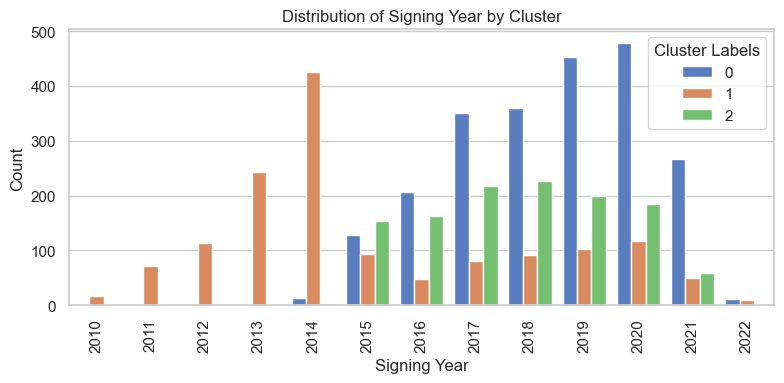

In [60]:
create_countplot(df_final_extended, df['Signing Year'], df_final_extended['Cluster Labels'], 'Distribution of Signing Year by Cluster', figsize=(8, 4))

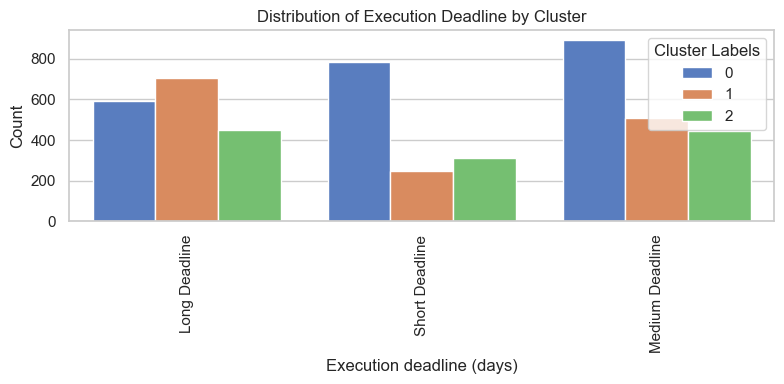

In [61]:
create_countplot(df_final_extended, df['Execution deadline (days)'], df_final_extended['Cluster Labels'], 'Distribution of Execution Deadline by Cluster', figsize=(8, 4))

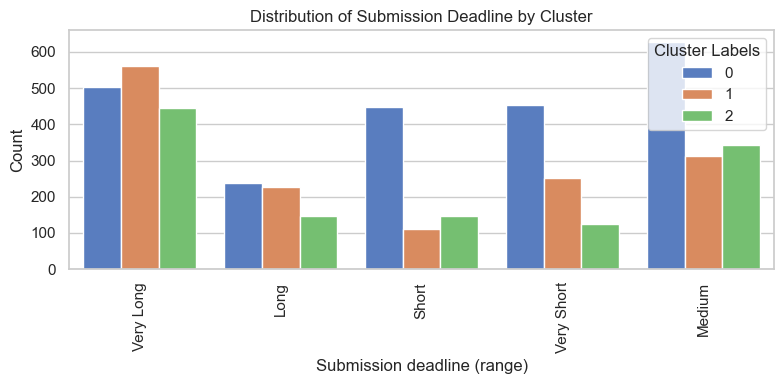

In [62]:
create_countplot(df_final_extended, df['Submission deadline (range)'], df_final_extended['Cluster Labels'], 'Distribution of Submission Deadline by Cluster', figsize=(8, 4))

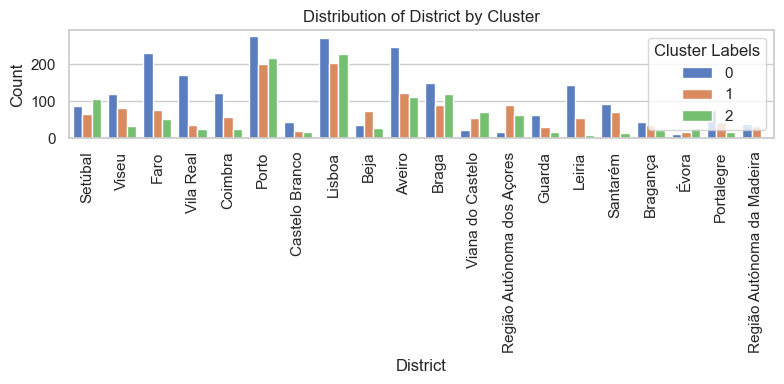

In [63]:
create_countplot(df_final_extended, df['District'], df_final_extended['Cluster Labels'], 'Distribution of District by Cluster', figsize=(8, 4))

### Label Mapping Based on Clustering Results

It seems that the labels obtained from the clustering align with the previous findings, as summarized by the following mapping:

1. **Label 0** for low-cost contracts, which require little time, and are influenced by the "Award Criteria Lowest Price."
2. **Label 1** for medium-cost contracts, which require little to moderate time, sometimes varying by year, and are influenced by the "Missing Award Criterion."
3. **Label 2** for high-cost contracts, which generally require more time and are influenced by the "Multifactor Criteria."

As also highlighted with **Information Gain (IG)** and the previous graphs, **District** is not strongly discriminative—it mostly affects the volume, but the overall distribution remains similar. However, **Açores** does not follow this pattern and is, in fact, marked as a feature that has more impact on **IG**, being the only one in **District** to appear in the top 20.

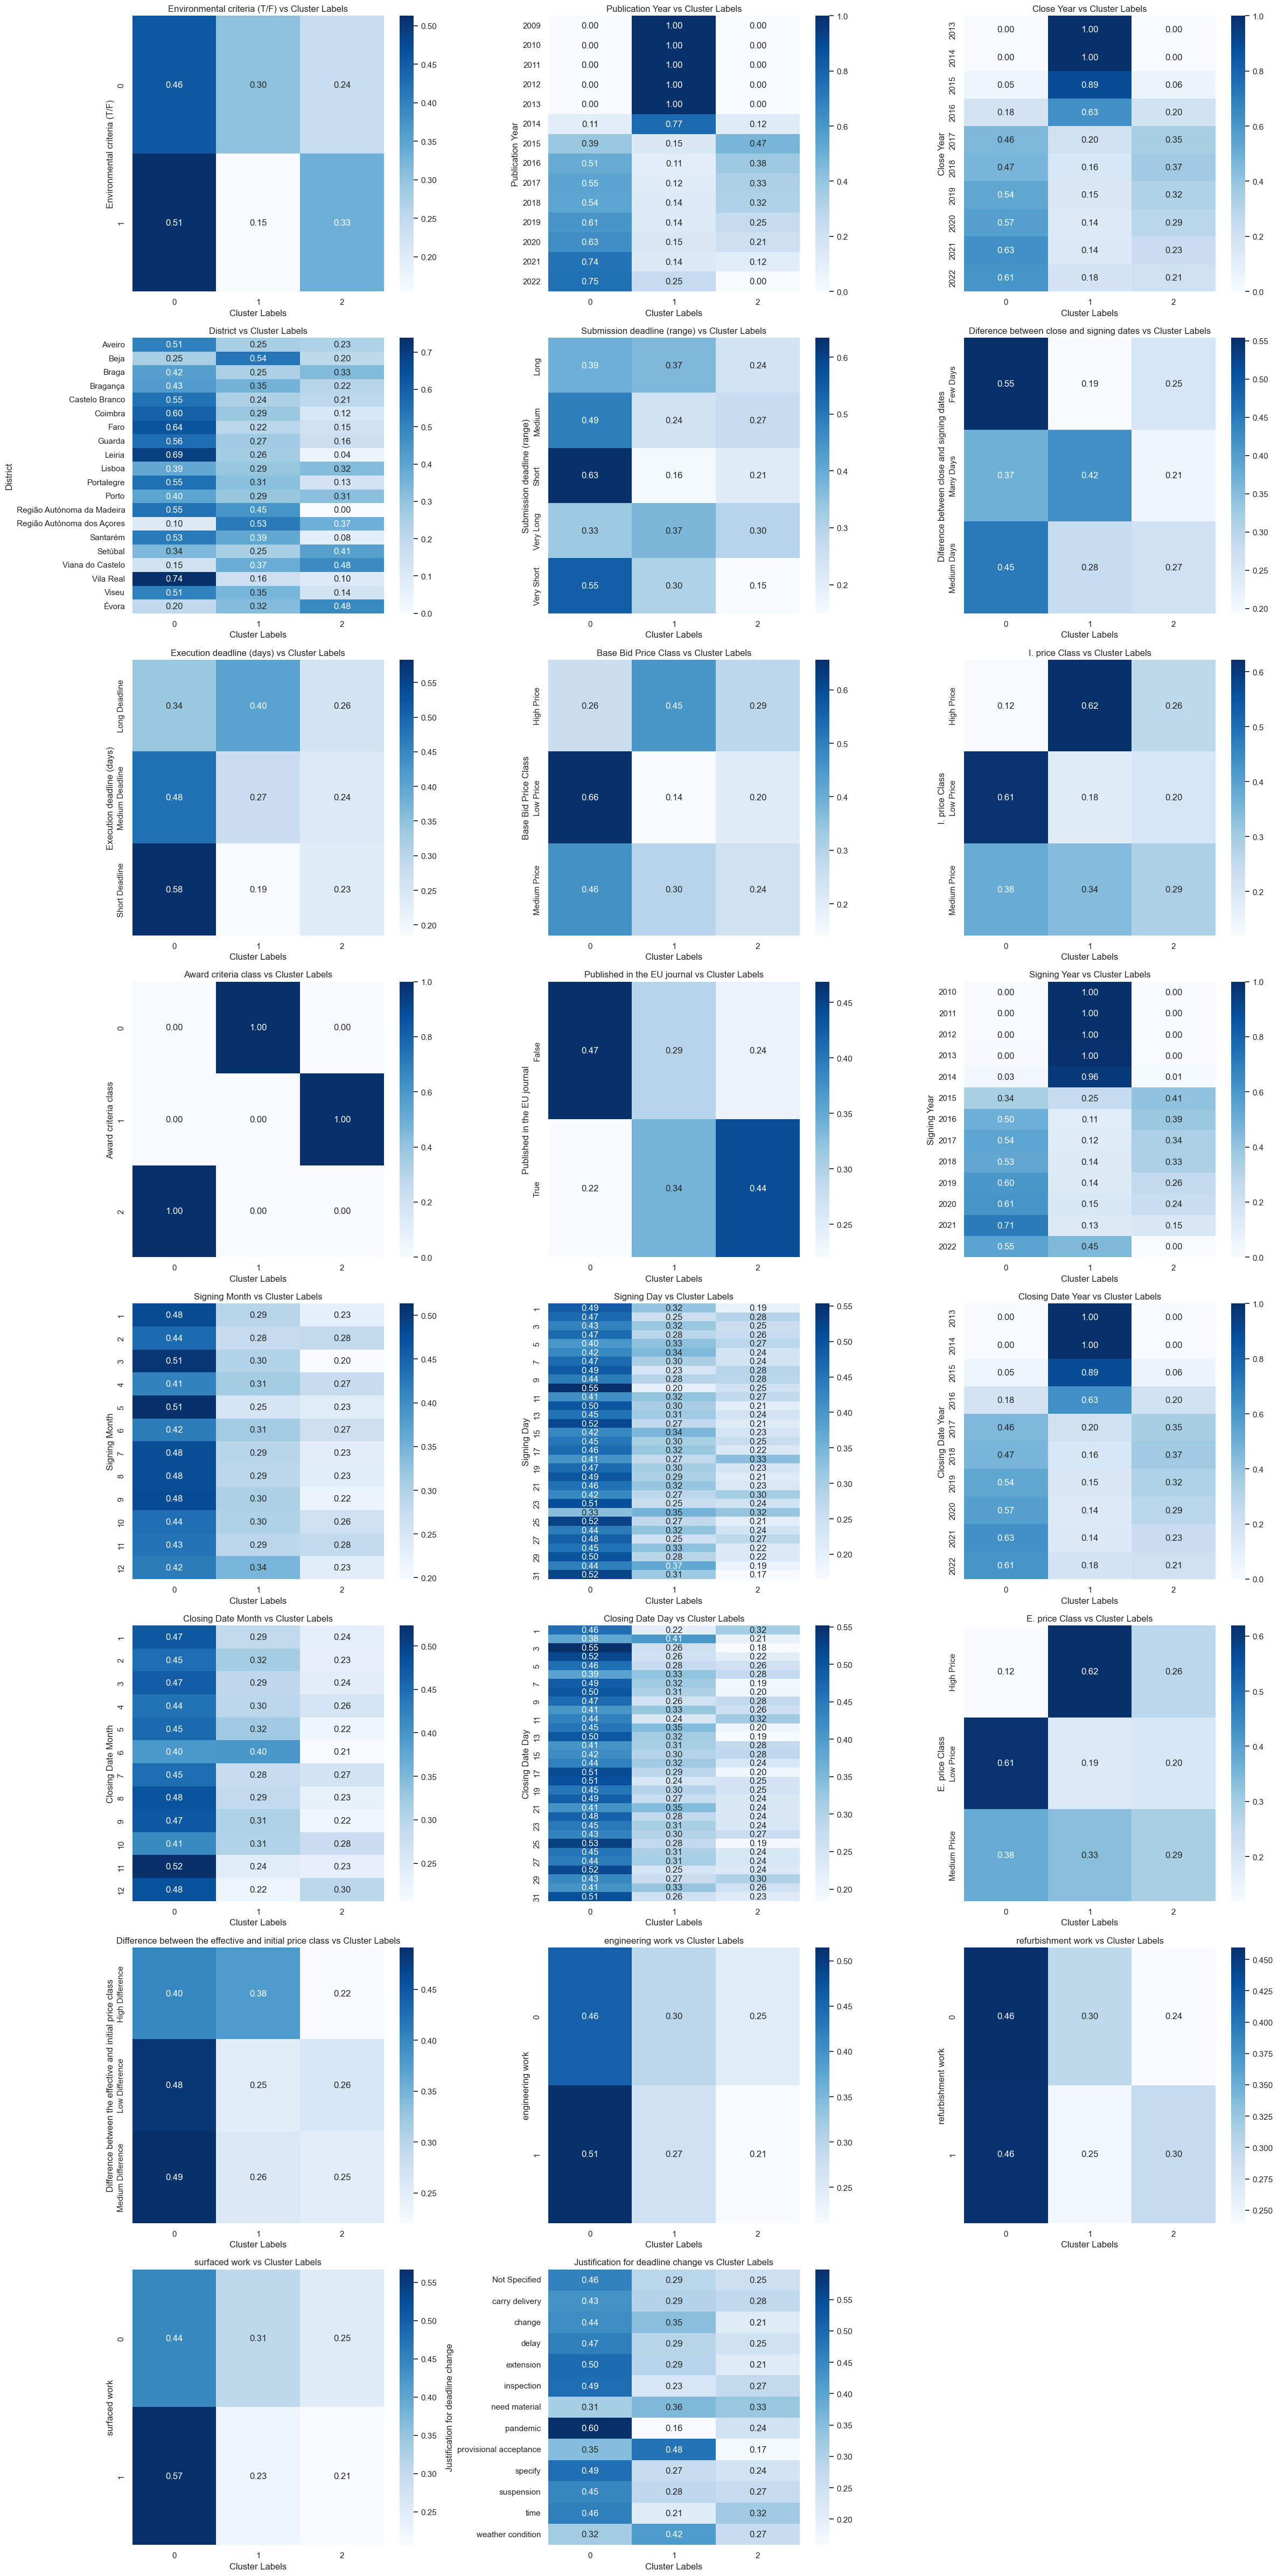

In [64]:
categorical_features = (df.select_dtypes(include=['object', 'bool', 'int64'])).drop(columns=['Municipality']).columns.tolist()
plot_categorical_heatmap(df, categorical_features, df_final_extended['Cluster Labels'], n_cols=3, figsize_per_plot=(8, 6))

### Insights from Categorical Feature Combinations and Frequencies

The following graphs aim to show particular combinations and frequencies of values for each categorical feature associated with the target variable. In addition to the patterns identified earlier using the **countplot**, we observe the following patterns:

1. **Environmental criteria** have a greater influence on **Class 1** (low-cost contracts).
2. **Publication Year** from 2009 to 2014 is dominated by **Class 1** (medium-cost contracts), while in 2021 and 2022, **Class 0** predominates, and in 2015, **Class 3** is the dominant class.
3. **Close Year** follows a similar trend, with **Class 1** predominating from 2013 to 2016.
4. On the **District**, **Class 0** predominates in most cases.
5. The **time** and **price** criteria show the same pattern as observed previously.
6. For the feature **Published in the EU journal**, **Class 0** is mostly associated with "False," while **Class 2** is associated with "True."
7. **Job types** are most influenced by **Class 0**.
8. The **Covid** feature had a greater impact on **Class 0**.

These observations are quite superficial and based solely on the number of occurrences. By studying **association rules**, we can gain a broader view of the relationships within the data.

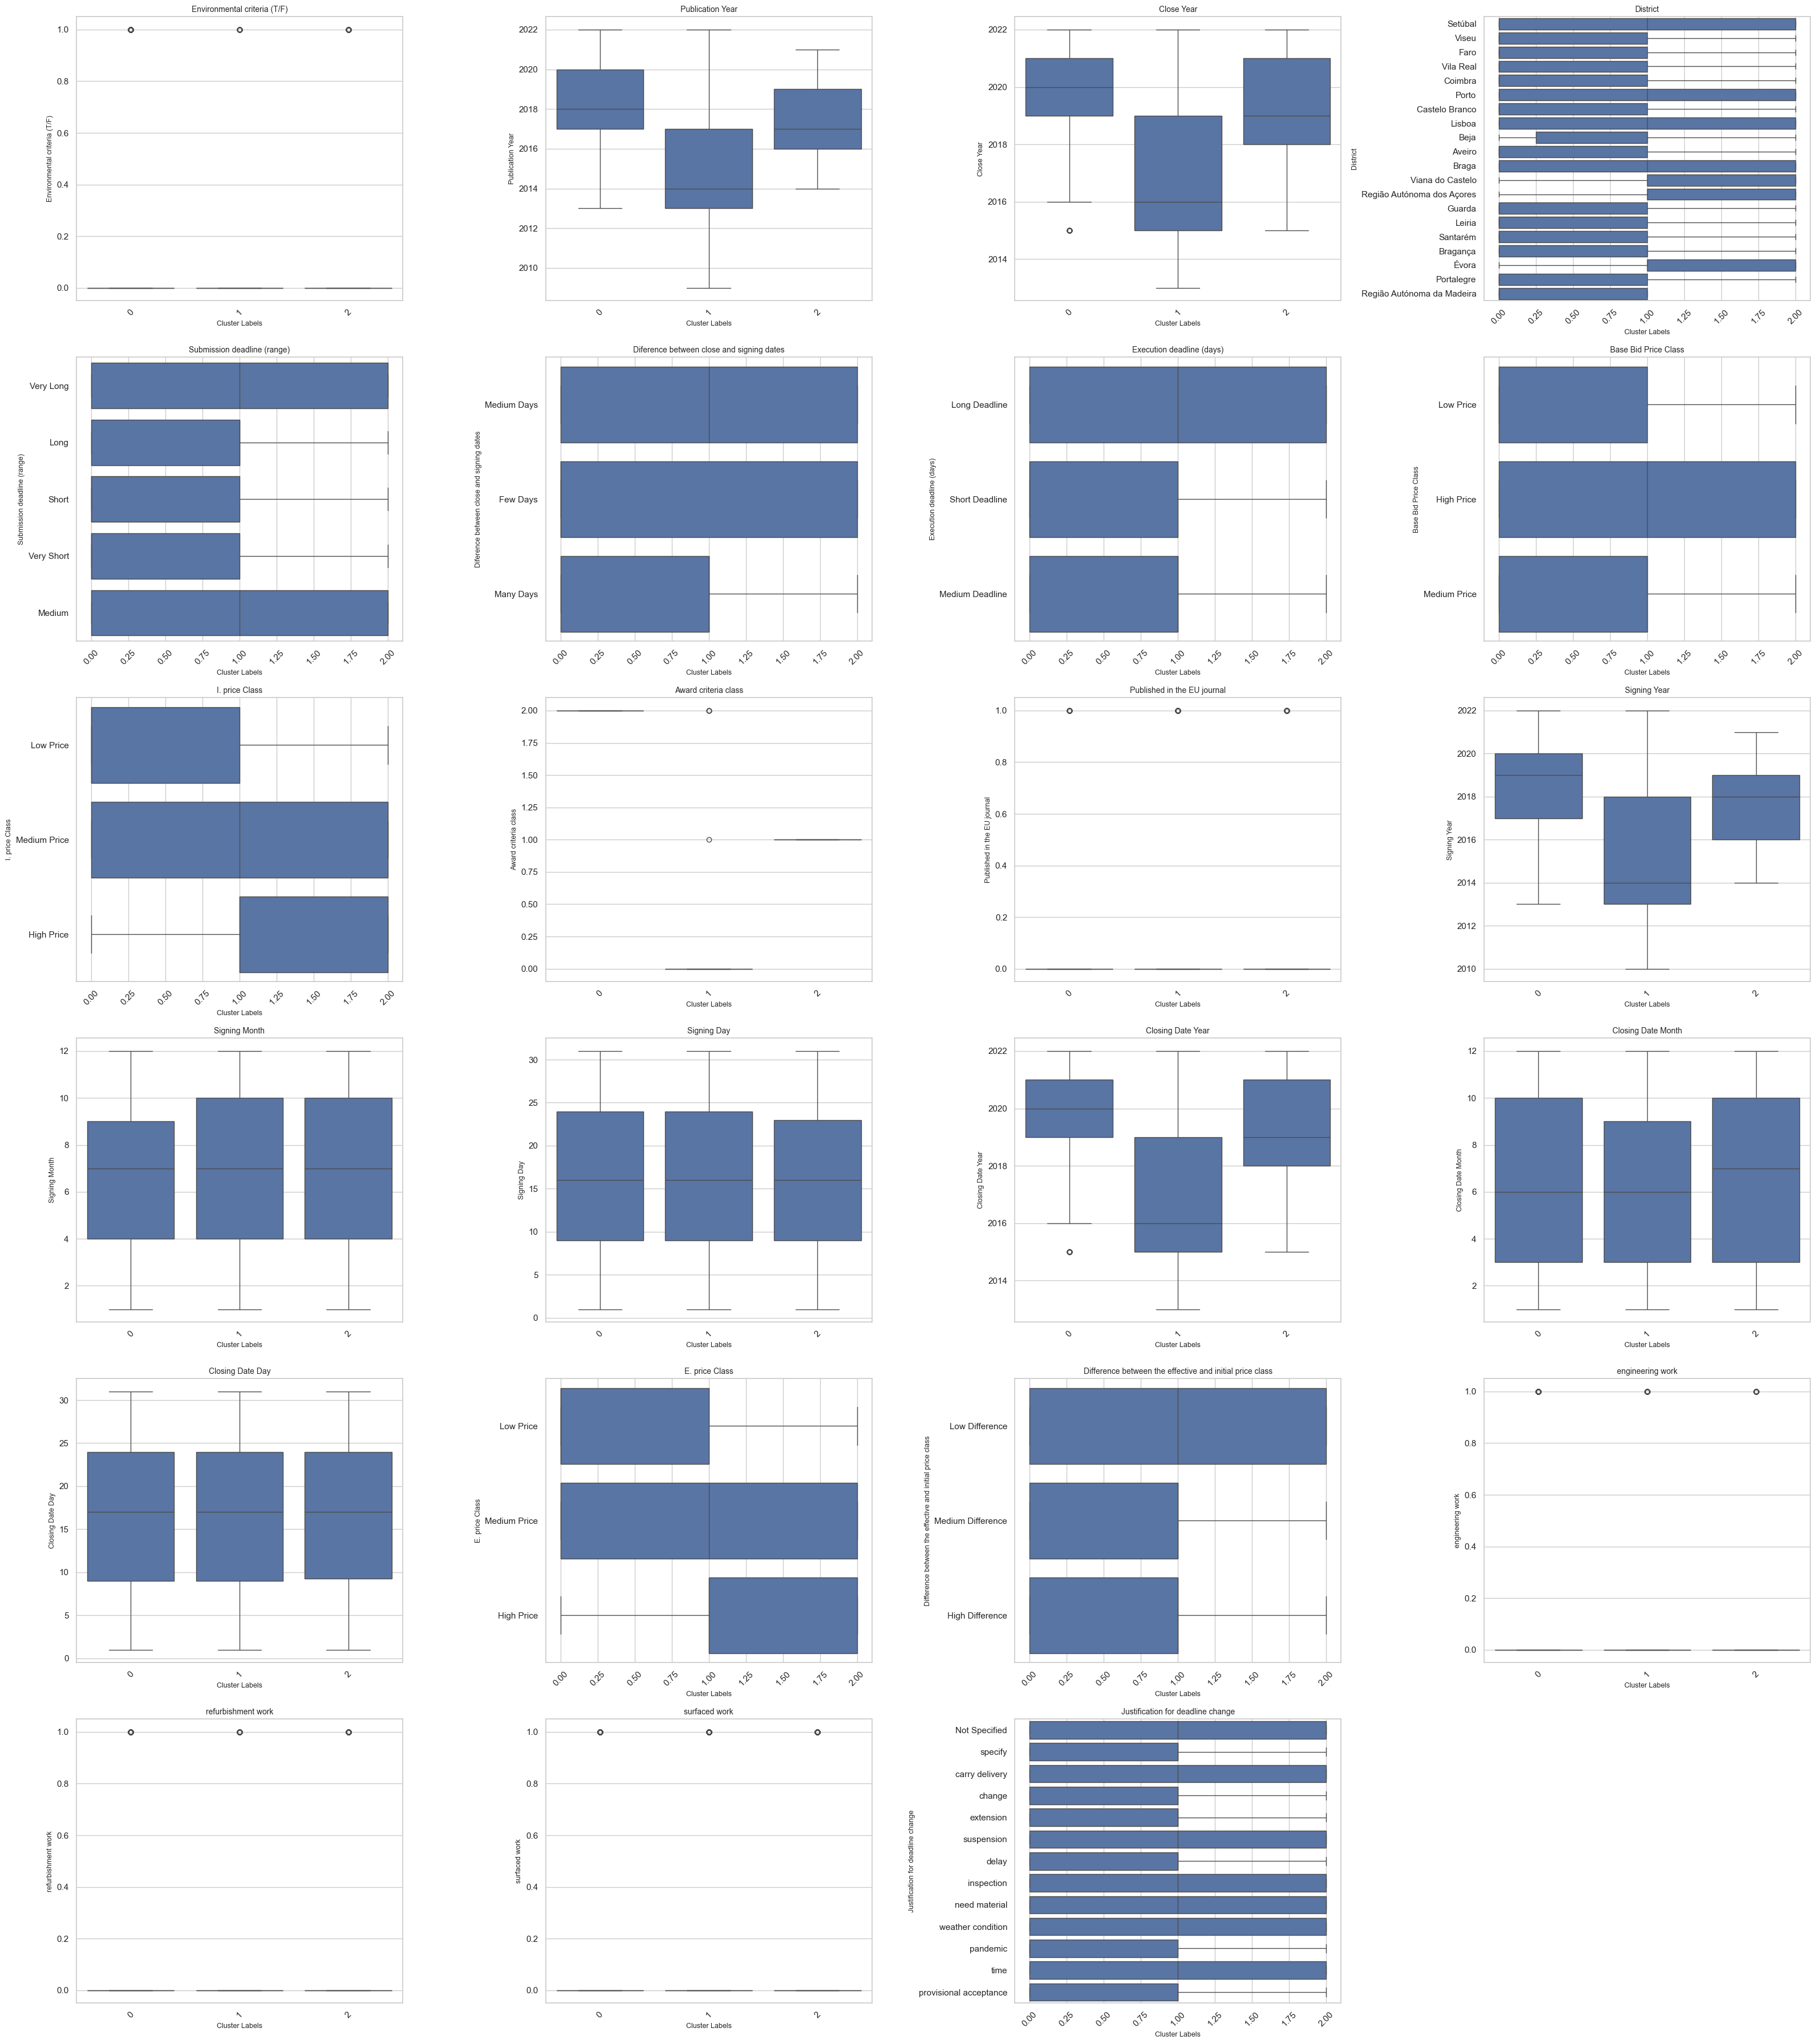

In [65]:
plot_boxplots(df, categorical_features, df_final_extended['Cluster Labels'], n_cols=4, figsize_per_plot=(8, 6))

There are no outliers, except for Publication Year and Close Year but rare sporadic cases.

In [66]:
df_final_extended.to_csv('PPPData_EN_1.0_completed_clustered_before_assosiation_rules.csv', index=False)

# Association Rules

In [67]:
df['Municipality'].nunique()

277

In order to be able to find the Association Rules, it is necessary to have all numeric features, so I will use One-hot Encoding to convert all features except the Municipality feature, as it contains too many values and has almost the same District values, so there is no point in generating 277 additional features and making the pattern mining algorithm more onerous by having the same District information.

In [68]:
df_final_extended = pd.read_csv('PPPData_EN_1.0_completed_clustered_before_assosiation_rules.csv')
try:
    df_final_extended.drop(columns=['Municipality'], inplace=True)
except KeyError:
    pass

To convert all the features concerned, I generate dummies from the variables in df as they have a more explanatory name and I can easily merge them with df_final_extended.

In [69]:
col_drop = df_final_extended.loc[:, df_final_extended.nunique() > 2].columns.to_list()
col_drop = col_drop[:-3] + col_drop[-1:]
df['Cluster Labels'] = df_final_extended['Cluster Labels'].astype(str)
df_final_extended = df_final_extended.drop(columns=col_drop)
df_col_orig = pd.get_dummies(df[col_drop], prefix=[col for col in col_drop])
df.drop(columns=['Cluster Labels'], inplace=True)
df_final_extended = pd.concat([df_final_extended, df_col_orig], axis=1)

col_to_import = ['I. price Class', 'Difference between the effective and initial price class']
df_final_extended[col_to_import] = df[col_to_import]
df_col_import = pd.get_dummies(df_final_extended[col_to_import], prefix=[col for col in col_to_import])
df_final_extended = pd.concat([df_final_extended, df_col_import], axis=1)
df_final_extended = df_final_extended.drop(columns=col_to_import)
df_final_extended.head()

District_Aveiro  District_Beja  District_Braga  District_Bragança  \
0            False          False           False              False   
1            False          False           False              False   
2            False          False           False              False   
3            False          False           False              False   
4            False          False           False              False   

   District_Castelo Branco  District_Coimbra  District_Faro  District_Guarda  \
0                    False             False          False            False   
1                    False             False          False            False   
2                    False             False           True            False   
3                    False             False          False            False   
4                    False             False          False            False   

   District_Leiria  District_Lisboa  ...  \
0            False            False  ...   
1            False            False  ...   
2            False            False  ...   
3            False            False  ...   
4            False            False  ...   

   Execution deadline (days)_Short Deadline  Cluster Labels_0  \
0                                     False              True   
1                                      True              True   
2                                      True             False   
3                                      True              True   
4                                      True              True   

   Cluster Labels_1  Cluster Labels_2  I. price Class_High Price  \
0             False             False                      False   
1             False             False                      False   
2              True             False                      False   
3             False             False                      False   
4             False             False                      False   

   I. price Class_Low Price  I. price Class_Medium Price  \
0                      True                        False   
1                      True                        False   
2                      True                        False   
3                      True                        False   
4                      True                        False   

   Difference between the effective and initial price class_High Difference  \
0                                              False                          
1                                              False                          
2                                              False                          
3                                              False                          
4                                              False                          

   Difference between the effective and initial price class_Low Difference  \
0                                               True                         
1                                              False                         
2                                              False                         
3                                              False                         
4                                              False                         

   Difference between the effective and initial price class_Medium Difference  
0                                              False                           
1                                               True                           
2                                               True                           
3                                               True                           
4                                               True                           

[5 rows x 140 columns]

### Recovering Original Feature Values and Discretization

I retrieve the **MinMaxScaler** used to transform the numerical features so that I can restore the original values. This allows me to apply **equal width** and **equal depth** discretization on the variables `Classification of the multifactor criteria (%)` and `Number of bidders`. I chose this type of discretization based on the analyses conducted in the previous notebook.

In [70]:
scaler = joblib.load('minmax_scaler.joblib')

# Columns to inverse transform
columns_to_inverse_transform = ['Classification of the multifactor criteria (%)', 'Number of bidders']

# Inverse transform the columns
data_to_inverse = df_final_extended[columns_to_inverse_transform]
df_final_extended[columns_to_inverse_transform] = scaler.inverse_transform(data_to_inverse)

# Equal Width Binning for 'Classification of the multifactor criteria (%)'
df_final_extended['Classification Binned'] = pd.cut(
    df_final_extended['Classification of the multifactor criteria (%)'],
    bins=3,
    labels=['Low', 'Average', 'High']
)

# Equal Depth Binning for 'Number of bidders'
df_final_extended['Bidders Binned'] = pd.qcut(
    df_final_extended['Number of bidders'],
    q=3,
    labels=['Low', 'Medium', 'High']
)

col_num = ['Classification of the multifactor criteria (%)', 'Number of bidders']

df_final_extended = df_final_extended.drop(columns=col_num)

df_num_transf = pd.get_dummies(df_final_extended[['Classification Binned', 'Bidders Binned']], prefix=[col for col in col_num])
df_final_extended = pd.concat([df_final_extended, df_num_transf], axis=1)
df_final_extended = df_final_extended.drop(columns=['Classification Binned', 'Bidders Binned'])

day_col = ['Closing Date Day', 'Signing Day']
df_final_extended[day_col] = df[day_col].astype(str)
df_day = pd.get_dummies(df_final_extended[day_col], prefix=[col for col in day_col])
df_final_extended = pd.concat([df_final_extended, df_day], axis=1)
df_final_extended = df_final_extended.drop(columns=day_col)
df_final_extended.head()

c:\Users\dommy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.1.post1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


District_Aveiro  District_Beja  District_Braga  District_Bragança  \
0            False          False           False              False   
1            False          False           False              False   
2            False          False           False              False   
3            False          False           False              False   
4            False          False           False              False   

   District_Castelo Branco  District_Coimbra  District_Faro  District_Guarda  \
0                    False             False          False            False   
1                    False             False          False            False   
2                    False             False           True            False   
3                    False             False          False            False   
4                    False             False          False            False   

   District_Leiria  District_Lisboa  ...  Signing Day_29  Signing Day_3  \
0            False            False  ...           False          False   
1            False            False  ...           False          False   
2            False            False  ...           False          False   
3            False            False  ...           False          False   
4            False            False  ...           False          False   

   Signing Day_30  Signing Day_31  Signing Day_4  Signing Day_5  \
0           False           False          False          False   
1           False           False          False          False   
2           False           False          False          False   
3           False           False          False          False   
4           False           False          False          False   

   Signing Day_6  Signing Day_7  Signing Day_8  Signing Day_9  
0          False          False          False          False  
1          False          False          False          False  
2          False          False          False          False  
3          False          False           True          False  
4          False          False          False          False  

[5 rows x 206 columns]

In [71]:
df_final_extended.to_csv('PPPData_EN_1.0_completed_clustered_association_rules_days.csv', index=False)

In [72]:
df_final_extended = pd.read_csv('PPPData_EN_1.0_completed_clustered_association_rules_days.csv')

### Association Rule Mining Analysis

#### Key Metrics: Support and Confidence

Two of the main metrics used to evaluate the quality of association rules are **support** and **confidence**:

- **Support** ($Support$): Measures the frequency with which an itemset appears in the dataset. A high support indicates that the itemset is common, while a low support suggests that it is rare. The formula is:

  $$
  Support(I) = \frac{|I|}{N}
  $$

  Where $I$ is the itemset and $N$ is the total number of transactions.

- **Confidence** ($Confidence$): Measures the probability that $B$ is present in the dataset given that $A$ is already present (conditional probability). It is calculated as:

  $$
  Confidence(A \rightarrow B) = \frac{Support(A \cup B)}{Support(A)}
  $$

  High confidence suggests that the presence of $A$ strongly implies the presence of $B$.

#### Apriori Algorithm

The **Apriori algorithm** is one of the most well-known methods for association rule mining. It works by exhaustively searching for all possible candidate itemsets, gradually eliminating those that do not meet a minimum support threshold using the **closure property**. Apriori follows the principle that if an itemset is frequent, all of its subsets must also be frequent, thus reducing the search space. However, the main disadvantage of Apriori is that it can become inefficient with very large or high-dimensional datasets, as it generates all possible candidate itemsets, increasing execution time.

#### FP-Growth Algorithm

The **FP-Growth algorithm** (Frequent Pattern Growth) improves efficiency over Apriori by constructing a tree-like structure called the **FP-tree**, which represents frequent patterns compactly. The algorithm avoids the explicit generation of candidates and uses a divide-and-conquer approach to explore frequent patterns, significantly reducing execution time, especially with large datasets.

#### Considerations on Using Apriori vs FP-Growth

In my case, I am working with a dataset containing around 200 features. Given the dataset size, which is not very large, I would use the Apriori algorithm since it generates many candidates, and computation time is not a significant concern.

### Definition of Lift:

Lift takes into account the probability that the consequents may occur "by chance." Even if a rule has high confidence, lift helps determine if the rule is truly interesting or merely reflects a natural probability in the dataset.

The formula for **lift** is:

$$
\text{Lift} = \frac{\text{Confidence}(A \rightarrow B)}{\text{Support}(B)}
$$

Where:
- $\text{Confidence}(A \rightarrow B)$ is the conditional probability that item $B$ is present given that item $A$ is present.
- $\text{Support}(B)$ is the probability that item $B$ is present in the dataset.

### Interpretation:
- **Lift > 1**: The antecedents and consequents are positively correlated. This means that the presence of the antecedents increases the likelihood of the consequents being present, more than what we would expect if they were independent. In other words, the rule is useful and has strong predictive power.

- **Lift = 1**: The antecedents and consequents are independent. The rule is not useful because the co-occurrence of $A$ and $B$ is exactly what we would expect if they were completely unrelated events.

- **Lift < 1**: The antecedents and consequents are negatively correlated. In this case, the presence of the antecedents makes the presence of the consequents less likely, indicating that the rule has low utility or may even be misleading.

I define the **minimum support** (`min_sup`) as **0.05** to identify rare itemsets, and the **minimum confidence** (`min_conf`) as **0.4** to ensure a sufficiently high confidence to uncover hidden patterns.

- **min_sup = 0.05**: This threshold helps in identifying itemsets that occur at least 5% of the time in the dataset. Lower values allow for more frequent patterns, while higher values focus on rarer patterns.
  
- **min_conf = 0.4**: This threshold ensures that the rules we extract have at least 40% confidence, making them more reliable for further analysis of potential patterns.

In [73]:
min_sup = 0.05
min_conf = 0.4

## Senza Cluster Labels

In [74]:
df_final_without_clusters = df_final_extended.drop(columns=['Cluster Labels_0', 'Cluster Labels_1', 'Cluster Labels_2'])
frequent_itemsets_without_clusters = apriori(df_final_without_clusters, min_support=min_sup, use_colnames=True)
rules_without_clusters = association_rules(frequent_itemsets_without_clusters, metric='confidence', min_threshold=min_conf)
rules_without_clusters.drop(columns=['antecedent support', 'consequent support', 'leverage', 'conviction', 'zhangs_metric'], inplace=True)
rules_without_clusters.head()

antecedents                                        consequents  \
0  (District_Aveiro)                           (Award criteria class_2)   
1  (District_Aveiro)                         (E. price Class_Low Price)   
2  (District_Aveiro)            (Submission deadline (range)_Very Long)   
3  (District_Aveiro)                         (I. price Class_Low Price)   
4  (District_Aveiro)  (Classification of the multifactor criteria (%...   

    support  confidence      lift  representativity   jaccard  certainty  \
0  0.050233    0.513458  1.115731               1.0  0.098923   0.098664   
1  0.051853    0.530021  1.138196               1.0  0.101346   0.120437   
2  0.052461    0.536232  1.752069               1.0  0.149280   0.331692   
3  0.050233    0.513458  1.107928               1.0  0.098296   0.093220   
4  0.056309    0.575569  1.098410               1.0  0.099570   0.108334   

   kulczynski  
0    0.311306  
1    0.320687  
2    0.353821  
3    0.310925  
4    0.341515

In [75]:
rules_without_clusters.to_csv('association_rules_without_clusters.csv', index=False)

**Below we will analyse a number of probable pattern associations**.

### Higher Effective Price than Initial -> Multifactor Award Criteria

In [76]:
search_criteria = [
    {'column': 'consequents', 'substrings': ["Award criteria class_1"], 'search_type': 'consequents'},
    {'column': 'antecedents', 'substrings': ["Difference between the effective and initial price"], 'search_type': 'antecedents'},
]

filtered_rules = search_rules_by_multiple_substrings(rules_without_clusters, search_criteria)
filtered_rules

antecedents  \
878  (Difference between the effective and initial ...   
880  (Difference between the effective and initial ...   
882  (Classification of the multifactor criteria (%...   

                  consequents   support  confidence      lift  \
878  (Award criteria class_1)  0.053271         1.0  4.090307   
880  (Award criteria class_1)  0.059348         1.0  4.090307   
882  (Award criteria class_1)  0.064006         1.0  4.090307   

     representativity   jaccard  certainty  kulczynski  
878               1.0  0.217896        1.0    0.608948  
880               1.0  0.242751        1.0    0.621375  
882               1.0  0.261806        1.0    0.630903

In [77]:
filter_rules_with_mapping(rules_without_clusters, search_criteria)

Difference between the effective and initial price class_High Difference, Classification of the multifactor criteria (%)_Average -> Award criteria class_1


Difference between the effective and initial price class_Low Difference, Classification of the multifactor criteria (%)_Average -> Award criteria class_1


Classification of the multifactor criteria (%)_Average, Difference between the effective and initial price class_Medium Difference -> Award criteria class_1




If there is a difference between the initial price and the actual price, it is highly likely that the adopted criterion is multifactorial. Although the support is relatively rare, the confidence rate is equal to 1, accompanied by an excellent lift value.

These results indicate that the association is not random but rather stable. When it occurs, there is a significant correlation between the variables involved.

This is because if the price has undergone a considerable fluctuation from the beginning to the end, it could be due to the multifactorial criterion.

### If the awarding criterion is based solely on the "lowest price", the actual price tends to be very close to the initial price.

In [78]:
search_criteria = [
    {'column': 'consequents', 'substrings': ["Difference between the effective and initial price class_Low Difference"], 'search_type': 'consequents'},
    {'column': 'antecedents', 'substrings': ["Award criteria class_2"], 'search_type': 'antecedents'},
]

filtered_rules = search_rules_by_multiple_substrings(rules_without_clusters, search_criteria)
filtered_rules

antecedents  \
1174  (E. price Class_Medium Price, Award criteria c...   
1296  (Diference between close and signing dates_Man...   
5523  (E. price Class_Medium Price, Classification o...   
5526  (E. price Class_Medium Price, Award criteria c...   
5929  (Diference between close and signing dates_Man...   
5931  (Diference between close and signing dates_Man...   

                                            consequents   support  confidence  \
1174  (Difference between the effective and initial ...  0.065019    0.403266   
1296  (Difference between the effective and initial ...  0.055297    0.453488   
5523  (Difference between the effective and initial ...  0.065019    0.403266   
5526  (Difference between the effective and initial ...  0.065019    0.403266   
5929  (Difference between the effective and initial ...  0.055297    0.453488   
5931  (Difference between the effective and initial ...  0.055297    0.453488   

          lift  representativity   jaccard  certainty  kulczynski  
1174  1.315010               1.0  0.161388   0.139330    0.307644  
1296  1.478779               1.0  0.148128   0.211765    0.316903  
5523  1.315010               1.0  0.161388   0.139330    0.307644  
5526  2.381490               1.0  0.244851   0.281621    0.393619  
5929  1.478779               1.0  0.148128   0.211765    0.316903  
5931  2.678077               1.0  0.234335   0.342080    0.390022

In [79]:
filter_rules_with_mapping(rules_without_clusters, search_criteria)

E. price Class_Medium Price, Award criteria class_2 -> Difference between the effective and initial price class_Low Difference


Diference between close and signing dates_Many Days, Award criteria class_2 -> Difference between the effective and initial price class_Low Difference


E. price Class_Medium Price, Classification of the multifactor criteria (%)_High, Award criteria class_2 -> Difference between the effective and initial price class_Low Difference


E. price Class_Medium Price, Award criteria class_2 -> Difference between the effective and initial price class_Low Difference, Classification of the multifactor criteria (%)_High


Diference between close and signing dates_Many Days, Award criteria class_2, Classification of the multifactor criteria (%)_High -> Difference between the effective and initial price class_Low Difference


Diference between close and signing dates_Many Days, Award criteria class_2 -> Difference between the effective and initial price class_Low Differen

Despite a relatively low support for these associations, the confidence and lift values indicate that there is a significant relationship between the actual price and the initial price when the awarding criterion is based on the lowest price. In particular, the lift greater than 1 suggests that the associations are not random, and when this condition occurs, it is likely that the actual price remains close to the initial price.  
It is a weaker relationship compared to the previous one due to the low confidence, but still relevant.  
Moreover, an actual price similar to the initial price is influenced not only by the "lowest price" award criterion but also by the number of days that pass between the close and signing dates.

In [80]:
search_criteria = [
    {'column': 'consequents', 'substrings': ["Award criteria class_2"], 'search_type': 'consequents'},
    {'column': 'antecedents', 'substrings': ["Difference between the effective and initial price class_Low Difference"], 'search_type': 'antecedents'},
]

filtered_rules = search_rules_by_multiple_substrings(rules_without_clusters, search_criteria).sort_values(by='confidence', ascending=False)
filtered_rules

antecedents  \
6042   (Difference between the effective and initial ...   
15465  (Classification of the multifactor criteria (%...   
15474  (E. price Class_Low Price, Difference between ...   
11139  (E. price Class_Low Price, Difference between ...   
11563  (E. price Class_Low Price, Difference between ...   
...                                                  ...   
1361   (I. price Class_Medium Price, Difference betwe...   
5501   (I. price Class_Medium Price, Difference betwe...   
11779  (I. price Class_Medium Price, Difference betwe...   
5502   (Difference between the effective and initial ...   
11780  (Difference between the effective and initial ...   

                                             consequents   support  \
6042                            (Award criteria class_2)  0.082034   
15465                           (Award criteria class_2)  0.061576   
15474  (Award criteria class_2, I. price Class_Low Pr...  0.061576   
11139                           (Award criteria class_2)  0.061576   
11563  (Award criteria class_2, I. price Class_Low Pr...  0.076160   
...                                                  ...       ...   
1361                            (Award criteria class_2)  0.059753   
5501   (E. price Class_Medium Price, Award criteria c...  0.059145   
11779  (E. price Class_Medium Price, Award criteria c...  0.059145   
5502   (I. price Class_Medium Price, Award criteria c...  0.059145   
11780  (I. price Class_Medium Price, Award criteria c...  0.059145   

       confidence      lift  representativity   jaccard  certainty  kulczynski  
6042     0.916290  1.991075               1.0  0.175401   0.844924    0.547273  
15465    0.915663  1.989712               1.0  0.132174   0.843762    0.524733  
15474    0.915663  3.215239               1.0  0.211994   0.882081    0.565939  
11139    0.915663  1.989712               1.0  0.132174   0.843762    0.524733  
11563    0.914842  3.212357               1.0  0.260930   0.880933    0.591134  
...           ...       ...               ...       ...        ...         ...  
1361     0.427536  0.929026               1.0  0.110611  -0.060508    0.278689  
5501     0.423188  2.624725               1.0  0.244556   0.312311    0.395011  
11779    0.423188  2.624725               1.0  0.244556   0.312311    0.395011  
5502     0.400549  2.474980               1.0  0.236246   0.284802    0.383003  
11780    0.400549  2.474980               1.0  0.236246   0.284802    0.383003  

[93 rows x 9 columns]

In [81]:
filter_rules_with_mapping(rules_without_clusters, search_criteria)

Difference between the effective and initial price class_Low Difference -> Award criteria class_2


E. price Class_Low Price, Difference between the effective and initial price class_Low Difference -> Award criteria class_2


Difference between the effective and initial price class_Low Difference, E. price Class_Medium Price -> Award criteria class_2


Difference between the effective and initial price class_Low Difference, Base Bid Price Class_Low Price -> Award criteria class_2


Difference between the effective and initial price class_Low Difference, Base Bid Price Class_Medium Price -> Award criteria class_2


Difference between the effective and initial price class_Low Difference, Diference between close and signing dates_Many Days -> Award criteria class_2


Diference between close and signing dates_Medium Days, Difference between the effective and initial price class_Low Difference -> Award criteria class_2


Difference between the effective and initial price class_Low Differenc

On the other hand, the opposite scenario is much more likely. In fact, there are several association rules, both with a higher minimum support level and better confidence and lift.  
Therefore, we can say that the actual price tends to be very close to the initial price when the awarding criterion is based solely on the "lowest price".  
There are also some associations related to the Execution Deadline, although they occur rarely.

### Environmental criteria have been considered, and there is a higher probability that the contract was published in an EU journal.

In [82]:
association_rules(apriori(df_final_without_clusters[["Published in the EU journal", "Environmental criteria (T/F)"]], min_support=0.004, use_colnames=True), metric='confidence', min_threshold=0.1)

antecedents                     consequents  \
0  (Published in the EU journal)  (Environmental criteria (T/F))   

   antecedent support  consequent support   support  confidence      lift  \
0            0.037675            0.054892  0.004254    0.112903  2.056838   

   representativity  leverage  conviction  zhangs_metric   jaccard  certainty  \
0               1.0  0.002186    1.065395       0.533933  0.048165   0.061381   

   kulczynski  
0    0.095197

This is the only case, but it is both very rare (0.4%) and, more importantly, not always confirmed (based on the confidence). This is partly explained by the fact that the majority of values are False, which dominate both classes.  
However, it is an association that would make sense given the EU funding.

### Contracts with environmental criteria tend to have more participants.

In [83]:
association_rules(apriori(df_final_without_clusters[["Number of bidders_Low", "Number of bidders_Medium", "Number of bidders_High", "Environmental criteria (T/F)"]], min_support=0.004, use_colnames=True), metric='confidence', min_threshold=0.1)

antecedents                 consequents  \
0  (Environmental criteria (T/F))     (Number of bidders_Low)   
1  (Environmental criteria (T/F))  (Number of bidders_Medium)   
2  (Environmental criteria (T/F))    (Number of bidders_High)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.054892            0.367227  0.019648    0.357934  0.974693   
1            0.054892            0.331780  0.027345    0.498155  1.501460   
2            0.054892            0.300993  0.007900    0.143911  0.478123   

   representativity  leverage  conviction  zhangs_metric   jaccard  certainty  \
0               1.0 -0.000510    0.985526      -0.026738  0.048817  -0.014687   
1               1.0  0.009133    1.331526       0.353379  0.076099   0.248982   
2               1.0 -0.008622    0.816513      -0.535943  0.022701  -0.224720   

   kulczynski  
0    0.205718  
1    0.290286  
2    0.085078

The only relevant case occurs when contracts with environmental criteria influence about half of the participants. In this case, the support reaches 3%, and both confidence and lift are quite good.  

From this, it can be inferred that the issue lies in the "environmental criteria" variable, which is highly imbalanced. This imbalance makes it difficult to identify patterns unless with very low support.

Now, to clear up any doubts, let's check which variables match with the **Environmental Criteria**. To do this, given the complexity, I will use **FP-Growth**, which is more efficient than **Apriori** when we need to iterate over large datasets.

In [84]:
frequent_itemsets = fpgrowth(df_final_without_clusters, min_support=0.02, use_colnames=True)
filtered_rules_ev = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.03, support_only=True).sort_values(by='support', ascending=False)
filtered_rules_ev.head()

antecedents  \
13      (Classification of the multifactor criteria (%...   
12                               (Award criteria class_2)   
2                              (E. price Class_Low Price)   
3                              (I. price Class_Low Price)   
112487                      (E. price Class_Medium Price)   

                                              consequents  antecedent support  \
13                               (Award criteria class_2)                 NaN   
12      (Classification of the multifactor criteria (%...                 NaN   
2                              (I. price Class_Low Price)                 NaN   
3                              (E. price Class_Low Price)                 NaN   
112487                      (I. price Class_Medium Price)                 NaN   

        consequent support   support  confidence  lift  representativity  \
13                     NaN  0.460199         NaN   NaN               NaN   
12                     NaN  0.460199         NaN   NaN               NaN   
2                      NaN  0.451691         NaN   NaN               NaN   
3                      NaN  0.451691         NaN   NaN               NaN   
112487                 NaN  0.413409         NaN   NaN               NaN   

        leverage  conviction  zhangs_metric  jaccard  certainty  kulczynski  
13           NaN         NaN            NaN      NaN        NaN         NaN  
12           NaN         NaN            NaN      NaN        NaN         NaN  
2            NaN         NaN            NaN      NaN        NaN         NaN  
3            NaN         NaN            NaN      NaN        NaN         NaN  
112487       NaN         NaN            NaN      NaN        NaN         NaN

In [85]:
search_criteria = [
    {'column': 'consequents', 'substrings': ["Environmental criteria (T/F)"], 'search_type': 'both'}]

filtered_rules = search_rules_by_multiple_substrings(filtered_rules_ev, search_criteria).sort_values(by='confidence', ascending=False)
filtered_rules

C:\Users\dommy\AppData\Local\Temp\ipykernel_9076\3779978393.py:434: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return rules[filtered_rules]


antecedents  \
109875                         (I. price Class_Low Price)   
109874                     (Environmental criteria (T/F))   
109877                     (Environmental criteria (T/F))   
109876                         (E. price Class_Low Price)   
109885                         (I. price Class_Low Price)   
109884                     (Environmental criteria (T/F))   
109883                         (E. price Class_Low Price)   
109882  (I. price Class_Low Price, Environmental crite...   
109881  (E. price Class_Low Price, I. price Class_Low ...   
109880  (E. price Class_Low Price, Environmental crite...   
109878  (Classification of the multifactor criteria (%...   
109879                     (Environmental criteria (T/F))   

                                              consequents  antecedent support  \
109875                     (Environmental criteria (T/F))                 NaN   
109874                         (I. price Class_Low Price)                 NaN   
109877                         (E. price Class_Low Price)                 NaN   
109876                     (Environmental criteria (T/F))                 NaN   
109885  (E. price Class_Low Price, Environmental crite...                 NaN   
109884  (E. price Class_Low Price, I. price Class_Low ...                 NaN   
109883  (I. price Class_Low Price, Environmental crite...                 NaN   
109882                         (E. price Class_Low Price)                 NaN   
109881                     (Environmental criteria (T/F))                 NaN   
109880                         (I. price Class_Low Price)                 NaN   
109878                     (Environmental criteria (T/F))                 NaN   
109879  (Classification of the multifactor criteria (%...                 NaN   

        consequent support   support  confidence  lift  representativity  \
109875                 NaN  0.035649         NaN   NaN               NaN   
109874                 NaN  0.035649         NaN   NaN               NaN   
109877                 NaN  0.035042         NaN   NaN               NaN   
109876                 NaN  0.035042         NaN   NaN               NaN   
109885                 NaN  0.034636         NaN   NaN               NaN   
109884                 NaN  0.034636         NaN   NaN               NaN   
109883                 NaN  0.034636         NaN   NaN               NaN   
109882                 NaN  0.034636         NaN   NaN               NaN   
109881                 NaN  0.034636         NaN   NaN               NaN   
109880                 NaN  0.034636         NaN   NaN               NaN   
109878                 NaN  0.032813         NaN   NaN               NaN   
109879                 NaN  0.032813         NaN   NaN               NaN   

        leverage  conviction  zhangs_metric  jaccard  certainty  kulczynski  
109875       NaN         NaN            NaN      NaN        NaN         NaN  
109874       NaN         NaN            NaN      NaN        NaN         NaN  
109877       NaN         NaN            NaN      NaN        NaN         NaN  
109876       NaN         NaN            NaN      NaN        NaN         NaN  
109885       NaN         NaN            NaN      NaN        NaN         NaN  
109884       NaN         NaN            NaN      NaN        NaN         NaN  
109883       NaN         NaN            NaN      NaN        NaN         NaN  
109882       NaN         NaN            NaN      NaN        NaN         NaN  
109881       NaN         NaN            NaN      NaN        NaN         NaN  
109880       NaN         NaN            NaN      NaN        NaN         NaN  
109878       NaN         NaN            NaN      NaN        NaN         NaN  
109879       NaN         NaN            NaN      NaN        NaN         NaN

There is too little information here, so we cannot deduce anything

### Difference between actual and initial price is greater than 20%, more likely there was a justification for changing the deadline

Since the feature `Proportion between the effective and initial price (%)` was eliminated during feature selection because it didn't provide any additional contribution compared to `Difference between the effective and initial price`, I will try to recover it and check if there are any matching patterns.  
To do this, I need to load an old dataset and the associated scaler.

In [86]:
df_proportion = pd.read_csv('PPPData_EN_cleaned_imputed.csv')
proportion_values = df_proportion[['Proportion between the effective and initial price (%)']].values
scaler = joblib.load('minmax_scaler_prop.joblib')
proportion_values_original = scaler.inverse_transform(proportion_values)
df_proportion['Proportion between the effective and initial price (%)'] = proportion_values_original

c:\Users\dommy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.1.post1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


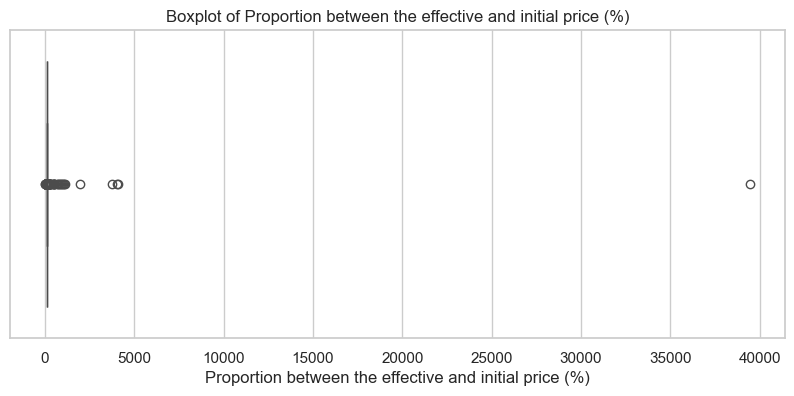

In [87]:
# Plot the boxplot for Submission deadline (days)
plt.figure(figsize=(10, 4))
sns.boxplot(x=df_proportion['Proportion between the effective and initial price (%)'])
plt.title('Boxplot of Proportion between the effective and initial price (%)')
plt.xlabel('Proportion between the effective and initial price (%)')
plt.show()

In [88]:
num_bins = 3

# Equal Depth Binning
df_proportion['Proportion_binned'] = pd.qcut(
    df_proportion['Proportion between the effective and initial price (%)'], 
    q=num_bins, 
    labels=['Under 100% ', '100%', 'Over 100%'],
)

res = df_proportion['Proportion_binned']
res.value_counts()

df_prop = pd.get_dummies(df_proportion['Proportion_binned'], prefix='Proportion between the effective and initial price_')

df_prop_final_extended = df_final_extended.copy()

df_prop_final_extended = pd.concat([df_prop_final_extended, df_prop], axis=1)
df_prop_final_extended.head()

District_Aveiro  District_Beja  District_Braga  District_Bragança  \
0            False          False           False              False   
1            False          False           False              False   
2            False          False           False              False   
3            False          False           False              False   
4            False          False           False              False   

   District_Castelo Branco  District_Coimbra  District_Faro  District_Guarda  \
0                    False             False          False            False   
1                    False             False          False            False   
2                    False             False           True            False   
3                    False             False          False            False   
4                    False             False          False            False   

   District_Leiria  District_Lisboa  ...  Signing Day_31  Signing Day_4  \
0            False            False  ...           False          False   
1            False            False  ...           False          False   
2            False            False  ...           False          False   
3            False            False  ...           False          False   
4            False            False  ...           False          False   

   Signing Day_5  Signing Day_6  Signing Day_7  Signing Day_8  Signing Day_9  \
0          False          False          False          False          False   
1          False          False          False          False          False   
2          False          False          False          False          False   
3          False          False          False           True          False   
4          False          False          False          False          False   

   Proportion between the effective and initial price__Under 100%   \
0                                               True                 
1                                               True                 
2                                               True                 
3                                               True                 
4                                               True                 

   Proportion between the effective and initial price__100%  \
0                                              False          
1                                              False          
2                                              False          
3                                              False          
4                                              False          

   Proportion between the effective and initial price__Over 100%  
0                                              False              
1                                              False              
2                                              False              
3                                              False              
4                                              False              

[5 rows x 209 columns]

In [89]:
df_final_without_clusters_prop = df_prop_final_extended.drop(columns=['Cluster Labels_0', 'Cluster Labels_1', 'Cluster Labels_2'])
frequent_itemsets_without_clusters_prop = apriori(df_final_without_clusters_prop, min_support=min_sup, use_colnames=True)
rules_without_clusters_prop = association_rules(frequent_itemsets_without_clusters_prop, metric='confidence', min_threshold=min_conf)
rules_without_clusters_prop.drop(columns=['antecedent support', 'consequent support', 'leverage', 'conviction', 'zhangs_metric'], inplace=True)
rules_without_clusters_prop.head()

antecedents                                        consequents  \
0  (District_Aveiro)                           (Award criteria class_2)   
1  (District_Aveiro)                         (E. price Class_Low Price)   
2  (District_Aveiro)            (Submission deadline (range)_Very Long)   
3  (District_Aveiro)                         (I. price Class_Low Price)   
4  (District_Aveiro)  (Classification of the multifactor criteria (%...   

    support  confidence      lift  representativity   jaccard  certainty  \
0  0.050233    0.513458  1.115731               1.0  0.098923   0.098664   
1  0.051853    0.530021  1.138196               1.0  0.101346   0.120437   
2  0.052461    0.536232  1.752069               1.0  0.149280   0.331692   
3  0.050233    0.513458  1.107928               1.0  0.098296   0.093220   
4  0.056309    0.575569  1.098410               1.0  0.099570   0.108334   

   kulczynski  
0    0.311306  
1    0.320687  
2    0.353821  
3    0.310925  
4    0.341515

Justification for price change I removed it because it had too many Null values, so I am changing this feature to Justification for deadline change.

In [90]:
search_criteria = [
    {'column': 'antecedents', 'substrings': ["Justification for deadline change"], 'search_type': 'antecedents'},
    {'column': 'consequents', 'substrings': ["Proportion between the effective and initial price__Under 100%"], 'search_type': 'consequents'},
]

filtered_rules = search_rules_by_multiple_substrings(rules_without_clusters_prop, search_criteria).sort_values(by='confidence', ascending=False)
filtered_rules

antecedents  \
2887   (Difference between the effective and initial ...   
2919   (Difference between the effective and initial ...   
2944   (Justification for deadline change_specify, Di...   
2904   (Justification for deadline change_change, Dif...   
2890   (Justification for deadline change_Not Specifi...   
...                                                  ...   
24695  (Justification for deadline change_Not Specifi...   
2933         (Justification for deadline change_specify)   
10345        (Justification for deadline change_specify)   
2905          (Justification for deadline change_change)   
16245  (Classification of the multifactor criteria (%...   

                                             consequents   support  \
2887   (Proportion between the effective and initial ...  0.084262   
2919   (Proportion between the effective and initial ...  0.064006   
2944   (Proportion between the effective and initial ...  0.063601   
2904   (Proportion between the effective and initial ...  0.050638   
2890   (Proportion between the effective and initial ...  0.078590   
...                                                  ...       ...   
24695  (E. price Class_Low Price, Proportion between ...  0.051448   
2933   (E. price Class_Low Price, Proportion between ...  0.055094   
10345  (E. price Class_Low Price, Proportion between ...  0.055094   
2905   (Proportion between the effective and initial ...  0.050638   
16245  (Proportion between the effective and initial ...  0.053271   

       confidence      lift  representativity   jaccard  certainty  kulczynski  
2887     1.000000  1.602402               1.0  0.135021   1.000000    0.567511  
2919     1.000000  1.602402               1.0  0.102564   1.000000    0.551282  
2944     0.912791  1.462657               1.0  0.100932   0.768021    0.507353  
2904     0.909091  1.456729               1.0  0.080489   0.758180    0.495117  
2890     0.873874  1.400297               1.0  0.123685   0.664502    0.499904  
...           ...       ...               ...       ...        ...         ...  
24695    0.412338  2.129405               1.0  0.192716   0.271216    0.339014  
2933     0.409023  1.314677               1.0  0.141006   0.142118    0.293053  
10345    0.409023  1.314677               1.0  0.141006   0.142118    0.293053  
2905     0.405186  1.276583               1.0  0.129266   0.128607    0.282363  
16245    0.403374  2.021785               1.0  0.191412   0.254671    0.335190  

[127 rows x 9 columns]

In [91]:
filter_rules_with_mapping(rules_without_clusters_prop, search_criteria)

Justification for deadline change_Not Specified -> Proportion between the effective and initial price__Under 100% 


Justification for deadline change_change -> Proportion between the effective and initial price__Under 100% 


Justification for deadline change_delay -> Proportion between the effective and initial price__Under 100% 


Justification for deadline change_extension -> Proportion between the effective and initial price__Under 100% 


Justification for deadline change_specify -> Proportion between the effective and initial price__Under 100% 


Award criteria class_2, Justification for deadline change_Not Specified -> Proportion between the effective and initial price__Under 100% 


E. price Class_Low Price, Justification for deadline change_Not Specified -> Proportion between the effective and initial price__Under 100% 


E. price Class_Medium Price, Justification for deadline change_Not Specified -> Proportion between the effective and initial price__Under 100% 


Base Bid P

As can be seen, there are several association rules with relatively low support, but with very high confidence and lift. This means that, despite being hidden patterns, the relationship between the variables is not random, but there is a significant association.

In [92]:
search_criteria = [
    {'column': 'antecedents', 'substrings': ["Justification for deadline change"], 'search_type': 'antecedents'},
    {'column': 'consequents', 'substrings': ["Proportion between the effective and initial price__Under 100%"], 'search_type': 'consequents'},
    {'column': 'both', 'substrings': ["Difference between the effective and initial price"], 'search_type': 'both'},
]

filtered_rules = search_rules_by_multiple_substrings(rules_without_clusters_prop, search_criteria).sort_values(by='confidence', ascending=False)
filtered_rules

antecedents  \
2887  (Difference between the effective and initial ...   
2919  (Difference between the effective and initial ...   
2944  (Justification for deadline change_specify, Di...   
2904  (Justification for deadline change_change, Dif...   
2890  (Justification for deadline change_Not Specifi...   
2945        (Justification for deadline change_specify)   
2921      (Justification for deadline change_extension)   
2905         (Justification for deadline change_change)   

                                            consequents   support  confidence  \
2887  (Proportion between the effective and initial ...  0.084262    1.000000   
2919  (Proportion between the effective and initial ...  0.064006    1.000000   
2944  (Proportion between the effective and initial ...  0.063601    0.912791   
2904  (Proportion between the effective and initial ...  0.050638    0.909091   
2890  (Proportion between the effective and initial ...  0.078590    0.873874   
2945  (Proportion between the effective and initial ...  0.063601    0.472180   
2921  (Difference between the effective and initial ...  0.064006    0.425303   
2905  (Proportion between the effective and initial ...  0.050638    0.405186   

          lift  representativity   jaccard  certainty  kulczynski  
2887  1.602402               1.0  0.135021   1.000000    0.567511  
2919  1.602402               1.0  0.102564   1.000000    0.551282  
2944  1.462657               1.0  0.100932   0.768021    0.507353  
2904  1.456729               1.0  0.080489   0.758180    0.495117  
2890  1.400297               1.0  0.123685   0.664502    0.499904  
2945  1.487655               1.0  0.163712   0.226752    0.336282  
2921  1.386869               1.0  0.162803   0.171113    0.317011  
2905  1.276583               1.0  0.129266   0.128607    0.282363

The rule also includes the variable "Difference between the effective and initial price," further demonstrating the strong correlation between the variables. The confidence and lift are high, while the support is 8%, indicating that it is a hidden pattern, but not extremely rare. This suggests a stable and significant relationship between these variables.

### Initial price is above one million euros, the difference between the effective and initial price tends to increase.

In [93]:
association_rules(apriori(df_final_without_clusters[["I. price Class_High Price", "Difference between the effective and initial price class_High Difference"]], min_support=0.004, use_colnames=True), metric='confidence', min_threshold=0.1)

antecedents  \
0                        (I. price Class_High Price)   
1  (Difference between the effective and initial ...   

                                         consequents  antecedent support  \
0  (Difference between the effective and initial ...            0.106137   
1                        (I. price Class_High Price)            0.330768   

   consequent support   support  confidence      lift  representativity  \
0            0.330768  0.049625    0.467557  1.413552               1.0   
1            0.106137  0.049625    0.150031  1.413552               1.0   

   leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
0  0.014518    1.256909       0.327301  0.128138   0.204398    0.308794  
1  0.014518    1.051641       0.437161  0.128138   0.049105    0.308794

The association rules show that, when the initial price is high, there is often a significant difference compared to the effective price. The confidence is 47%, which means this pattern occurs in almost half of the cases. The lift greater than 1 confirms that this relationship is not random, but represents a relevant association, even though it is not very strong.

This could be because if the initial price is too high, it may either decrease, or if it’s too high, it might increase even further for the final price.

### Further association analysis

Since the other requests cannot be fulfilled because the relevant boolean variables were removed due to having almost all null values or being non-discriminatory.

#### Higher number of bidders vs. District Lisbon and District Porto 

In [94]:
association_rules(apriori(df_final_without_clusters[["District_Lisboa", "District_Porto", "Number of bidders_High", "Number of bidders_Medium"]], min_support=0.05, use_colnames=True), metric='confidence', min_threshold=0.1)

antecedents               consequents  antecedent support  \
0         (District_Lisboa)  (Number of bidders_High)            0.141989   
1  (Number of bidders_High)         (District_Lisboa)            0.300993   
2          (District_Porto)  (Number of bidders_High)            0.141381   
3  (Number of bidders_High)          (District_Porto)            0.300993   

   consequent support   support  confidence      lift  representativity  \
0            0.300993  0.053069    0.373752  1.241731               1.0   
1            0.141989  0.053069    0.176312  1.241731               1.0   
2            0.300993  0.051448    0.363897  1.208990               1.0   
3            0.141381  0.051448    0.170929  1.208990               1.0   

   leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
0  0.010331    1.116183       0.226888  0.136104   0.104089    0.275032  
1  0.010331    1.041670       0.278499  0.136104   0.040003    0.275032  
2  0.008894    1.098890       0.201327  0.131606   0.089991    0.267413  
3  0.008894    1.035639       0.247298  0.131606   0.034413    0.267413

It is also emphasized that the District is not a discriminative feature. Here, the support is quite low, as well as the confidence and lift.  
Additionally, I have selected the districts with the most instances, such as Lisbon and Porto.

#### Highest number of bidders vs I. Price Class Low

In [95]:
search_criteria = [
    {'column': 'consequents', 'substrings': ["I. price Class_Low Price"], 'search_type': 'consequents'},
    {'column': 'antecedents', 'substrings': ["Number of bidders_High"], 'search_type': 'antecedents'},
]

filtered_rules = search_rules_by_multiple_substrings(rules_without_clusters, search_criteria).sort_values(by='confidence', ascending=False)
filtered_rules

antecedents  \
8125   (E. price Class_Low Price, Number of bidders_H...   
3058   (Number of bidders_High, Base Bid Price Class_...   
12151  (Base Bid Price Class_Low Price, Number of bid...   
12147  (Base Bid Price Class_Low Price, Number of bid...   
11114  (E. price Class_Low Price, Base Bid Price Clas...   
...                                                  ...   
11653  (Number of bidders_High, Classification of the...   
13691  (E. price Class_Low Price, Number of bidders_H...   
8069   (E. price Class_Low Price, Number of bidders_H...   
11124  (E. price Class_Low Price, Number of bidders_H...   
15629  (E. price Class_Low Price, Number of bidders_H...   

                                             consequents   support  \
8125                          (I. price Class_Low Price)  0.057322   
3058                          (I. price Class_Low Price)  0.069678   
12151  (Classification of the multifactor criteria (%...  0.050638   
12147                         (I. price Class_Low Price)  0.050638   
11114                         (I. price Class_Low Price)  0.050233   
...                                                  ...       ...   
11653  (E. price Class_Low Price, Award criteria clas...  0.070488   
13691  (Base Bid Price Class_Low Price, Classificatio...  0.052258   
8069   (Execution deadline (days)_Short Deadline, I. ...  0.051246   
11124  (Base Bid Price Class_Low Price, Award criteri...  0.050233   
15629  (Base Bid Price Class_Low Price, Award criteri...  0.050233   

       confidence      lift  representativity   jaccard  certainty  kulczynski  
8125     1.000000  2.157780               1.0  0.123689   1.000000    0.561844  
3058     1.000000  2.157780               1.0  0.150350   1.000000    0.575175  
12151    1.000000  3.233137               1.0  0.163720   1.000000    0.581860  
12147    1.000000  2.157780               1.0  0.109266   1.000000    0.554633  
11114    1.000000  2.157780               1.0  0.108392   1.000000    0.554196  
...           ...       ...               ...       ...        ...         ...  
11653    0.451948  1.620383               1.0  0.193441   0.239963    0.352336  
13691    0.441781  1.862572               1.0  0.172345   0.268208    0.331053  
8069     0.433219  2.013939               1.0  0.181622   0.277885    0.335724  
11124    0.424658  1.944837               1.0  0.175389   0.263937    0.327357  
15629    0.424658  1.944837               1.0  0.175389   0.263937    0.327357  

[67 rows x 9 columns]

In [96]:
filter_rules_with_mapping(rules_without_clusters, search_criteria)

Number of bidders_High, Award criteria class_2 -> I. price Class_Low Price


E. price Class_Low Price, Number of bidders_High -> I. price Class_Low Price


Number of bidders_High, Base Bid Price Class_Low Price -> I. price Class_Low Price


Diference between close and signing dates_Few Days, Number of bidders_High -> I. price Class_Low Price


Number of bidders_High, Execution deadline (days)_Short Deadline -> I. price Class_Low Price


Number of bidders_High, Difference between the effective and initial price class_Medium Difference -> I. price Class_Low Price


Number of bidders_High, Classification of the multifactor criteria (%)_High -> I. price Class_Low Price


E. price Class_Low Price, Number of bidders_High, Award criteria class_2 -> I. price Class_Low Price


E. price Class_Low Price, Number of bidders_High -> Award criteria class_2, I. price Class_Low Price


Number of bidders_High, Award criteria class_2 -> E. price Class_Low Price, I. price Class_Low Price


Base Bid Price 

Not only is there a strong association (the first record has a confidence of 1 and a lift of 2) between this pair of variables, but many other variables are also involved in the associations, such as Award criteria class_2.  
So, given a high number of bidders, the initial price tends to be lower.  

This happens because competition tends to push participants to offer lower prices in order to win the contract, so a high number of participants could correlate with a more competitive final price.

#### Whether the type of work influences the execution deadline long

In [97]:
association_rules(apriori(df_final_without_clusters[["surfaced work", "Execution deadline (days)_Long Deadline", "refurbishment work", "engineering work"]], min_support=0.005, use_colnames=True), metric='confidence', min_threshold=0.1)

antecedents                                consequents  \
0       (surfaced work)  (Execution deadline (days)_Long Deadline)   
1  (refurbishment work)  (Execution deadline (days)_Long Deadline)   
2    (engineering work)  (Execution deadline (days)_Long Deadline)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.124367            0.354061  0.026332    0.211726  0.597994   
1            0.079603            0.354061  0.031801    0.399491  1.128311   
2            0.041321            0.354061  0.013368    0.323529  0.913767   

   representativity  leverage  conviction  zhangs_metric   jaccard  certainty  \
0               1.0 -0.017702    0.819435      -0.434306  0.058244  -0.220353   
1               1.0  0.003616    1.075652       0.123555  0.079133   0.070332   
2               1.0 -0.001262    0.954866      -0.089617  0.034995  -0.047267   

   kulczynski  
0    0.143049  
1    0.244654  
2    0.180643

In these association rules, it is observed that `refurbishment work` has a higher probability of being associated with long deadlines (confidence ~40%) compared to other types of work.  
However, for `surfaced work`, the relationship with long deadlines is less frequent (confidence ~21%) and with a lift lower than 1, which indicates a negative correlation. In general, only certain types of work seem to significantly influence the length of the deadline.

#### If the closing year of 2021 results in a lower effective price

In [98]:
search_criteria = [
    {'column': 'antecedents', 'substrings': ["Closing Date Year_2021"], 'search_type': 'antecedents'},
    {'column': 'consequents', 'substrings': ["E. price Class_Low"], 'search_type': 'consequents'},
]

filtered_rules = search_rules_by_multiple_substrings(rules_without_clusters, search_criteria).sort_values(by='confidence', ascending=False)
filtered_rules

antecedents  \
10608  (Base Bid Price Class_Low Price, Award criteri...   
10162  (Close Year_2021, Base Bid Price Class_Low Pri...   
16377  (Close Year_2021, Base Bid Price Class_Low Pri...   
14793  (Closing Date Year_2021, Base Bid Price Class_...   
14480  (Base Bid Price Class_Low Price, Award criteri...   
...                                                  ...   
4954                            (Closing Date Year_2021)   
10645                           (Closing Date Year_2021)   
14607                           (Closing Date Year_2021)   
14605          (Close Year_2021, Closing Date Year_2021)   
10202                           (Closing Date Year_2021)   

                                             consequents   support  \
10608  (E. price Class_Low Price, I. price Class_Low ...  0.066842   
10162                         (E. price Class_Low Price)  0.066842   
16377  (E. price Class_Low Price, I. price Class_Low ...  0.071703   
14793  (E. price Class_Low Price, I. price Class_Low ...  0.066842   
14480        (E. price Class_Low Price, Close Year_2021)  0.066842   
...                                                  ...       ...   
4954   (E. price Class_Low Price, Award criteria clas...  0.080008   
10645  (E. price Class_Low Price, Award criteria clas...  0.080008   
14607  (Award criteria class_2, Classification of the...  0.080008   
14605  (E. price Class_Low Price, Award criteria clas...  0.080008   
10202  (E. price Class_Low Price, Close Year_2021, Aw...  0.080008   

       confidence      lift  representativity   jaccard  certainty  kulczynski  
10608    1.000000  2.213901               1.0  0.147982   1.000000    0.573991  
10162    1.000000  2.147455               1.0  0.143541   1.000000    0.571770  
16377    1.000000  2.213901               1.0  0.158744   1.000000    0.579372  
14793    1.000000  2.213901               1.0  0.147982   1.000000    0.573991  
14480    1.000000  9.159555               1.0  0.612245   1.000000    0.806122  
...           ...       ...               ...       ...        ...         ...  
4954     0.413613  1.482938               1.0  0.203924   0.186799    0.350234  
10645    0.413613  1.482938               1.0  0.203924   0.186799    0.350234  
14607    0.413613  5.169634               1.0  0.413613   0.362617    0.706806  
14605    0.413613  1.482938               1.0  0.203924   0.186799    0.350234  
10202    0.413613  5.169634               1.0  0.413613   0.362617    0.706806  

[297 rows x 9 columns]

In [99]:
filter_rules_with_mapping(rules_without_clusters, search_criteria)

Closing Date Year_2021 -> E. price Class_Low Price


Award criteria class_2, Closing Date Year_2021 -> E. price Class_Low Price


Closing Date Year_2021 -> E. price Class_Low Price, Award criteria class_2


Closing Date Year_2021, Publication Year_2020 -> E. price Class_Low Price


Close Year_2021, Closing Date Year_2021 -> E. price Class_Low Price


Closing Date Year_2021 -> E. price Class_Low Price, Close Year_2021


Signing Year_2020, Closing Date Year_2021 -> E. price Class_Low Price


Base Bid Price Class_Low Price, Closing Date Year_2021 -> E. price Class_Low Price


Closing Date Year_2021 -> E. price Class_Low Price, Base Bid Price Class_Low Price


Diference between close and signing dates_Few Days, Closing Date Year_2021 -> E. price Class_Low Price


Closing Date Year_2021, Execution deadline (days)_Short Deadline -> E. price Class_Low Price


Closing Date Year_2021, I. price Class_Low Price -> E. price Class_Low Price


Closing Date Year_2021 -> E. price Class_Low Price, I. p

The association rules show that in 2021, there is a strong correlation with a lower effective price. In particular, some rules have a 100% confidence and a very high lift, such as the case with a lift of 9.33.  

This suggests that the economic conditions or the criteria adopted in 2021 may have influenced a significant reduction in final prices compared to the initial ones.

#### If a very long execution deadline also depends on an equally long submission deadline

In [100]:
search_criteria = [
    {'column': 'antecedents', 'substrings': ["Execution deadline (days)_Long"], 'search_type': 'antecedents'},
    {'column': 'consequents', 'substrings': ["Submission deadline (range)_Very Long"], 'search_type': 'consequents'},
]

filtered_rules = search_rules_by_multiple_substrings(rules_without_clusters, search_criteria).sort_values(by='confidence', ascending=False)
filtered_rules

antecedents  \
8658   (I. price Class_High Price, Execution deadline...   
8656   (Base Bid Price Class_High Price, I. price Cla...   
3198   (I. price Class_High Price, Execution deadline...   
13037  (Base Bid Price Class_High Price, E. price Cla...   
13042  (E. price Class_High Price, Execution deadline...   
7415   (E. price Class_High Price, Execution deadline...   
7344   (Base Bid Price Class_High Price, E. price Cla...   
7346   (E. price Class_High Price, Execution deadline...   
2336   (E. price Class_High Price, Execution deadline...   
13053  (E. price Class_High Price, Execution deadline...   
13045  (Base Bid Price Class_High Price, E. price Cla...   
7418   (E. price Class_High Price, Execution deadline...   
13056  (I. price Class_High Price, Execution deadline...   
7420   (I. price Class_High Price, Execution deadline...   
13048  (Base Bid Price Class_High Price, I. price Cla...   
9666   (Base Bid Price Class_High Price, Award criter...   
9655   (Base Bid Price Class_High Price, Award criter...   
4079   (Base Bid Price Class_High Price, Award criter...   
8673   (Base Bid Price Class_High Price, Execution de...   
9662   (Base Bid Price Class_High Price, Execution de...   
8642   (Base Bid Price Class_High Price, Diference be...   
8681   (Base Bid Price Class_High Price, Execution de...   
9035   (Diference between close and signing dates_Man...   
8668   (Base Bid Price Class_High Price, Difference b...   
2848   (Base Bid Price Class_High Price, Execution de...   
721    (Award criteria class_0, Execution deadline (d...   
4206   (Award criteria class_0, Execution deadline (d...   
4202   (Award criteria class_0, Execution deadline (d...   
3210   (Execution deadline (days)_Long Deadline, Clas...   
4207   (Execution deadline (days)_Long Deadline, Clas...   
3178   (Diference between close and signing dates_Man...   
3214   (Execution deadline (days)_Long Deadline, Numb...   
3205   (Difference between the effective and initial ...   
3207   (Difference between the effective and initial ...   
3216   (Number of bidders_High, Execution deadline (d...   
8167   (Base Bid Price Class_High Price, E. price Cla...   
13886  (Base Bid Price Class_High Price, I. price Cla...   
425            (Execution deadline (days)_Long Deadline)   
8664   (Base Bid Price Class_High Price, Execution de...   
13894  (Base Bid Price Class_High Price, Execution de...   
13890  (Base Bid Price Class_High Price, I. price Cla...   
2696   (E. price Class_Medium Price, Execution deadli...   
9661   (Award criteria class_0, Execution deadline (d...   
9673   (Award criteria class_0, Execution deadline (d...   
4083   (Award criteria class_0, Execution deadline (d...   
8677   (Execution deadline (days)_Long Deadline, Clas...   
8390   (I. price Class_Medium Price, E. price Class_M...   
9669   (Execution deadline (days)_Long Deadline, Clas...   
3202   (I. price Class_Medium Price, Execution deadli...   
8647   (Diference between close and signing dates_Man...   
8395   (E. price Class_Medium Price, Execution deadli...   
8394   (I. price Class_Medium Price, Execution deadli...   
3194   (Diference between close and signing dates_Med...   

                                             consequents   support  \
8658   (Submission deadline (range)_Very Long, Base B...  0.058740   
8656             (Submission deadline (range)_Very Long)  0.058740   
3198             (Submission deadline (range)_Very Long)  0.058740   
13037            (Submission deadline (range)_Very Long)  0.056107   
13042  (Submission deadline (range)_Very Long, Base B...  0.056107   
7415             (Submission deadline (range)_Very Long)  0.056107   
7344             (Submission deadline (range)_Very Long)  0.056917   
7346   (Submission deadline (range)_Very Long, Base B...  0.056917   
2336             (Submission deadline (range)_Very Long)  0.056917   
13053  (Submission deadline (range)_Very Long, I. pri...  0.056107   
13045  (Submission deadline (range

In [101]:
filter_rules_with_mapping(rules_without_clusters, search_criteria)

Execution deadline (days)_Long Deadline -> Submission deadline (range)_Very Long


Award criteria class_0, Execution deadline (days)_Long Deadline -> Submission deadline (range)_Very Long


E. price Class_High Price, Execution deadline (days)_Long Deadline -> Submission deadline (range)_Very Long


E. price Class_Medium Price, Execution deadline (days)_Long Deadline -> Submission deadline (range)_Very Long


Base Bid Price Class_High Price, Execution deadline (days)_Long Deadline -> Submission deadline (range)_Very Long


Diference between close and signing dates_Many Days, Execution deadline (days)_Long Deadline -> Submission deadline (range)_Very Long


Diference between close and signing dates_Medium Days, Execution deadline (days)_Long Deadline -> Submission deadline (range)_Very Long


I. price Class_High Price, Execution deadline (days)_Long Deadline -> Submission deadline (range)_Very Long


I. price Class_Medium Price, Execution deadline (days)_Long Deadline -> Submission deadl

The association rules show that, in addition to a long execution deadline, both the `Base Bid Price`, the `Effective Price`, and the `Initial Price` are closely linked to a very long submission deadline.  

In particular, these variables have a confidence higher than 60% and lifts up to 10, indicating that projects with high prices, both initial and effective, tend to require more time for both bid submission and contract execution. This confirms that high-value projects are associated with longer overall timelines.

## With Clusters

In this section, I want to analyze how the clusters align with the patterns found earlier, and therefore give them semantics.  
I have defined a function that can group association rules based on the number of antecedents and consequents, providing a list of top_n rules evaluated based on their confidence.  
For practical reasons and time constraints, this analysis will not be used at this stage, but it is certainly a possible future development.  
Below is an example:

In [102]:
frequent_itemsets_witht_clusters = apriori(df_final_extended, min_support=min_sup, use_colnames=True)
rules_with_clusters = association_rules(frequent_itemsets_witht_clusters, metric='confidence', min_threshold=min_conf)
rules_with_clusters_grouped = top_rules_high_confidence_low_support(rules_with_clusters, top_n=10)
rules_with_clusters_grouped

antecedents  \
0                                    Signing Year_2021   
1                                Publication Year_2013   
2                                Publication Year_2013   
3                                Publication Year_2013   
4                                      Close Year_2017   
..                                                 ...   
266  Award criteria class_2, Classification of the ...   
267  Award criteria class_2, Classification of the ...   
268  Award criteria class_2, Classification of the ...   
269  Award criteria class_2, I. price Class_Low Pri...   
270  Classification of the multifactor criteria (%)...   

                                           consequents   support  confidence  \
0    Diference between close and signing dates_Few ...  0.060766    0.800000   
1                               Award criteria class_0  0.060968    0.996689   
2                                     Cluster Labels_1  0.060968    0.996689   
3    Classification of the multifactor criteria (%)...  0.060968    0.996689   
4                               Closing Date Year_2017  0.062994    1.000000   
..                                                 ...       ...         ...   
266                     Base Bid Price Class_Low Price  0.052258    0.871622   
267                                   Cluster Labels_0  0.052258    1.000000   
268                           I. price Class_Low Price  0.052258    1.000000   
269  Classification of the multifactor criteria (%)...  0.052258    1.000000   
270                             Award criteria class_2  0.052258    1.000000   

          lift  antecedent_len  consequent_len  
0     2.380711               1               1  
1     3.374933               1               1  
2     3.363399               1               1  
3     3.329264               1               1  
4    15.874598               1               1  
..         ...             ...             ...  
266   2.619109               8               1  
267   2.176808               8               1  
268   2.157780               8               1  
269   1.908388               8               1  
270   2.172975               8               1  

[271 rows x 7 columns]

In [103]:
rules_with_clusters.drop(columns=['antecedent support', 'consequent support', 'leverage', 'conviction', 'zhangs_metric'], inplace=True)
rules_with_clusters.head()

antecedents                              consequents   support  \
0  (District_Aveiro)                 (Award criteria class_2)  0.050233   
1  (District_Aveiro)               (E. price Class_Low Price)  0.051853   
2  (District_Aveiro)  (Submission deadline (range)_Very Long)  0.052461   
3  (District_Aveiro)                       (Cluster Labels_0)  0.050030   
4  (District_Aveiro)               (I. price Class_Low Price)  0.050233   

   confidence      lift  representativity   jaccard  certainty  kulczynski  
0    0.513458  1.115731               1.0  0.098923   0.098664    0.311306  
1    0.530021  1.138196               1.0  0.101346   0.120437    0.320687  
2    0.536232  1.752069               1.0  0.149280   0.331692    0.353821  
3    0.511387  1.113192               1.0  0.098642   0.096185    0.310147  
4    0.513458  1.107928               1.0  0.098296   0.093220    0.310925

In [104]:
rules_with_clusters.to_csv('association_rules_with_clusters.csv', index=False)

### Cluster Labels_2 con award criteria multiclass, execution deadline long, submission deadline very long

In [105]:
search_criteria = [
    {'column': 'both', 'substrings': ["Award criteria class_1"], 'search_type': 'both'},
    {'column': 'both', 'substrings': ["Cluster Labels_2"], 'search_type': 'both'},
]

filtered_rules = search_rules_by_multiple_substrings(rules_with_clusters, search_criteria)
filtered_rules

antecedents  \
44                              (Award criteria class_1)   
45                                    (Cluster Labels_2)   
1019   (Award criteria class_1, Justification for dea...   
1020   (Justification for deadline change_Not Specifi...   
1025   (E. price Class_Low Price, Award criteria clas...   
...                                                  ...   
18062  (Classification of the multifactor criteria (%...   
18063  (Classification of the multifactor criteria (%...   
18064  (Award criteria class_1, E. price Class_Medium...   
18065    (E. price Class_Medium Price, Cluster Labels_2)   
18066  (Classification of the multifactor criteria (%...   

                                             consequents   support  \
44                                    (Cluster Labels_2)  0.244278   
45                              (Award criteria class_1)  0.244278   
1019                                  (Cluster Labels_2)  0.065829   
1020                            (Award criteria class_1)  0.065829   
1025                                  (Cluster Labels_2)  0.091959   
...                                                  ...       ...   
18062  (I. price Class_Medium Price, Award criteria c...  0.083249   
18063  (I. price Class_Medium Price, Award criteria c...  0.083249   
18064  (I. price Class_Medium Price, Classification o...  0.083249   
18065  (I. price Class_Medium Price, Classification o...  0.083249   
18066  (I. price Class_Medium Price, Award criteria c...  0.083249   

       confidence      lift  representativity   jaccard  certainty  kulczynski  
44       0.999171  4.090307               1.0  0.999171   0.998904    0.999586  
45       1.000000  4.090307               1.0  0.999171   1.000000    0.999586  
1019     1.000000  4.093698               1.0  0.269486   1.000000    0.634743  
1020     1.000000  4.090307               1.0  0.269263   1.000000    0.634631  
1025     1.000000  4.093698               1.0  0.376451   1.000000    0.688226  
...           ...       ...               ...       ...        ...         ...  
18062    0.471871  3.921935               1.0  0.389943   0.399638    0.581895  
18063    0.951389  7.750837               1.0  0.655502   0.944587    0.814803  
18064    0.666126  7.848845               1.0  0.657600   0.635163    0.823517  
18065    0.667208  7.842869               1.0  0.657600   0.636264    0.822890  
18066    0.471330  3.924043               1.0  0.389943   0.399162    0.582208  

[451 rows x 9 columns]

In [106]:
filter_rules_with_mapping(rules_with_clusters, search_criteria)

Award criteria class_1 -> Cluster Labels_2


Cluster Labels_2 -> Award criteria class_1


Award criteria class_1, Justification for deadline change_Not Specified -> Cluster Labels_2


Justification for deadline change_Not Specified, Cluster Labels_2 -> Award criteria class_1


E. price Class_Low Price, Award criteria class_1 -> Cluster Labels_2


E. price Class_Low Price, Cluster Labels_2 -> Award criteria class_1


Award criteria class_1, E. price Class_Medium Price -> Cluster Labels_2


Award criteria class_1, Cluster Labels_2 -> E. price Class_Medium Price


E. price Class_Medium Price, Cluster Labels_2 -> Award criteria class_1


Award criteria class_1 -> E. price Class_Medium Price, Cluster Labels_2


Cluster Labels_2 -> Award criteria class_1, E. price Class_Medium Price


Base Bid Price Class_High Price, Award criteria class_1 -> Cluster Labels_2


Base Bid Price Class_High Price, Cluster Labels_2 -> Award criteria class_1


Award criteria class_1, Base Bid Price Class_Low Price

The rule confirms what has already been observed in the previous graphs: Cluster Labels 2 represent contracts with medium-high prices, mainly influenced by the multifactor criteria and characterised by long deadlines for both bidding and execution.

In [107]:
search_criteria = [
    {'column': 'both', 'substrings': ["Submission deadline (range)_Very Long"], 'search_type': 'both'},
    {'column': 'both', 'substrings': ["Cluster Labels_2"], 'search_type': 'both'},
]

filtered_rules = search_rules_by_multiple_substrings(rules_with_clusters, search_criteria)
filtered_rules

antecedents  \
1075  (Submission deadline (range)_Very Long, Award ...   
1076  (Submission deadline (range)_Very Long, Cluste...   
3547  (Submission deadline (range)_Very Long, Cluste...   
3548    (E. price Class_Medium Price, Cluster Labels_2)   
4262  (Submission deadline (range)_Very Long, Classi...   
4263  (Submission deadline (range)_Very Long, Cluste...   
6532  (Submission deadline (range)_Very Long, Award ...   
6533  (Submission deadline (range)_Very Long, Award ...   
6534  (Submission deadline (range)_Very Long, E. pri...   
6535  (Award criteria class_1, E. price Class_Medium...   
6536  (Submission deadline (range)_Very Long, Award ...   
6537  (Submission deadline (range)_Very Long, Cluste...   
6538  (Award criteria class_1, E. price Class_Medium...   
6539    (E. price Class_Medium Price, Cluster Labels_2)   
6651  (Submission deadline (range)_Very Long, Classi...   
6652  (Submission deadline (range)_Very Long, Classi...   
6653  (Submission deadline (range)_Very Long, Award ...   
6654  (Submission deadline (range)_Very Long, Classi...   
6655  (Submission deadline (range)_Very Long, Award ...   
6656  (Submission deadline (range)_Very Long, Cluste...   

                                            consequents   support  confidence  \
1075                                 (Cluster Labels_2)  0.090338    1.000000   
1076                           (Award criteria class_1)  0.090338    1.000000   
3547                      (E. price Class_Medium Price)  0.050030    0.553812   
3548            (Submission deadline (range)_Very Long)  0.050030    0.400974   
4262                                 (Cluster Labels_2)  0.064209    1.000000   
4263  (Classification of the multifactor criteria (%...  0.064209    0.710762   
6532                                 (Cluster Labels_2)  0.050030    1.000000   
6533                      (E. price Class_Medium Price)  0.050030    0.553812   
6534                           (Award criteria class_1)  0.050030    1.000000   
6535            (Submission deadline (range)_Very Long)  0.050030    0.400974   
6536    (E. price Class_Medium Price, Cluster Labels_2)  0.050030    0.553812   
6537  (Award criteria class_1, E. price Class_Medium...  0.050030    0.553812   
6538  (Submission deadline (range)_Very Long, Cluste...  0.050030    0.400324   
6539  (Submission deadline (range)_Very Long, Award ...  0.050030    0.400974   
6651                                 (Cluster Labels_2)  0.064209    1.000000   
6652                           (Award criteria class_1)  0.064209    1.000000   
6653  (Classification of the multifactor criteria (%...  0.064209    0.710762   
6654         (Award criteria class_1, Cluster Labels_2)  0.064209    1.000000   
6655  (Classification of the multifactor criteria (%...  0.064209    0.710762   
6656  (Classification of the multifactor criteria (%...  0.064209    0.710762   

          lift  representativity   jaccard  certainty  kulczynski  
1075  4.093698               1.0  0.369818   1.000000    0.684909  
1076  4.090307               1.0  0.369511   1.000000    0.684756  
3547  1.290920               1.0  0.106603   0.218577    0.335216  
3548  1.310132               1.0  0.131383   0.136780    0.282221  
4262  4.093698               1.0  0.262852   1.000000    0.631426  
4263  4.024121               1.0  0.316683   0.648717    0.537147  
6532  4.093698               1.0  0.204809   1.000000    0.602405  
6533  1.290920               1.0  0.106603   0.218577    0.335216  
6534  4.090307               1.0  0.204640   1.000000    0.602320  
6535  1.310132               1.0  0.131383   0.136780    0.282221  
6536  4.438585               1.0  0.303067   0.490203    0.477393  
6537  4.431391               1.0  0.302696   0.490085    0.477068  
6538  4.431391               1.0  0.302696   0.340771    0.477068  
6539  4.438585               1.0  0.303067   0.341485    0.477393  
6651  4.093698               1.0  0.262852   1.000000    0.631426  
6652  4.090307

The same applies to submission deadlines.

### Cluster Labels_0 con award criteria lowes, execution deadline low, submission deadline very low

In [108]:
search_criteria = [
    {'column': 'both', 'substrings': ["Award criteria class_2"], 'search_type': 'both'},
    {'column': 'both', 'substrings': ["Cluster Labels_0"], 'search_type': 'both'},
]

filtered_rules = search_rules_by_multiple_substrings(rules_with_clusters, search_criteria)
filtered_rules

antecedents  \
88                              (Award criteria class_2)   
89                                    (Cluster Labels_0)   
585            (Award criteria class_2, District_Aveiro)   
586                  (District_Aveiro, Cluster Labels_0)   
587                                    (District_Aveiro)   
...                                                  ...   
50017  (E. price Class_Low Price, Execution deadline ...   
50018  (Diference between close and signing dates_Few...   
50019  (Difference between the effective and initial ...   
50020  (Difference between the effective and initial ...   
50021  (Diference between close and signing dates_Few...   

                                             consequents   support  \
88                                    (Cluster Labels_0)  0.459388   
89                              (Award criteria class_2)  0.459388   
585                                   (Cluster Labels_0)  0.050030   
586                             (Award criteria class_2)  0.050030   
587           (Award criteria class_2, Cluster Labels_0)  0.050030   
...                                                  ...       ...   
50017  (Award criteria class_2, Classification of the...  0.052258   
50018  (Award criteria class_2, Classification of the...  0.052258   
50019  (Award criteria class_2, Classification of the...  0.052258   
50020  (Award criteria class_2, Classification of the...  0.052258   
50021  (Award criteria class_2, Classification of the...  0.052258   

       confidence      lift  representativity   jaccard  certainty  kulczynski  
88       0.998239  2.172975               1.0  0.998239   0.996743    0.999120  
89       1.000000  2.172975               1.0  0.998239   1.000000    0.999120  
585      0.995968  2.168030               1.0  0.108859   0.992541    0.552437  
586      1.000000  2.172975               1.0  0.108715   1.000000    0.554357  
587      0.511387  1.113192               1.0  0.098642   0.096185    0.310147  
...           ...       ...               ...       ...        ...         ...  
50017    0.453427  3.663780               1.0  0.279826   0.376230    0.437843  
50018    0.422259  5.790807               1.0  0.361851   0.376817    0.569463  
50019    0.507874  5.510712               1.0  0.365957   0.457915    0.537453  
50020    0.476895  3.997332               1.0  0.295872   0.406032    0.457463  
50021    0.456637  3.354788               1.0  0.263534   0.371024    0.420283  

[17688 rows x 9 columns]

Similarly, for Cluster Label 0, there is a correlation with low-priced contracts.  
These contracts tend to be less influenced by multifactor criteria but rather by the lowest price, and they have shorter deadlines for both the submission and execution of the contract.

### Cluster Labels_1 con execution deadline medium, submission deadline medium

In [109]:
search_criteria = [
    {'column': 'both', 'substrings': ["Award criteria class_0"], 'search_type': 'both'},
    {'column': 'both', 'substrings': ["Cluster Labels_1"], 'search_type': 'both'},
]

filtered_rules = search_rules_by_multiple_substrings(rules_with_clusters, search_criteria)
filtered_rules

antecedents  \
35                              (Award criteria class_0)   
36                                    (Cluster Labels_1)   
622      (Award criteria class_0, Publication Year_2013)   
623            (Cluster Labels_1, Publication Year_2013)   
624                              (Publication Year_2013)   
...                                                  ...   
41786  (I. price Class_High Price, Award criteria cla...   
41787  (Base Bid Price Class_High Price, I. price Cla...   
41788  (I. price Class_High Price, Execution deadline...   
41789                        (E. price Class_High Price)   
41790                        (I. price Class_High Price)   

                                             consequents   support  \
35                                    (Cluster Labels_1)  0.295321   
36                              (Award criteria class_0)  0.295321   
622                                   (Cluster Labels_1)  0.060968   
623                             (Award criteria class_0)  0.060968   
624           (Award criteria class_0, Cluster Labels_1)  0.060968   
...                                                  ...       ...   
41786  (E. price Class_High Price, Classification of ...  0.054689   
41787  (E. price Class_High Price, Classification of ...  0.054689   
41788  (E. price Class_High Price, Classification of ...  0.054689   
41789  (Classification of the multifactor criteria (%...  0.054689   
41790  (E. price Class_High Price, Classification of ...  0.054689   

       confidence       lift  representativity   jaccard  certainty  \
35       1.000000   3.374573               1.0  0.996582   1.000000   
36       0.996582   3.374573               1.0  0.996582   0.995150   
622      1.000000   3.374573               1.0  0.205742   1.000000   
623      1.000000   3.386145               1.0  0.206447   1.000000   
624      0.996689   3.374933               1.0  0.206306   0.995301   
...           ...        ...               ...       ...        ...   
41786    0.838509  14.944839               1.0  0.820669   0.828910   
41787    0.515267   9.183661               1.0  0.508475   0.486454   
41788    0.600000   9.315094               1.0  0.542169   0.572462   
41789    0.519231   9.122570               1.0  0.508475   0.490215   
41790    0.515267   9.183661               1.0  0.508475   0.486454   

       kulczynski  
35       0.998291  
36       0.998291  
622      0.602871  
623      0.603224  
624      0.601568  
...           ...  
41786    0.906619  
41787    0.744998  
41788    0.724528  
41789    0.740042  
41790    0.744998  

[4378 rows x 9 columns]

In [110]:
filter_rules_with_mapping(rules_with_clusters, search_criteria)

Award criteria class_0 -> Cluster Labels_1


Cluster Labels_1 -> Award criteria class_0


Award criteria class_0, Publication Year_2013 -> Cluster Labels_1


Cluster Labels_1, Publication Year_2013 -> Award criteria class_0


Publication Year_2013 -> Award criteria class_0, Cluster Labels_1


Award criteria class_0, Publication Year_2014 -> Cluster Labels_1


Publication Year_2014, Cluster Labels_1 -> Award criteria class_0


Publication Year_2014 -> Award criteria class_0, Cluster Labels_1


Award criteria class_0, Cluster Labels_1 -> Close Year_2015


Award criteria class_0, Close Year_2015 -> Cluster Labels_1


Cluster Labels_1, Close Year_2015 -> Award criteria class_0


Award criteria class_0 -> Cluster Labels_1, Close Year_2015


Cluster Labels_1 -> Award criteria class_0, Close Year_2015


Close Year_2015 -> Award criteria class_0, Cluster Labels_1


Award criteria class_0, Close Year_2016 -> Cluster Labels_1


Cluster Labels_1, Close Year_2016 -> Award criteria class_0


Close 

For Cluster Label 1, it represents mid-range contracts, both in terms of price and other characteristics.  
These contracts tend to be balanced in terms of award criteria (not strongly influenced by multifactor criteria) and timing, with submission and execution deadlines being intermediate in duration compared to low- and high-priced contracts.

### Conclusion on Association Rules with Clusters

We could further confirm these labels by using the same associations observed without the clustering labels and analyzing their performance. This would verify if they align with what has been discussed so far, as well as the insights obtained previously from the graphs.

For now, we will stop here due to time constraints.

## Conclusion on Pattern Analysis

The pattern analysis revealed significant relationships in the data, both with and without the use of clustering. I identified key associations between variables such as initial price, effective price, execution and submission deadlines, as well as the number of bidders and award criteria. Without the use of clusters, the association patterns highlighted hidden relationships between variables of interest, though with relatively low support, but with high confidence and lift, confirming the validity of the associations.

With the addition of cluster labels, I was able to further validate these associations. In particular, Cluster Label 2 showed contracts characterized by medium-high prices, influenced by multifactorial criteria, and with longer deadlines. Cluster Label 0 focused on contracts with lower prices and shorter deadlines. Cluster Label 1 represented a middle ground, with contracts and variables more evenly distributed.

This integration of association rules and clustering provided a more comprehensive understanding of the patterns in the data, suggesting that these techniques can be used complementarily to enrich the interpretation of results. Potentially, the analysis could be extended by replicating the same rules seen without clusters within the clusters to verify the consistency and validity of the findings.

Overall, the analysis proved effective in uncovering meaningful patterns that can be used to make informed decisions in the bidding and contracting processes.

# Possible Improvements and Next Steps

1. **Clustering Optimization**: Continue analyzing the variables used in clustering, progressively increasing the number of variables considered to find the most suitable combination. This can be done iteratively by testing the influence of each variable and determining the optimal number of clusters.

2. **Clustering on Other Feature Selection Techniques**: Explore the use of other feature selection methods, such as those based on variable importance or dimensionality reduction, to improve the quality of the clusters.

3. **Use of Alternative Preprocessing Techniques for Clustering**: Explore alternative preprocessing techniques that do not require discretization of the data, possibly keeping the original features.

4. **Use of More Advanced Clustering Algorithms**: Integrate more advanced clustering algorithms like HDBSCAN, which could be useful for handling irregularly shaped clusters and identifying noise in the data.

5. **Model Evaluation**: Aim to evaluate the clustering model using external metrics from a target variable, calculating precision, recall, F1, purity index, Gini index, etc.

6. **Integration of New Data from Open Sources**: Enrich the existing data by integrating new data sources from open repositories, thus enhancing the depth of the analysis and increasing the likelihood of uncovering new patterns.

7. **BERT Models for Text Columns**: To improve the analysis of text columns, TF-IDF could be replaced with more advanced models like BERT. This would allow extracting the semantic meaning of texts and using the embeddings generated to perform clustering, leveraging techniques like BERTopic for feature extraction.

8. **Exploring Other Association Rule Patterns**: Continue exploring additional association rule patterns, both in the non-clustered version and within clusters, to identify new hidden relationships between variables.

9. **Search for Rare Patterns Involving Multiple Variables**: Use the defined function **top_rules_high_confidence_low_support** to find rare patterns involving multiple variables, aiming to identify hidden but significant relationships that may provide valuable insights.

10. **Explainability of Results with Clusters**: Deepen the analysis of patterns in the version with clusters, making these results more explainable and providing clearer interpretations of the associations found within the groups.